Install libraries and data

In [1]:
library(MASS)
library(tidyverse)
library(tidyr)
library(dplyr)
library(ggplot2)
library(stringr)
library(cowplot)
library(forcats)
library(ggpmisc)
library(patchwork)
library(ggnewscale)
library(RColorBrewer)
library(rstatix)
library(readr)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.6
✔ forcats   1.0.1     ✔ stringr   1.6.0
✔ ggplot2   4.0.1     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.2
✔ purrr     1.2.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ dplyr::select() masks MASS::select()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp


Loading required package: ggpp

Registered S3 methods overwritten by 'ggpp':
  method                  from   
  heightDetails.titleGrob ggplot2
  widthDetails.titleGrob  ggplot2


Attaching package: ‘ggpp’


The following object is masked from ‘package:ggplot2’:

    annotate



Attaching package: ‘patchwork’


The following object 

In [2]:
# study dataframes

Hiatt = read.csv('/uufs/chpc.utah.edu/common/HIPAA/u1264408/u1264408/Git/SEMIColon/data/output/CellCut/Hiattdataframe.csv',
                 stringsAsFactors = FALSE, header = TRUE)

Hiatt$sex <- "male"

LeeSix = read.csv('/uufs/chpc.utah.edu/common/HIPAA/u1264408/u1264408/Git/SEMIColon/data/output/CellCut/LeeSixdataframe.csv',
                 stringsAsFactors = FALSE, header = TRUE)

LeeSix <- LeeSix %>%
  rename("crypt_sample" = "subject_id",
         "donor" = "patient")
## Get cohort to match Hiatt
LeeSix <- LeeSix %>%
  mutate(cohort = ifelse(cohort_status == 'bowel_cancer_screening_Yes',
                         'carcinoma', "normal"))

## Get region to match Hiatt
LeeSix$region <- ifelse(grepl("Caecum", LeeSix$phenotype, ignore.case = TRUE),
                        "cecum",
                        ifelse(grepl("AC", LeeSix$phenotype, ignore.case = TRUE),
                               "asc_col",
                               ifelse(grepl("Sigmoid", LeeSix$phenotype,
                                            ignore.case = TRUE), "sig_col",
                                      ifelse(grepl("SC", LeeSix$phenotype,
                                                   ignore.case = TRUE), "sig_col",
                                             ifelse(grepl("Tr", LeeSix$phenotype,
                                                          ignore.case = TRUE), "trans_col",
                                                    ifelse(grepl("Transverse", LeeSix$site,
                                                                 ignore.case = TRUE),
                                                           "trans_col", LeeSix$site))))))

pattern_right <- "cecum|asc_col|trans_col"
pattern_left  <- "desc_col|sig_col|rectum"

LeeSix <- LeeSix %>%
  mutate(side = case_when(
    str_detect(region, regex(pattern_right, ignore_case = TRUE)) ~ "Right",
    str_detect(region, regex(pattern_left,  ignore_case = TRUE)) ~ "Left",
    TRUE ~ region
  ))

Hiatt <- Hiatt %>%
  mutate(side = case_when(
    str_detect(region, regex(pattern_right, ignore_case = TRUE)) ~ "Right",
    str_detect(region, regex(pattern_left,  ignore_case = TRUE)) ~ "Left",
    TRUE ~ region
  ))

## Keep the important stuff
LeeSix <-subset(LeeSix, select=c("crypt_sample","region", "side", "donor", "sex", "age",
                                 "cohort", "coverage", "unique_SNVs", "T.G", "T.C",
                                 "C.T", "C.A", "T.A", "C.G", "CpG"))

# Add origin column to each dataframe
LeeSix$study <- "LeeSix"
Hiatt$study <- "Hiatt"

## maybe exclude HLS because it's single cell?
## Also ileum
LeeSix <- LeeSix %>%
  filter(region != "Ileum")

In [3]:
# additional data
denom = read.csv('/uufs/chpc.utah.edu/common/HIPAA/u1264408/u1264408/Git/SEMIColon/data/output/CellCut/mosdepth/per_base/depth8_totals.csv', stringsAsFactors = FALSE, header = FALSE)
colnames(denom)[1] <- "crypt_sample"
colnames(denom)[2] <- "depth"
Hiatt <- merge(denom, Hiatt, by = "crypt_sample")
Hiatt$depth <- as.numeric(Hiatt$depth)
LeeSix <- merge(denom, LeeSix, by = "crypt_sample")
LeeSix$depth <- as.numeric(LeeSix$depth)

In [4]:
combined_df <- rbind(Hiatt, LeeSix)

region_order <- c("Right", "cecum", "asc_col", "trans_col", "desc_col", "sig_col", "rectum", "Left")
combined_df$region <- factor(combined_df$region, levels = region_order)

cohort_order <- c("normal", "adenoma", "carcinoma")
combined_df$cohort <- factor(combined_df$cohort, levels = cohort_order)
side_order <- c("Right", "Left")
combined_df$side <- factor(combined_df$side, levels = side_order)

Hiatt <- subset(combined_df, study == "Hiatt")
LeeSix <- subset(combined_df, study == "LeeSix")

combined_df$cohort <- factor(combined_df$cohort)
combined_df$study <- factor(combined_df$study)
combined_df$donor <- factor(combined_df$donor)
combined_df$side <- factor(combined_df$side)
combined_df$sex <- factor(combined_df$sex)

# Make sure factor variables are ordered properly
Hiatt$cohort <- factor(Hiatt$cohort)
Hiatt$donor <- factor(Hiatt$donor)
Hiatt$side <- factor(Hiatt$side)
Hiatt$sex <- factor(Hiatt$sex)

# Make sure factor variables are ordered properly
LeeSix$cohort <- factor(LeeSix$cohort)
LeeSix$donor <- factor(LeeSix$donor)
LeeSix$side <- factor(LeeSix$side)
LeeSix$sex <- factor(LeeSix$sex)


In [6]:
colibactin_coding_genic <- read.csv(
  "/uufs/chpc.utah.edu/common/HIPAA/u1264408/u1264408/Git/SEMIColon/scripts/pks/colibactin_coding_genic.csv",
  stringsAsFactors = FALSE,
  header = TRUE
)

colnames(colibactin_coding_genic)[1] <- "crypt_sample"
colibactin_coding_genic <-subset(colibactin_coding_genic, select=c("crypt_sample","n_with_driver_gene_coding","driver_coding_snv","n_with_driver_gene_id","driver_gene_id","n_with_driver_gene_snv","driver_genes_snv","total_coding_indels","in_pks_motif_coding","fraction_pksmotif_coding","total_indels_genic","in_pks_motif_genic","fraction_pksmotif_genic","n_AA_genic","n_with_gene_snv","ID18_refit_coding","ID18_refit_genic","SBS88_refit_coding","SBS88_refit_genic","n_AA_coding","n_with_coding_snv"))


In [7]:
SBSActivities <-  read.csv('/uufs/chpc.utah.edu/common/HIPAA/u1264408/u1264408/Git/SEMIColon/snvs/SBS288/Suggested_Solution/COSMIC_SBS288_Decomposed_Solution/Activities/COSMIC_SBS288_Activities.txt', stringsAsFactors = FALSE, header = TRUE, sep = "\t")
IDActivities <-  read.csv('/uufs/chpc.utah.edu/common/HIPAA/u1264408/u1264408/Git/SEMIColon/ID/ID83/Suggested_Solution/COSMIC_ID83_Decomposed_Solution/Activities/COSMIC_ID83_Activities.txt', stringsAsFactors = FALSE, header = TRUE, sep = "\t")

merge_function <- function(x, y) {
  merge(x, y, by = "Samples", all = TRUE) # Adjust 'all' argument for desired join type
}

activities_list <- list(SBSActivities, IDActivities)
Activities <- Reduce(merge_function, activities_list)
Activities <- Activities %>%
  rename("crypt_sample" = "Samples")

Activities[is.na(Activities)] <- 0
Hiatt <- merge(Hiatt, Activities, by = "crypt_sample", all = FALSE)
LeeSix <- merge(LeeSix, Activities, by = "crypt_sample", all = FALSE)
combined_df <- merge(combined_df, Activities, by = "crypt_sample", all = FALSE)


Hiatt <- merge(Hiatt, colibactin_coding_genic, by = "crypt_sample", all = FALSE)
LeeSix <- merge(LeeSix, colibactin_coding_genic, by = "crypt_sample", all = FALSE)
combined_df <- merge(combined_df, colibactin_coding_genic, by = "crypt_sample", all = FALSE)


In [8]:
indel_loads = read.csv('/uufs/chpc.utah.edu/common/HIPAA/u1264408/u1264408/Git/SEMIColon/scripts/pks/2026_01_26_indel_loads.csv', stringsAsFactors = FALSE, header = TRUE)
indel_loads <- indel_loads %>%
  rename("crypt_sample" = "name",
         "cohort" = "injection")

Hiatt <- merge(Hiatt, indel_loads, by = c("crypt_sample", "cohort"))
LeeSix <- merge(LeeSix, indel_loads, by = c("crypt_sample", "cohort"))
combined_df <- merge(combined_df, indel_loads, by = c("crypt_sample", "cohort"))

snv_loads = read.csv('/uufs/chpc.utah.edu/common/HIPAA/u1264408/u1264408/Git/SEMIColon/scripts/pks/2026_01_26_snv_loads.csv', stringsAsFactors = FALSE, header = TRUE)
snv_loads <- snv_loads %>%
  rename("crypt_sample" = "name")

Hiatt <- merge(Hiatt, snv_loads, by = c("crypt_sample"))
LeeSix <- merge(LeeSix, snv_loads, by = c("crypt_sample"))
combined_df <- merge(combined_df, snv_loads, by = c("crypt_sample"))

Hiatt$snv_perc <- Hiatt$n_AA/Hiatt$unique_SNVs
LeeSix$snv_perc <- LeeSix$n_AA/LeeSix$unique_SNVs
combined_df$snv_perc <- combined_df$n_AA/combined_df$unique_SNVs

Hiatt$ID18_perc <- Hiatt$ID18/Hiatt$total_indels
LeeSix$ID18_perc <- LeeSix$ID18/LeeSix$total_indels
combined_df$ID18_perc <- combined_df$ID18/combined_df$total_indels

SBS88_loads = read.csv('/uufs/chpc.utah.edu/common/HIPAA/u1264408/u1264408/Git/SEMIColon/scripts/pks/2026_01_26_SBS88_refit_abs.csv', stringsAsFactors = FALSE, header = TRUE)
SBS88_loads <- SBS88_loads %>%
  rename("crypt_sample" = "name",
         "SBS88_refit_load" = "value")

SBS88_loads <- SBS88_loads[, c("crypt_sample", "SBS88_refit_load")]

Hiatt <- merge(Hiatt, SBS88_loads, by = c("crypt_sample"))
LeeSix <- merge(LeeSix, SBS88_loads, by = c("crypt_sample"))
combined_df <- merge(combined_df, SBS88_loads, by = c("crypt_sample"))

ID18_loads = read.csv('/uufs/chpc.utah.edu/common/HIPAA/u1264408/u1264408/Git/SEMIColon/scripts/pks/2026_01_26_ID18_refit_abs.csv', stringsAsFactors = FALSE, header = TRUE)
ID18_loads <- ID18_loads %>%
  rename("crypt_sample" = "name",
         "ID18_refit_load" = "value")

ID18_loads <- ID18_loads[, c("crypt_sample", "ID18_refit_load")]

Hiatt <- merge(Hiatt, ID18_loads, by = c("crypt_sample"))
LeeSix <- merge(LeeSix, ID18_loads, by = c("crypt_sample"))
combined_df <- merge(combined_df, ID18_loads, by = c("crypt_sample"))

SBS88_percs = read.csv('/uufs/chpc.utah.edu/common/HIPAA/u1264408/u1264408/Git/SEMIColon/scripts/pks/2026_01_26_SBS88_refit.csv', stringsAsFactors = FALSE, header = TRUE)
SBS88_percs <- SBS88_percs %>%
  rename("crypt_sample" = "name",
         "SBS88_refit_perc" = "value")

SBS88_percs <- SBS88_percs[, c("crypt_sample", "SBS88_refit_perc")]

Hiatt <- merge(Hiatt, SBS88_percs, by = c("crypt_sample"))
LeeSix <- merge(LeeSix, SBS88_percs, by = c("crypt_sample"))
combined_df <- merge(combined_df, SBS88_percs, by = c("crypt_sample"))

ID18_percs = read.csv('/uufs/chpc.utah.edu/common/HIPAA/u1264408/u1264408/Git/SEMIColon/scripts/pks/2026_01_26_ID18_refit.csv', stringsAsFactors = FALSE, header = TRUE)
ID18_percs <- ID18_percs %>%
  rename("crypt_sample" = "name",
         "ID18_refit_perc" = "value")

ID18_percs <- ID18_percs[, c("crypt_sample", "ID18_refit_perc")]

Hiatt <- merge(Hiatt, ID18_percs, by = c("crypt_sample"))
LeeSix <- merge(LeeSix, ID18_percs, by = c("crypt_sample"))
combined_df <- merge(combined_df, ID18_percs, by = c("crypt_sample"))


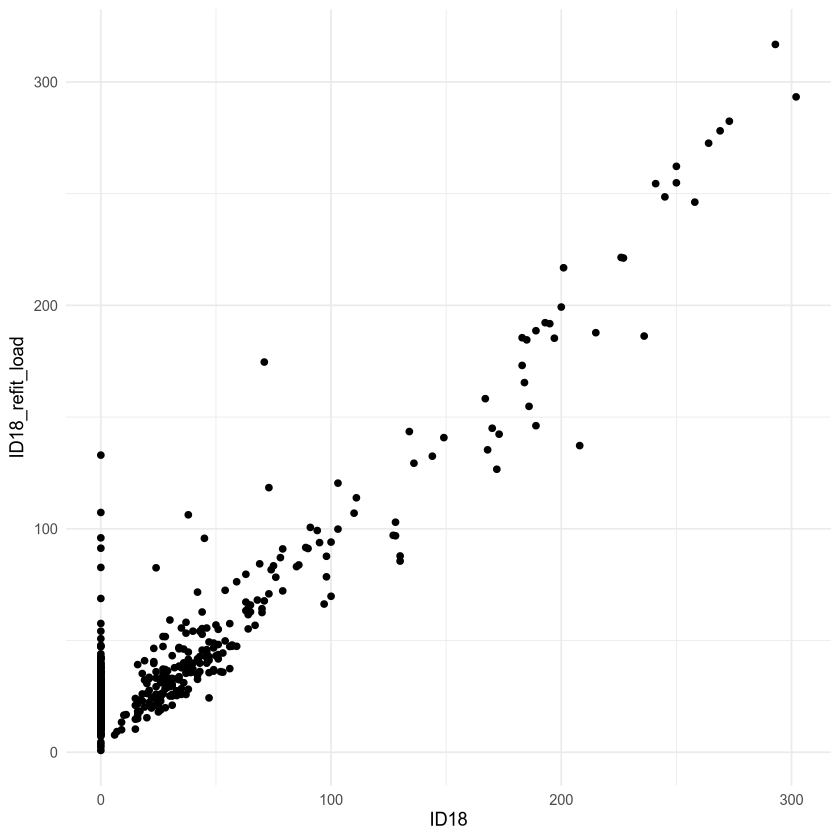

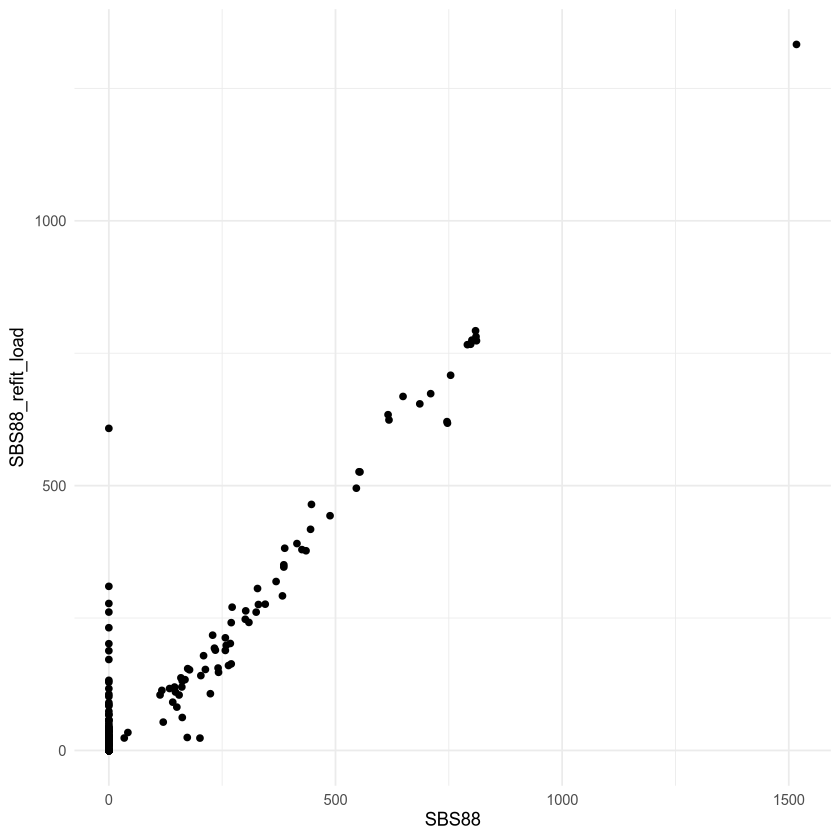

In [9]:
ggplot(combined_df, aes(x=ID18, y=ID18_refit_load)) + geom_point() + theme_minimal()
ggplot(combined_df, aes(x=SBS88, y=SBS88_refit_load)) + geom_point() + theme_minimal()


In [10]:
metrics <- c(
  "SBS88", "ID18", "ID18_perc", "snv_perc", "fraction_pksmotif",
  "SBS88_refit_load", "ID18_refit_load", "total_indels",
  "SBS88_refit_perc", "ID18_refit_perc", "n_with_driver_gene_coding",
  "fraction_pksmotif_coding", "total_indels_genic","fraction_pksmotif_genic",
  "n_AA_coding","n_with_driver_gene_id","n_with_driver_gene_snv",
  "total_coding_indels","total_indels_genic","n_AA_genic", "n_with_gene_snv",
  "ID18_refit_coding", "SBS88_refit_coding","ID18_refit_genic","SBS88_refit_genic",
  "n_with_coding_snv"
)

Warning message in cor.test.default(combined_df$age, combined_df[[m]], method = "spearman", :
“Cannot compute exact p-value with ties”
`geom_smooth()` using formula = 'y ~ x'
Warning message in cor.test.default(combined_df$age, combined_df[[m]], method = "spearman", :
“Cannot compute exact p-value with ties”
`geom_smooth()` using formula = 'y ~ x'


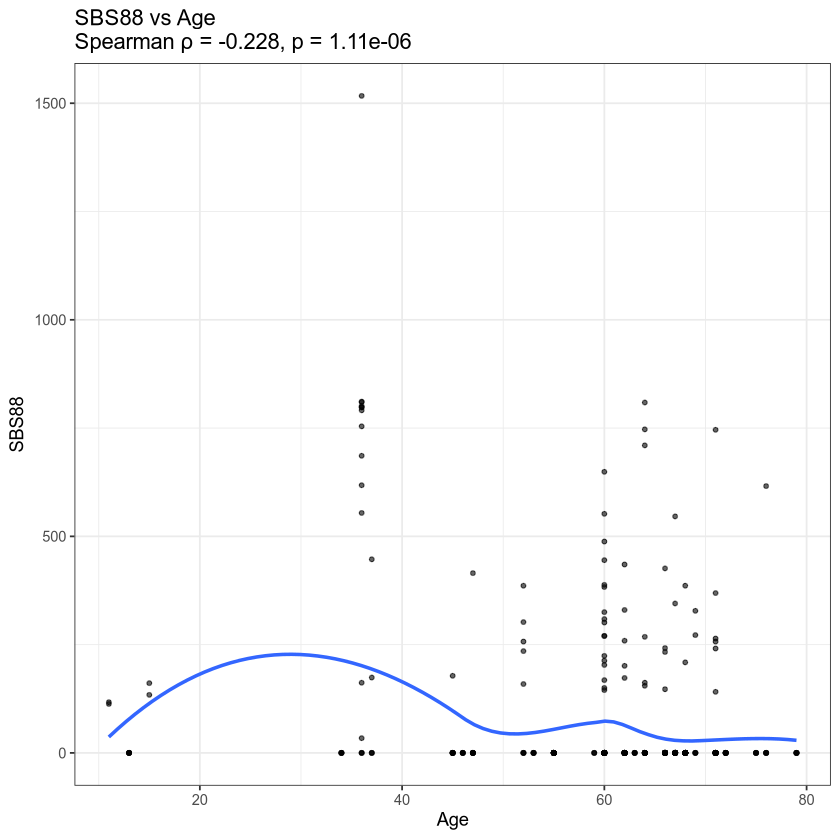

Warning message in cor.test.default(combined_df$age, combined_df[[m]], method = "spearman", :
“Cannot compute exact p-value with ties”
`geom_smooth()` using formula = 'y ~ x'


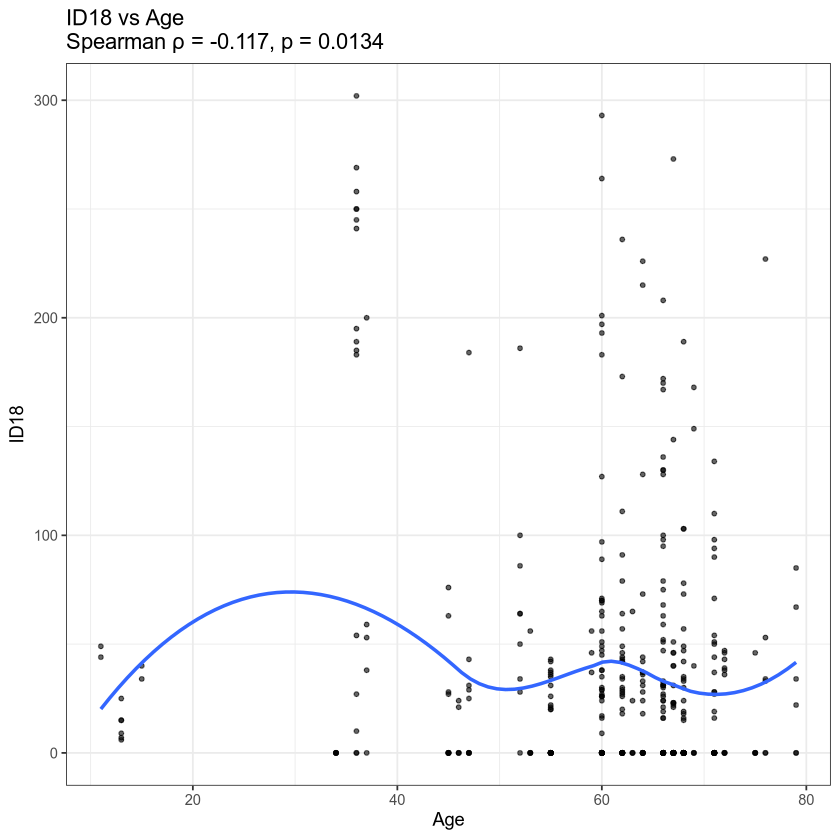

Warning message in cor.test.default(combined_df$age, combined_df[[m]], method = "spearman", :
“Cannot compute exact p-value with ties”
`geom_smooth()` using formula = 'y ~ x'


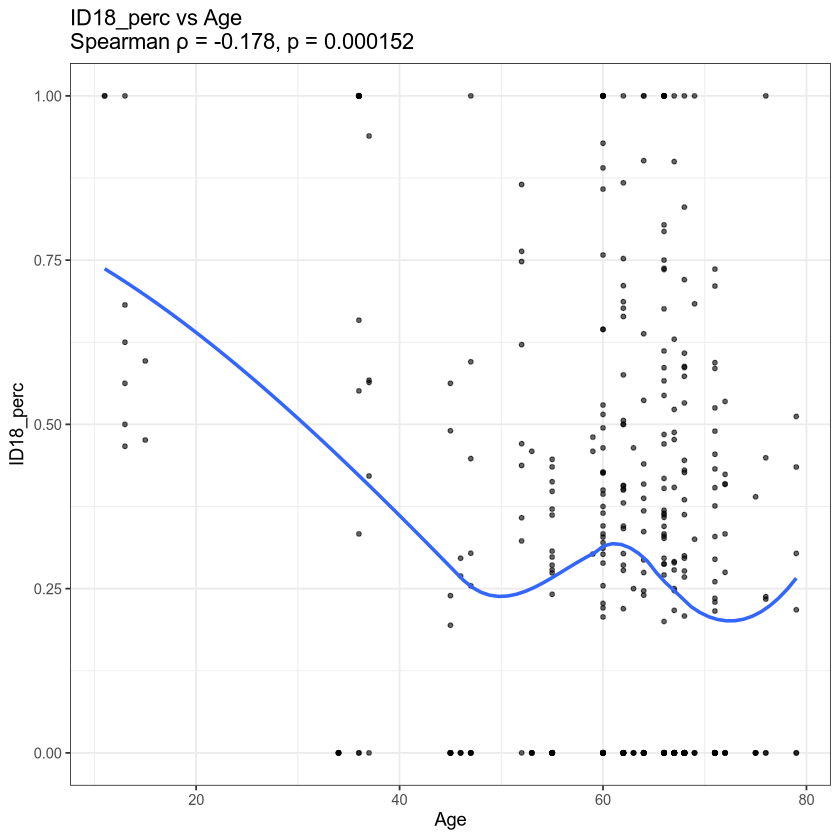

Warning message in cor.test.default(combined_df$age, combined_df[[m]], method = "spearman", :
“Cannot compute exact p-value with ties”
`geom_smooth()` using formula = 'y ~ x'


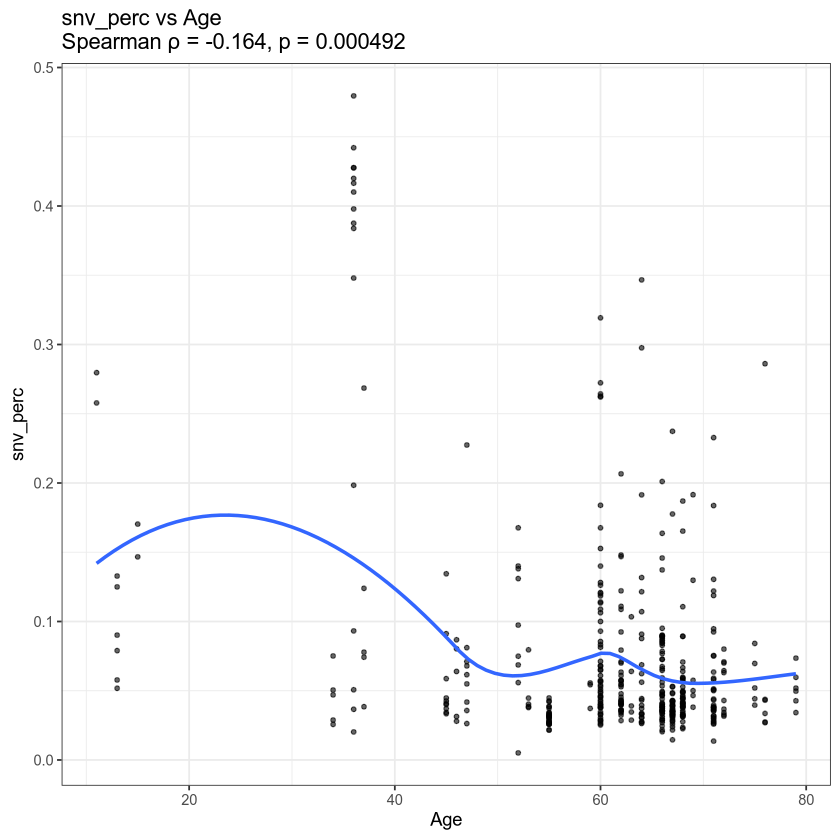

Warning message in cor.test.default(combined_df$age, combined_df[[m]], method = "spearman", :
“Cannot compute exact p-value with ties”
`geom_smooth()` using formula = 'y ~ x'


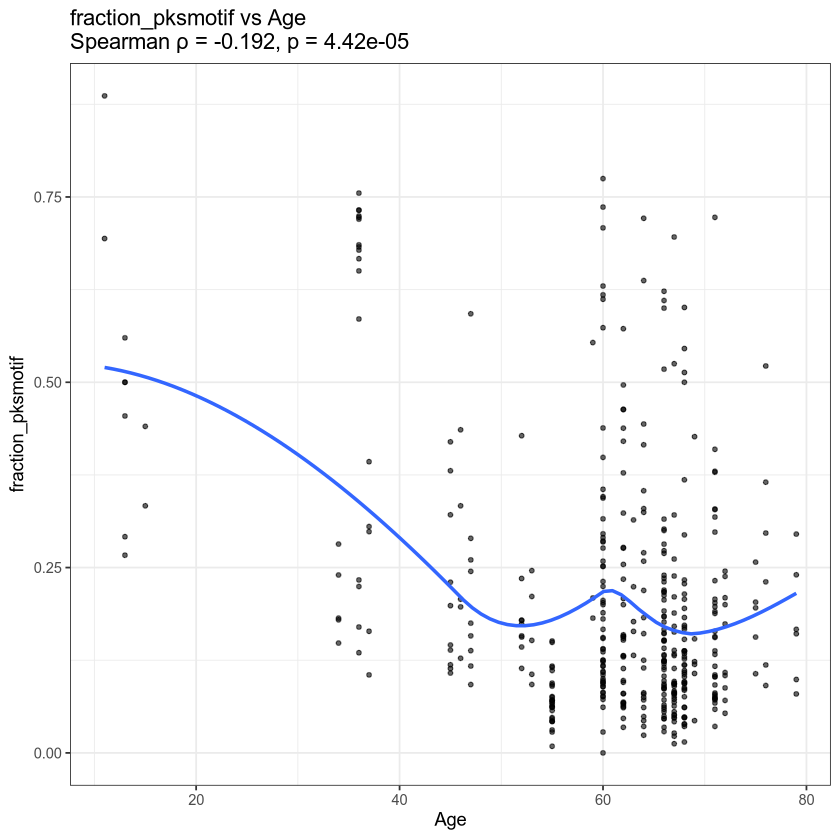

Warning message in cor.test.default(combined_df$age, combined_df[[m]], method = "spearman", :
“Cannot compute exact p-value with ties”
`geom_smooth()` using formula = 'y ~ x'


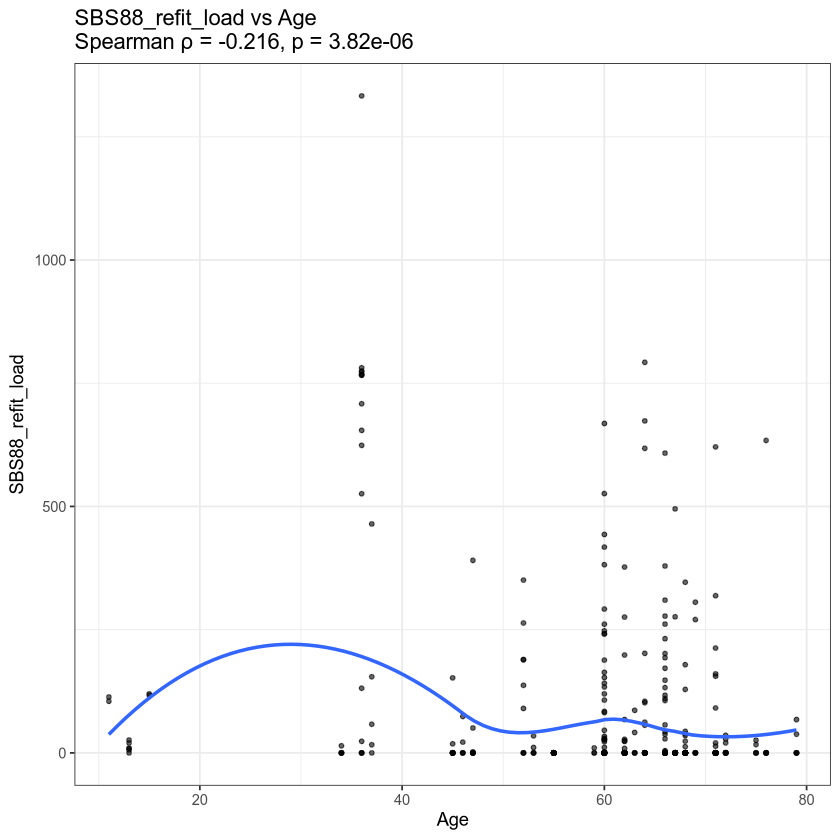

Warning message in cor.test.default(combined_df$age, combined_df[[m]], method = "spearman", :
“Cannot compute exact p-value with ties”
`geom_smooth()` using formula = 'y ~ x'


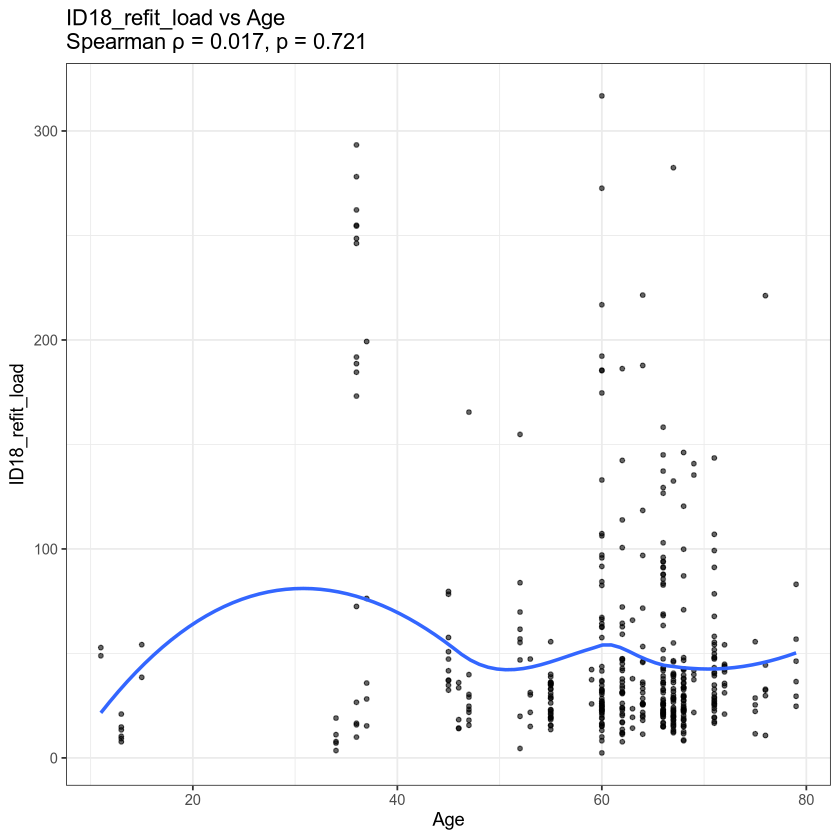

Warning message in cor.test.default(combined_df$age, combined_df[[m]], method = "spearman", :
“Cannot compute exact p-value with ties”
`geom_smooth()` using formula = 'y ~ x'


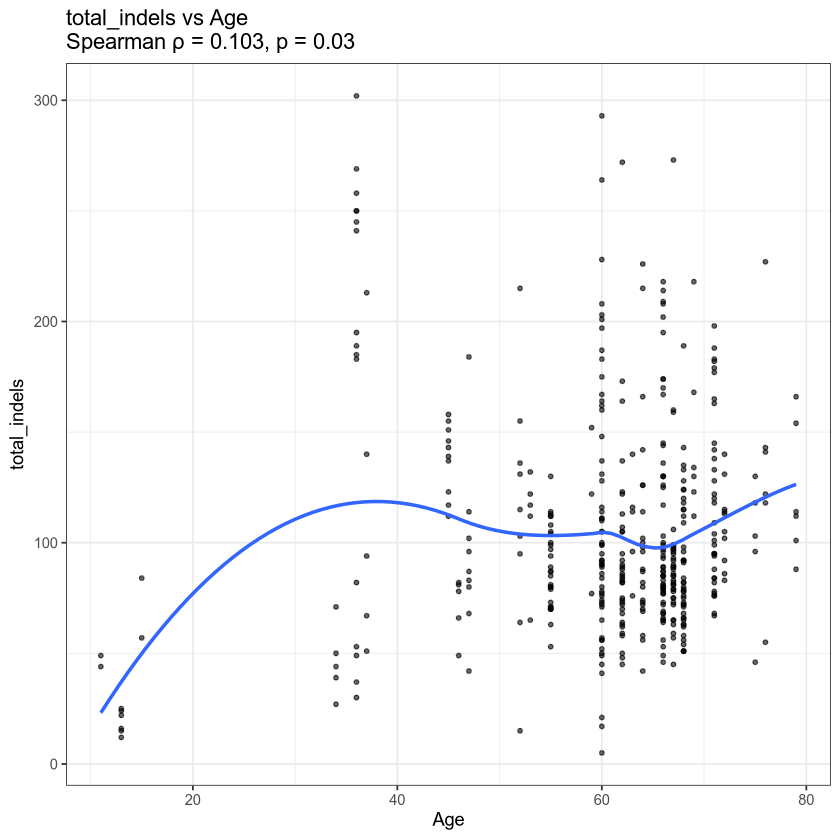

Warning message in cor.test.default(combined_df$age, combined_df[[m]], method = "spearman", :
“Cannot compute exact p-value with ties”
`geom_smooth()` using formula = 'y ~ x'


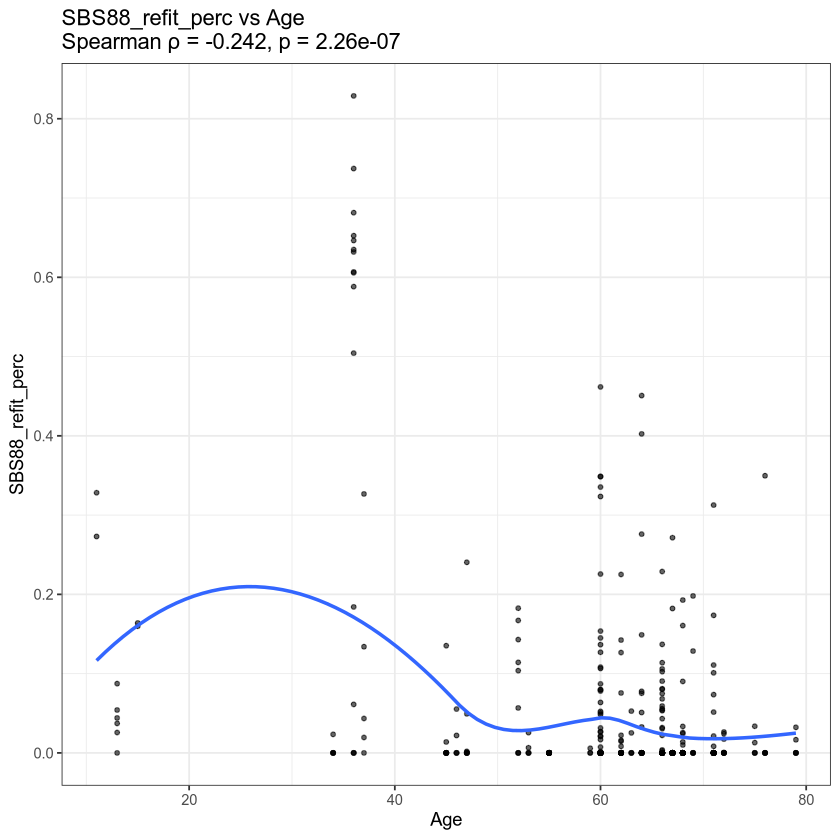

Warning message in cor.test.default(combined_df$age, combined_df[[m]], method = "spearman", :
“Cannot compute exact p-value with ties”
`geom_smooth()` using formula = 'y ~ x'


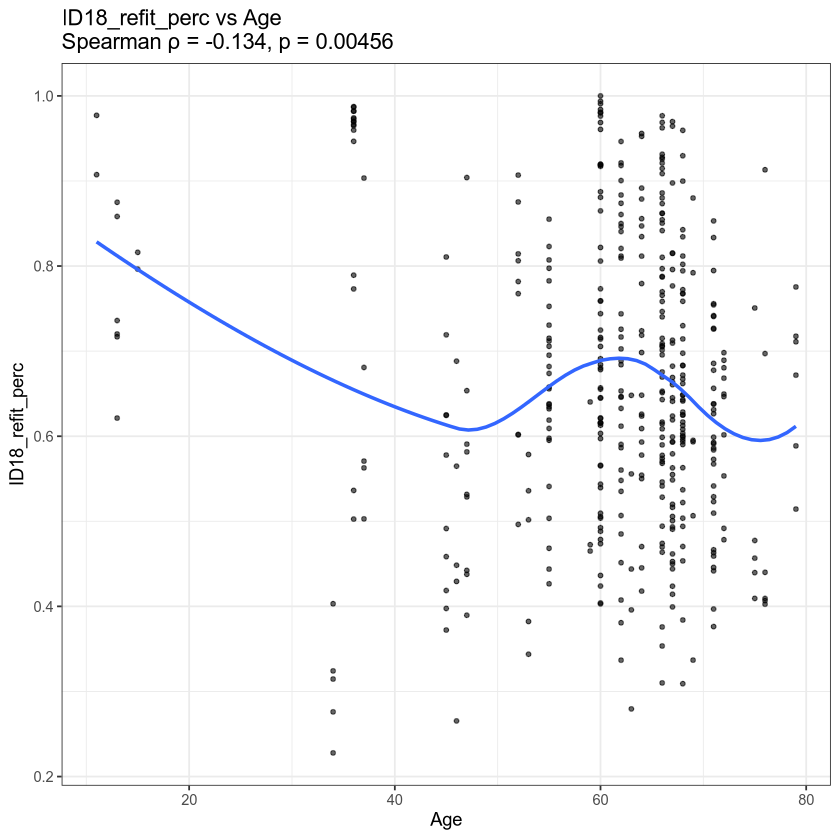

Warning message in cor.test.default(combined_df$age, combined_df[[m]], method = "spearman", :
“Cannot compute exact p-value with ties”
`geom_smooth()` using formula = 'y ~ x'


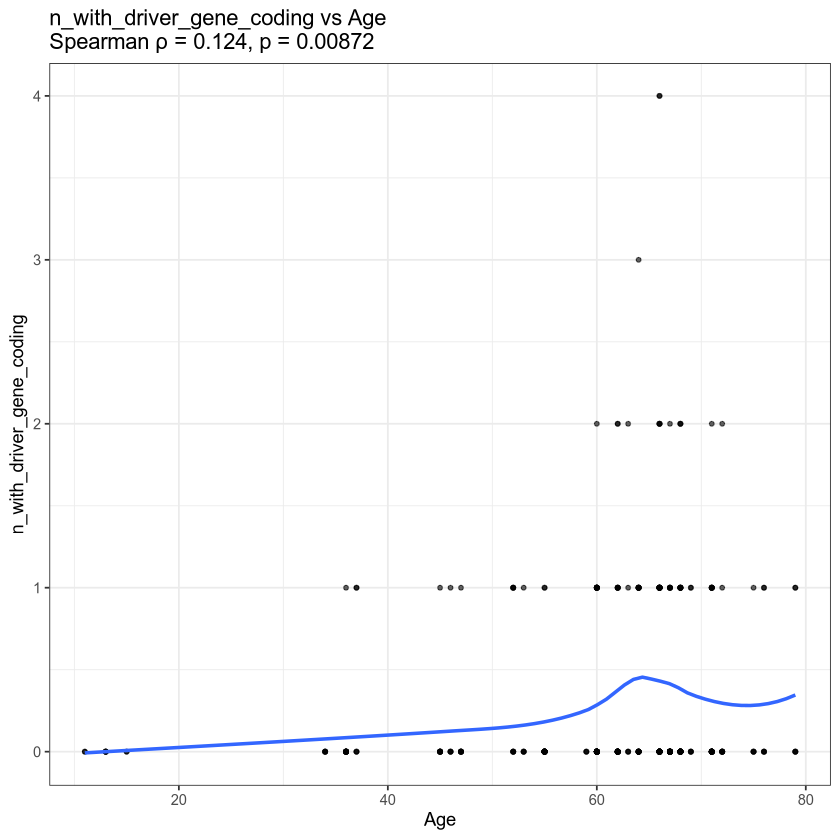

Warning message in cor.test.default(combined_df$age, combined_df[[m]], method = "spearman", :
“Cannot compute exact p-value with ties”
`geom_smooth()` using formula = 'y ~ x'


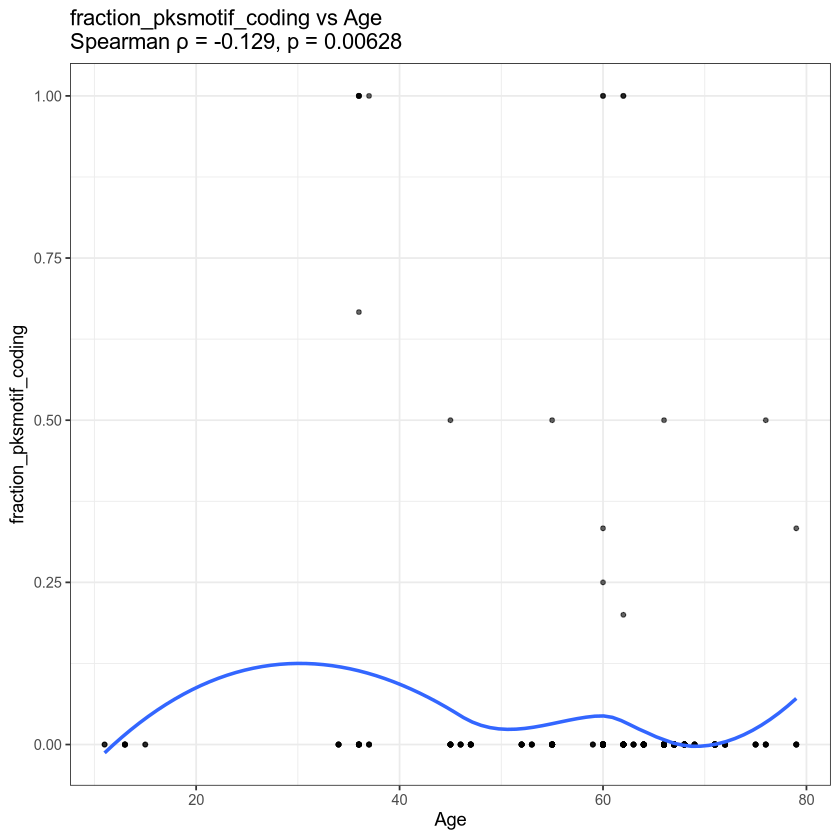

Warning message in cor.test.default(combined_df$age, combined_df[[m]], method = "spearman", :
“Cannot compute exact p-value with ties”
`geom_smooth()` using formula = 'y ~ x'


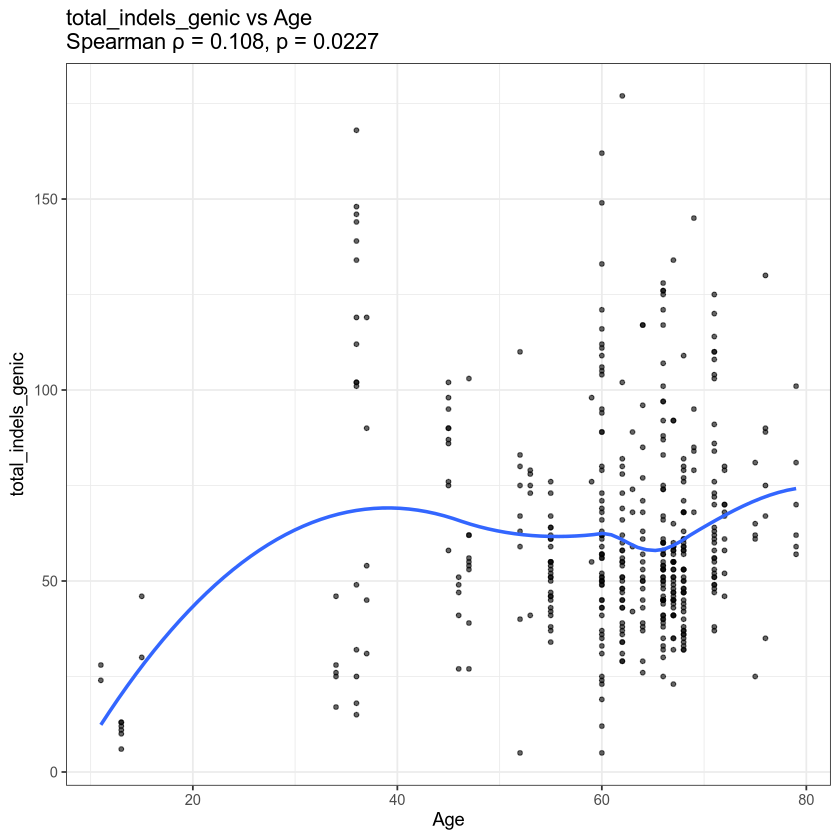

Warning message in cor.test.default(combined_df$age, combined_df[[m]], method = "spearman", :
“Cannot compute exact p-value with ties”
`geom_smooth()` using formula = 'y ~ x'


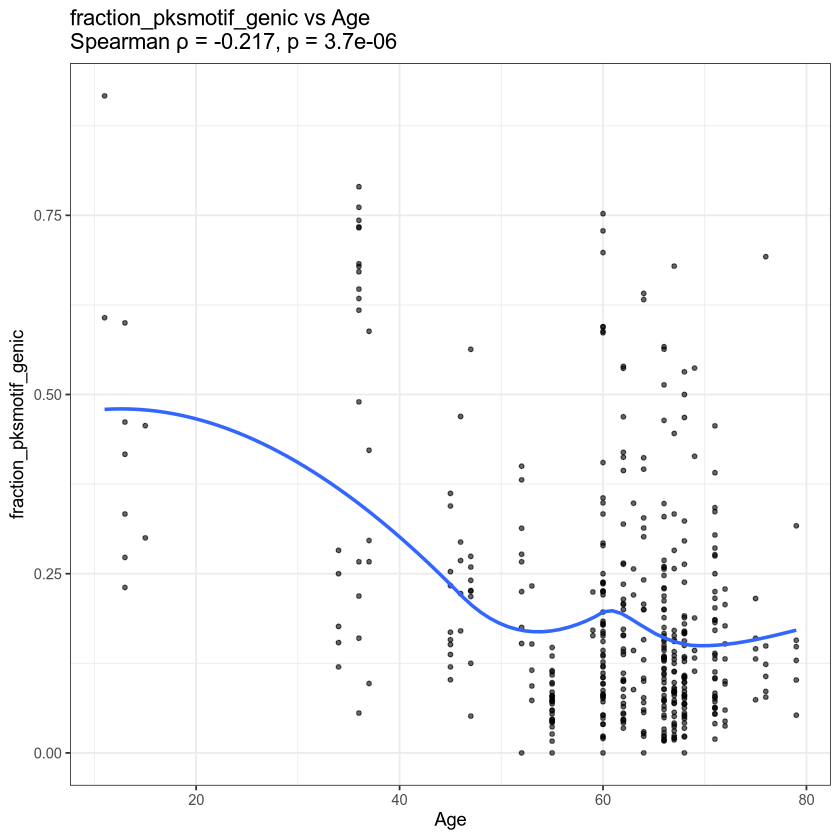

Warning message in cor.test.default(combined_df$age, combined_df[[m]], method = "spearman", :
“Cannot compute exact p-value with ties”
`geom_smooth()` using formula = 'y ~ x'


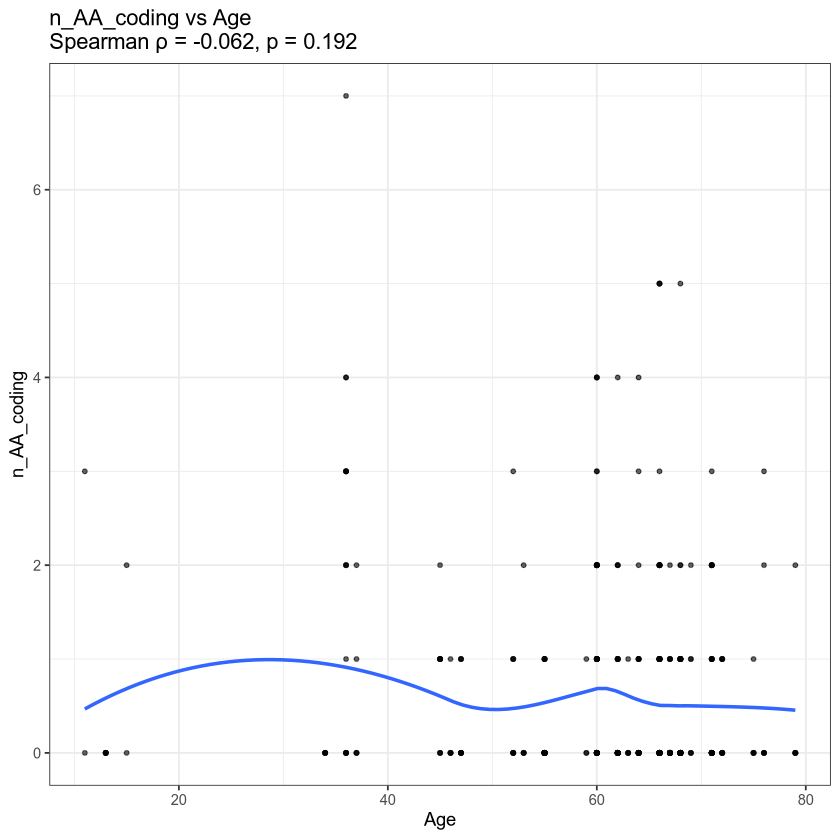

Warning message in cor.test.default(combined_df$age, combined_df[[m]], method = "spearman", :
“Cannot compute exact p-value with ties”
`geom_smooth()` using formula = 'y ~ x'


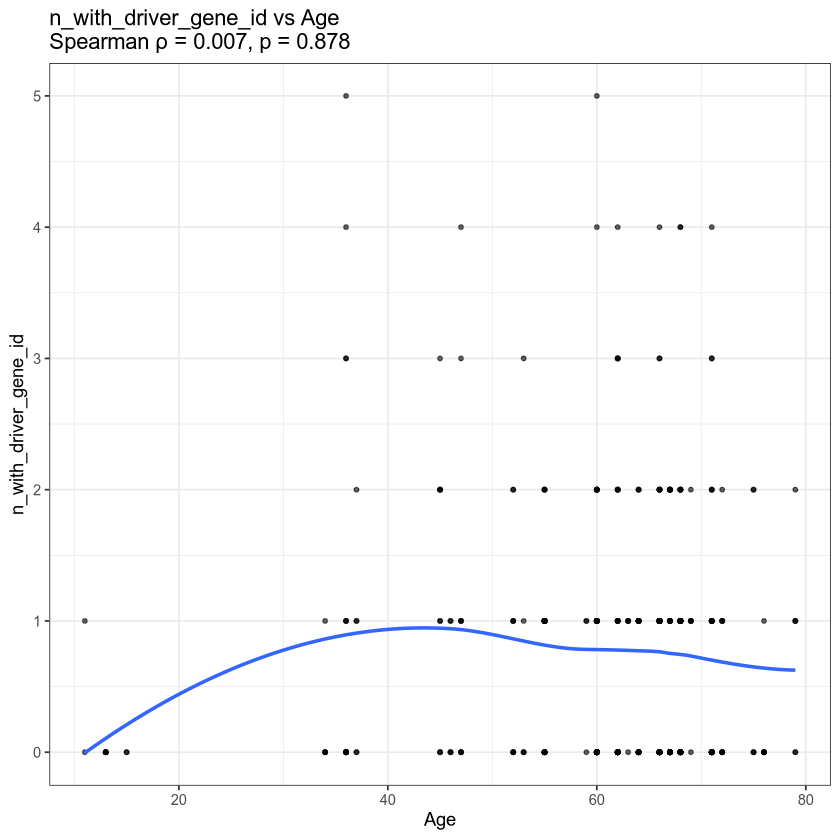

Warning message in cor.test.default(combined_df$age, combined_df[[m]], method = "spearman", :
“Cannot compute exact p-value with ties”
`geom_smooth()` using formula = 'y ~ x'


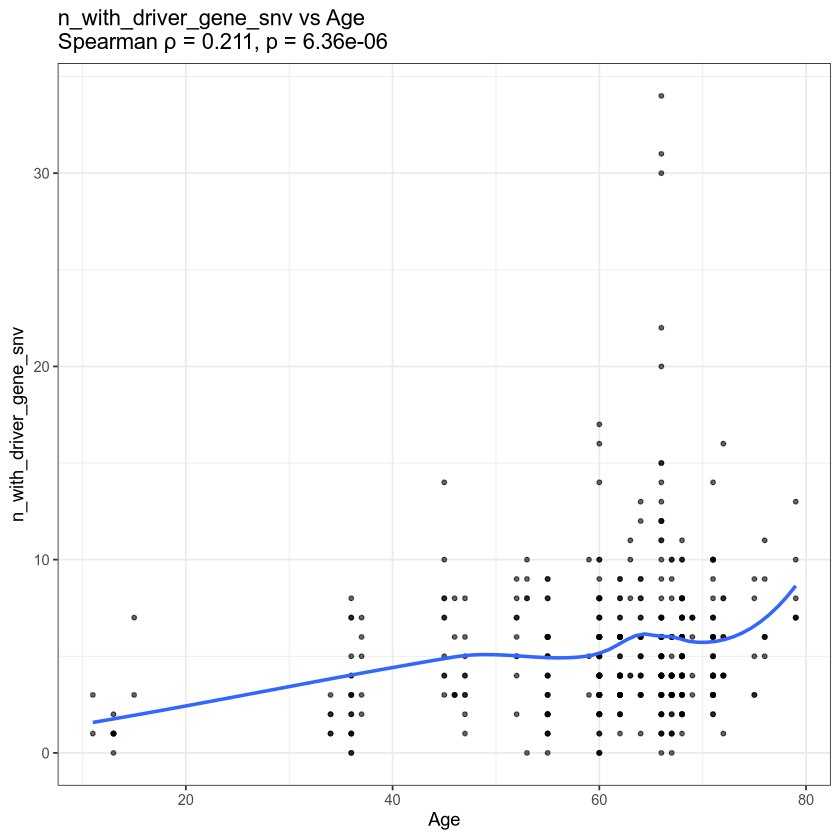

Warning message in cor.test.default(combined_df$age, combined_df[[m]], method = "spearman", :
“Cannot compute exact p-value with ties”
`geom_smooth()` using formula = 'y ~ x'


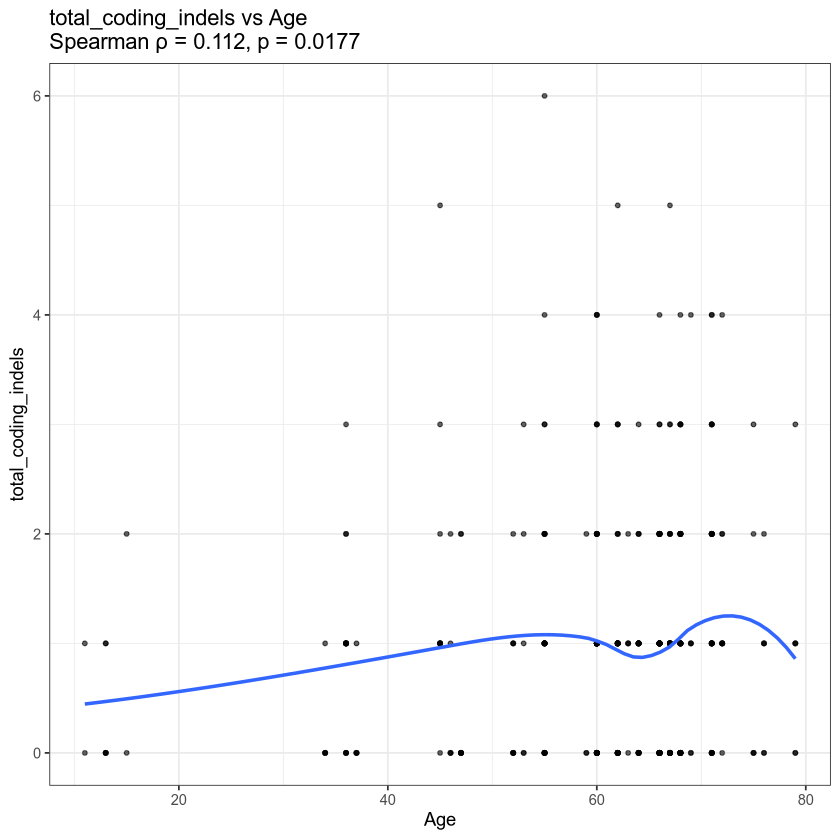

Warning message in cor.test.default(combined_df$age, combined_df[[m]], method = "spearman", :
“Cannot compute exact p-value with ties”
`geom_smooth()` using formula = 'y ~ x'


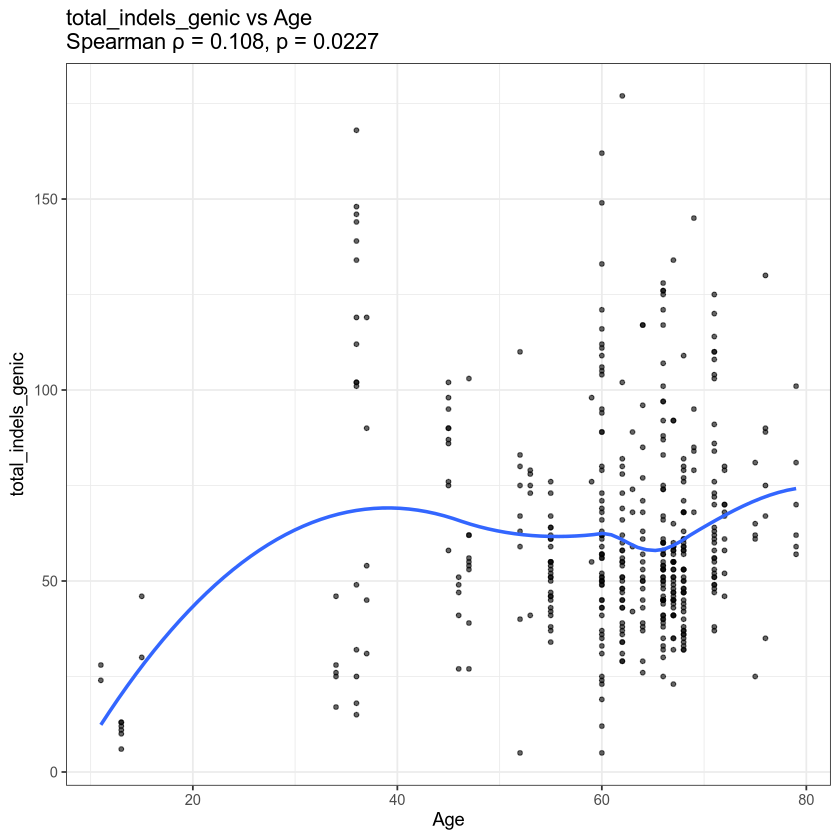

Warning message in cor.test.default(combined_df$age, combined_df[[m]], method = "spearman", :
“Cannot compute exact p-value with ties”
`geom_smooth()` using formula = 'y ~ x'


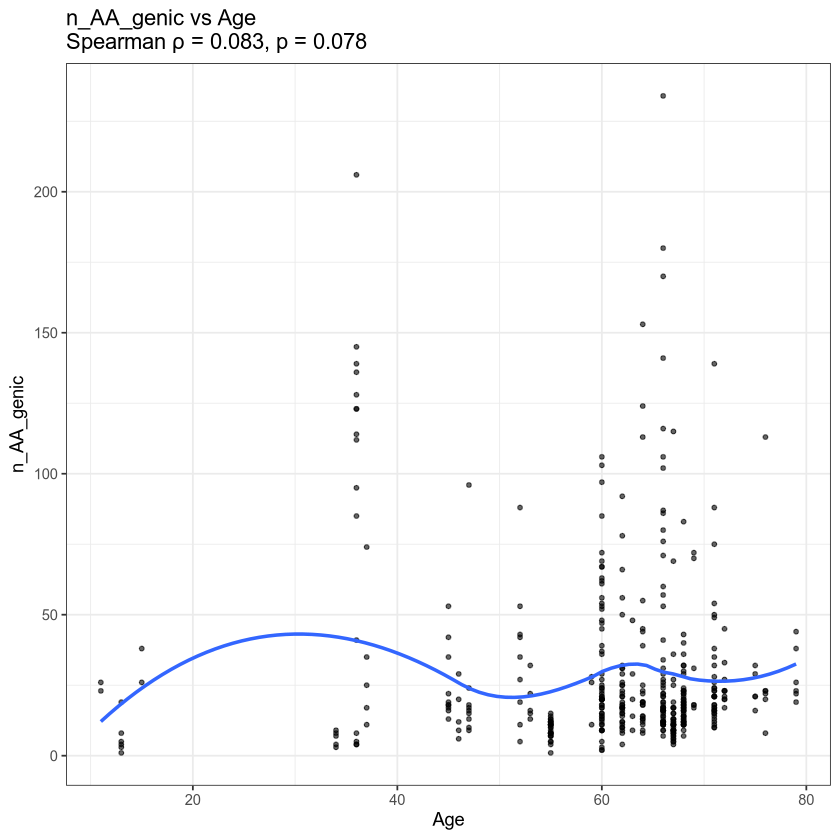

Warning message in cor.test.default(combined_df$age, combined_df[[m]], method = "spearman", :
“Cannot compute exact p-value with ties”
`geom_smooth()` using formula = 'y ~ x'


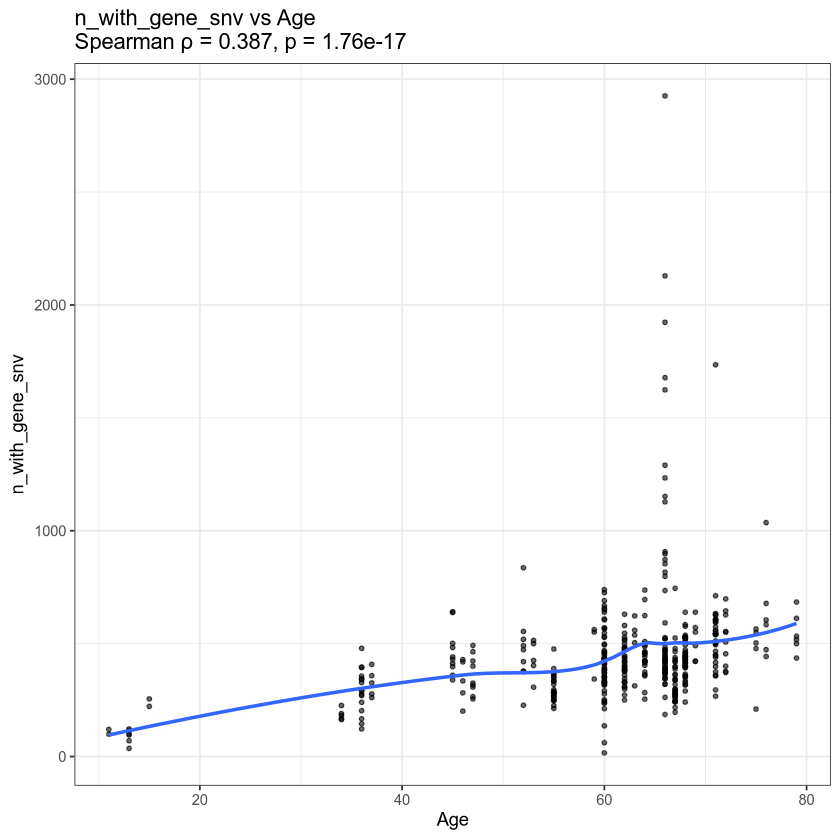

Warning message in cor.test.default(combined_df$age, combined_df[[m]], method = "spearman", :
“Cannot compute exact p-value with ties”
`geom_smooth()` using formula = 'y ~ x'


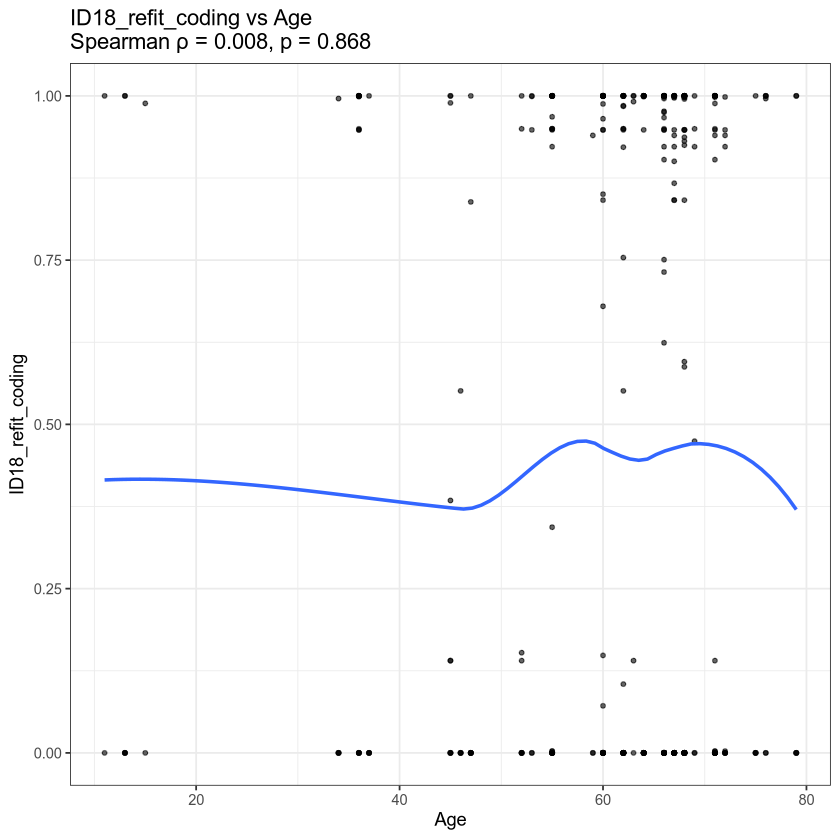

Warning message in cor.test.default(combined_df$age, combined_df[[m]], method = "spearman", :
“Cannot compute exact p-value with ties”
`geom_smooth()` using formula = 'y ~ x'


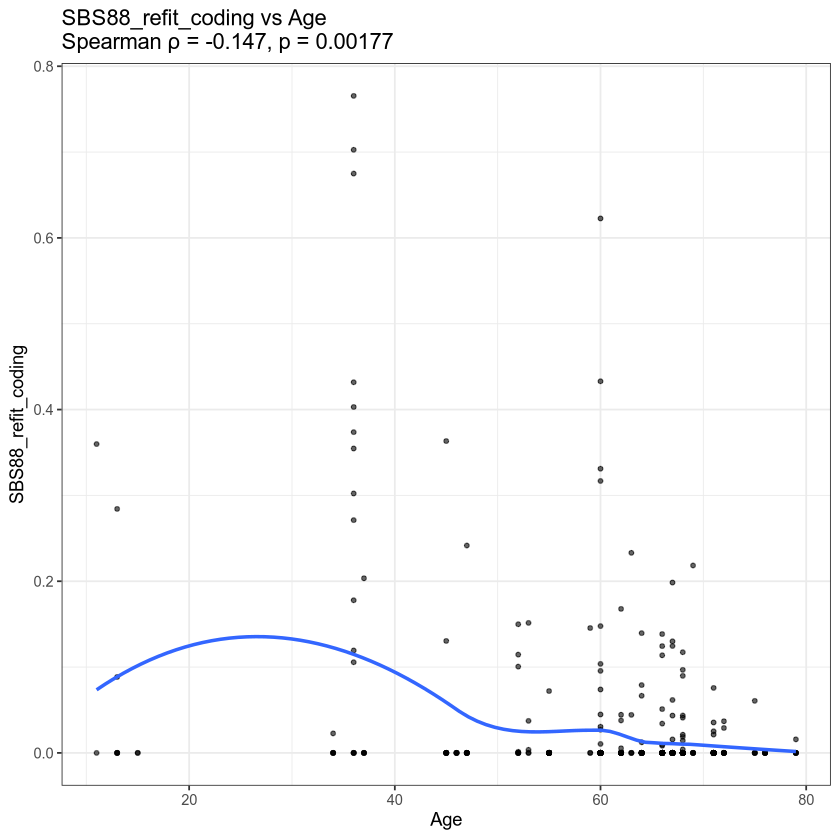

Warning message in cor.test.default(combined_df$age, combined_df[[m]], method = "spearman", :
“Cannot compute exact p-value with ties”
`geom_smooth()` using formula = 'y ~ x'


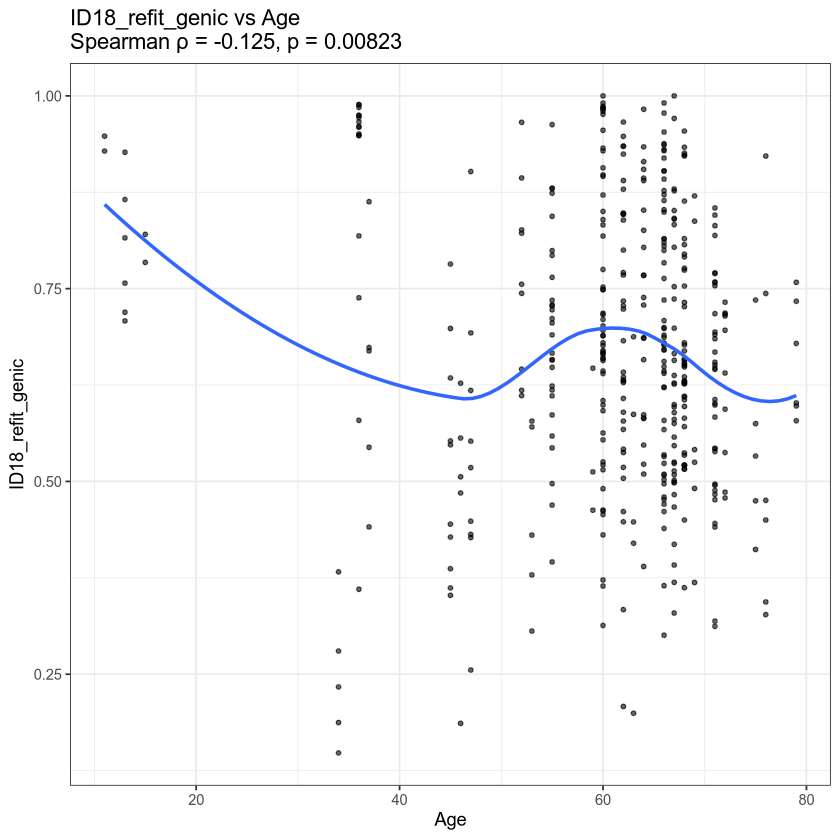

Warning message in cor.test.default(combined_df$age, combined_df[[m]], method = "spearman", :
“Cannot compute exact p-value with ties”
`geom_smooth()` using formula = 'y ~ x'


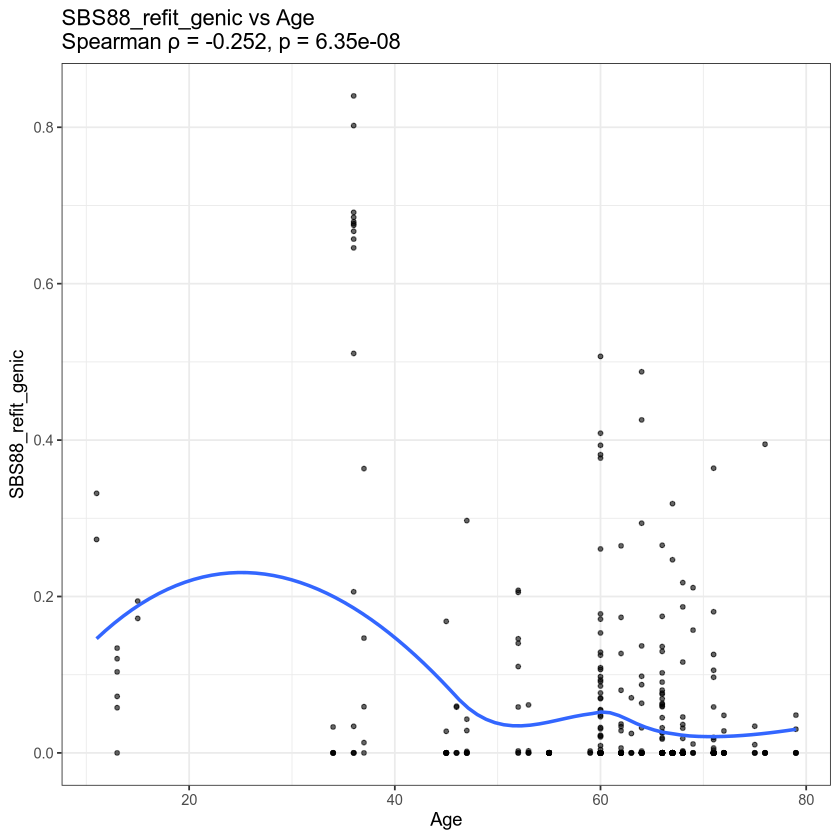

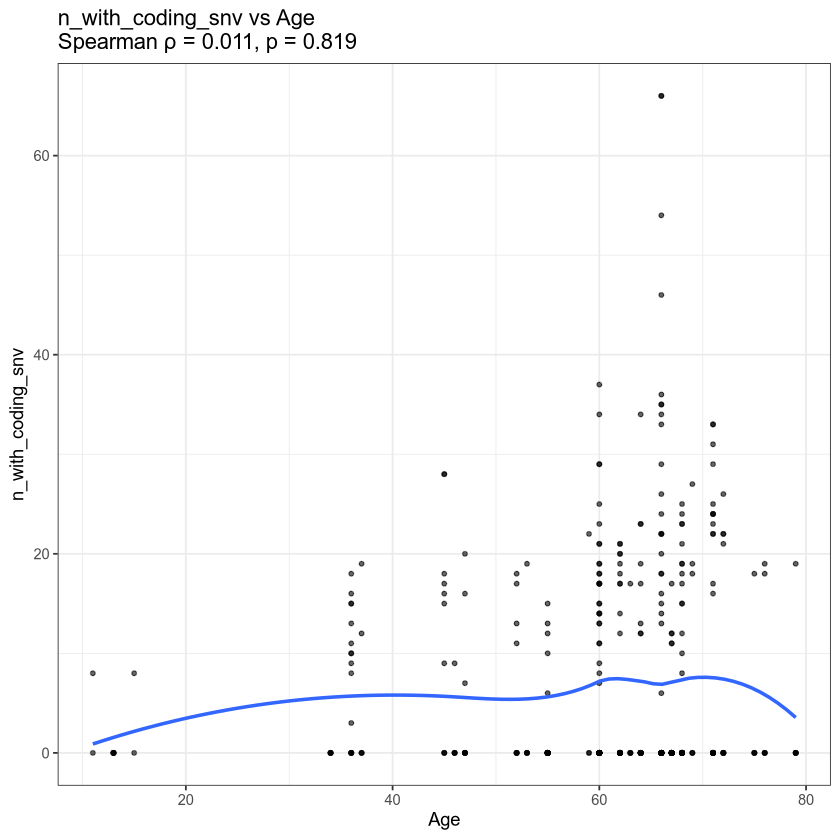

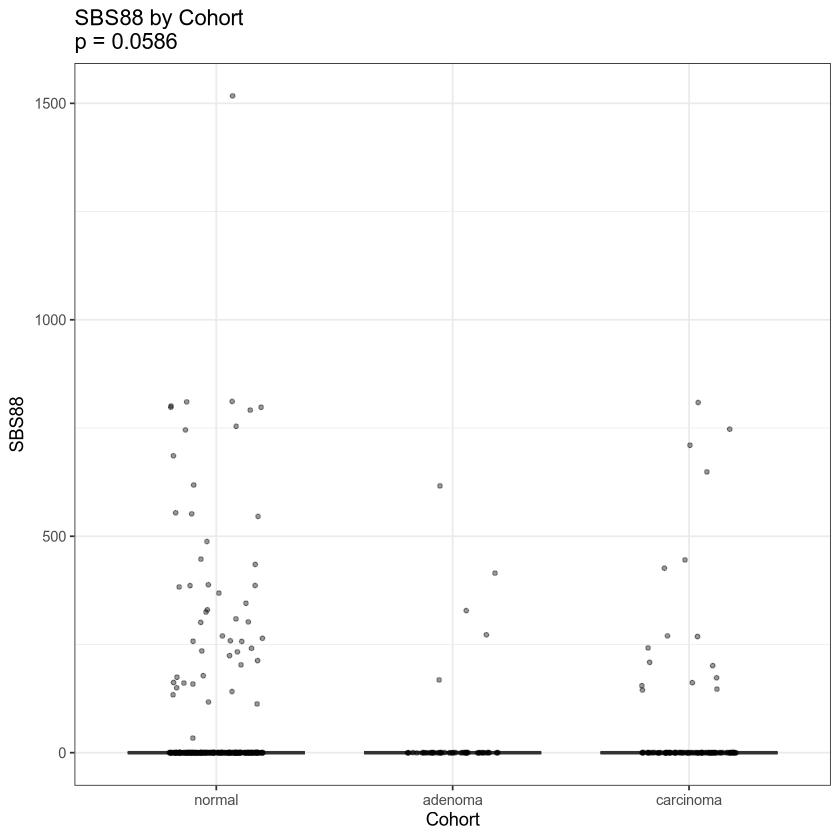

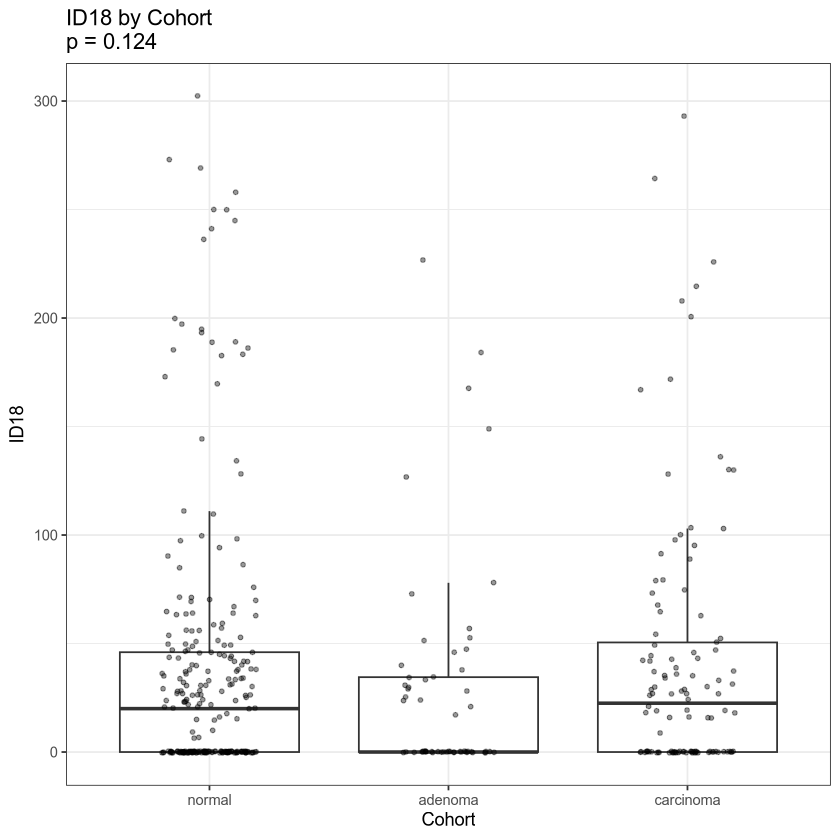

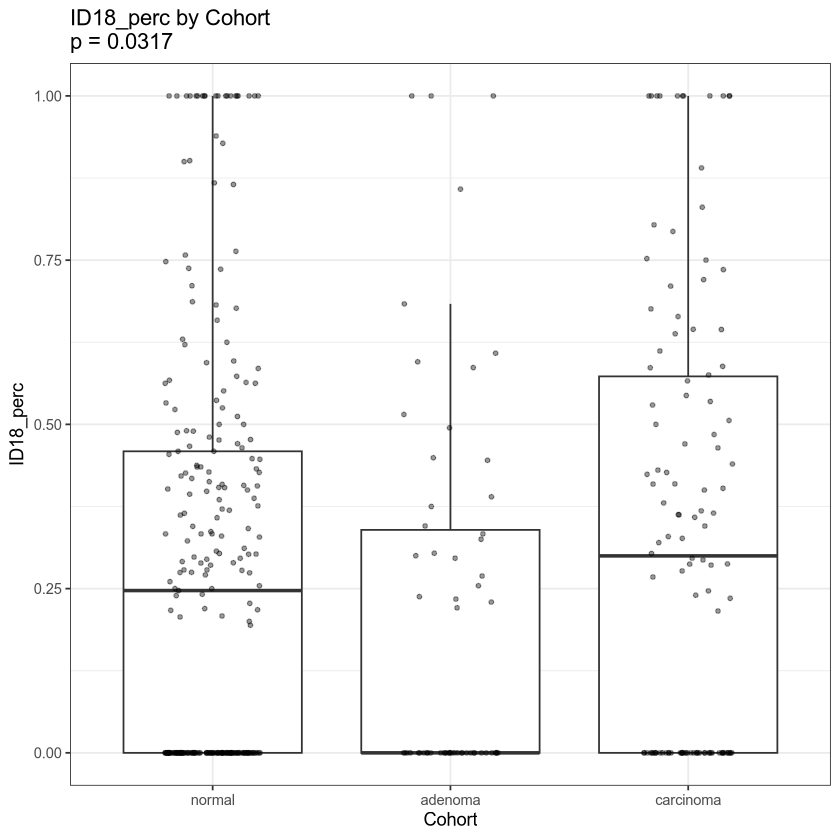

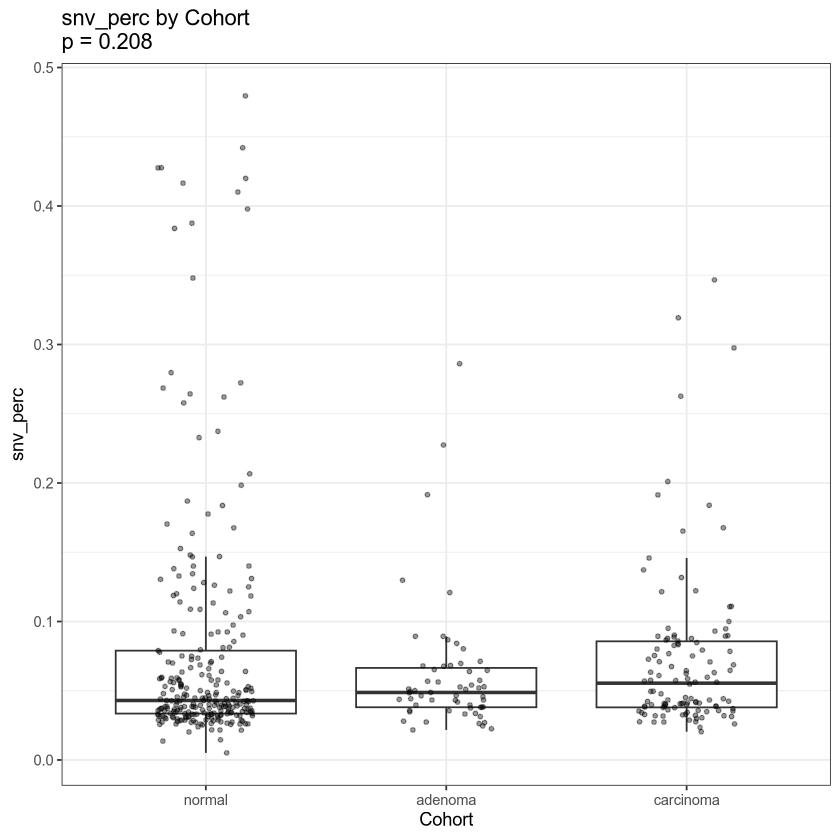

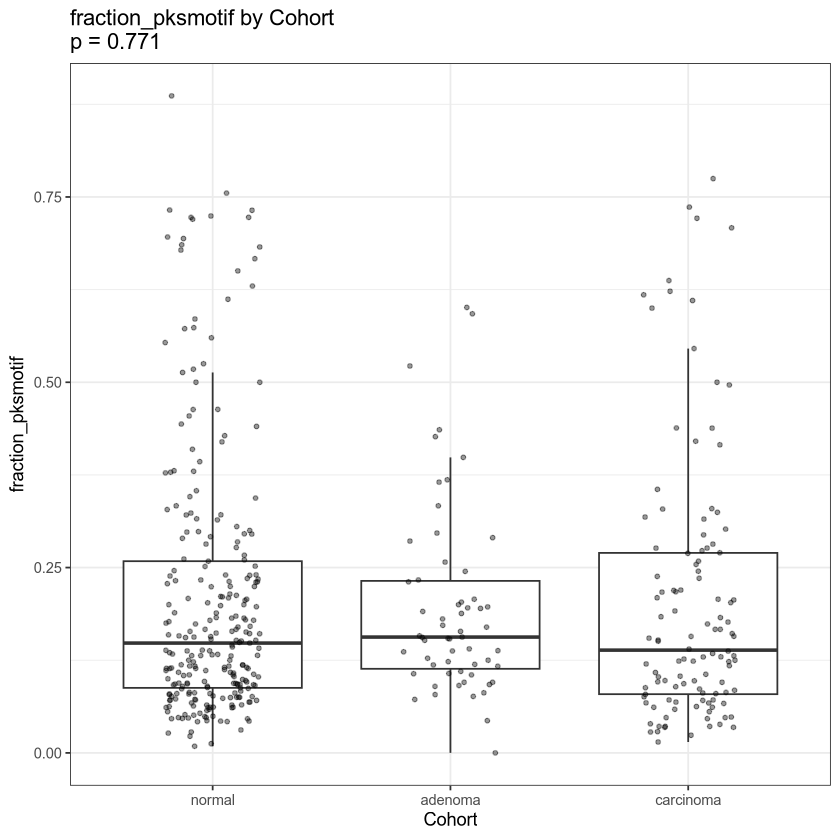

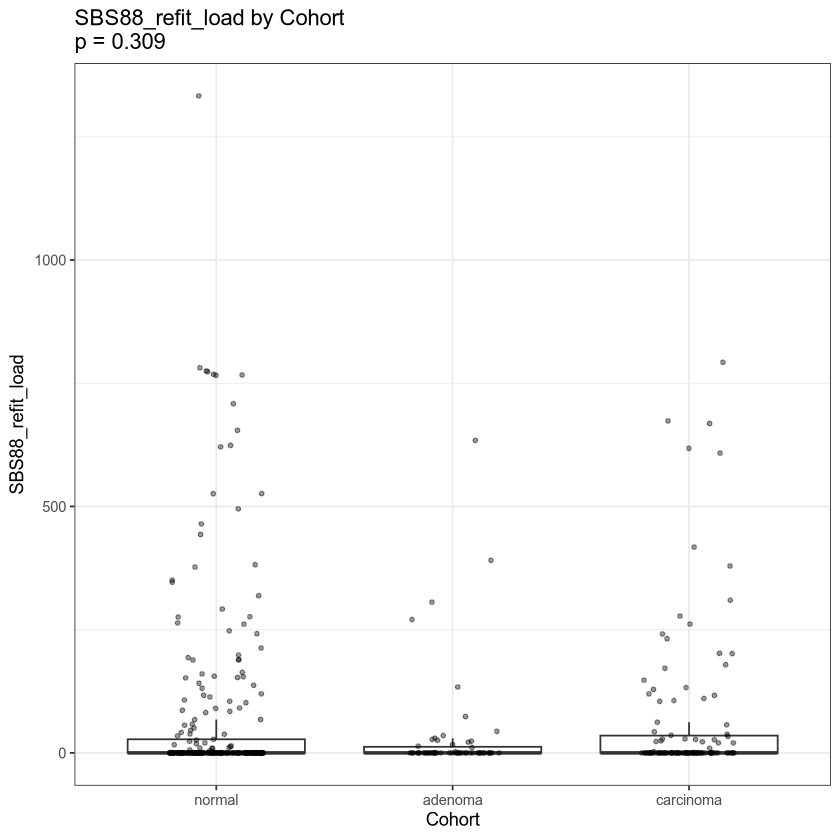

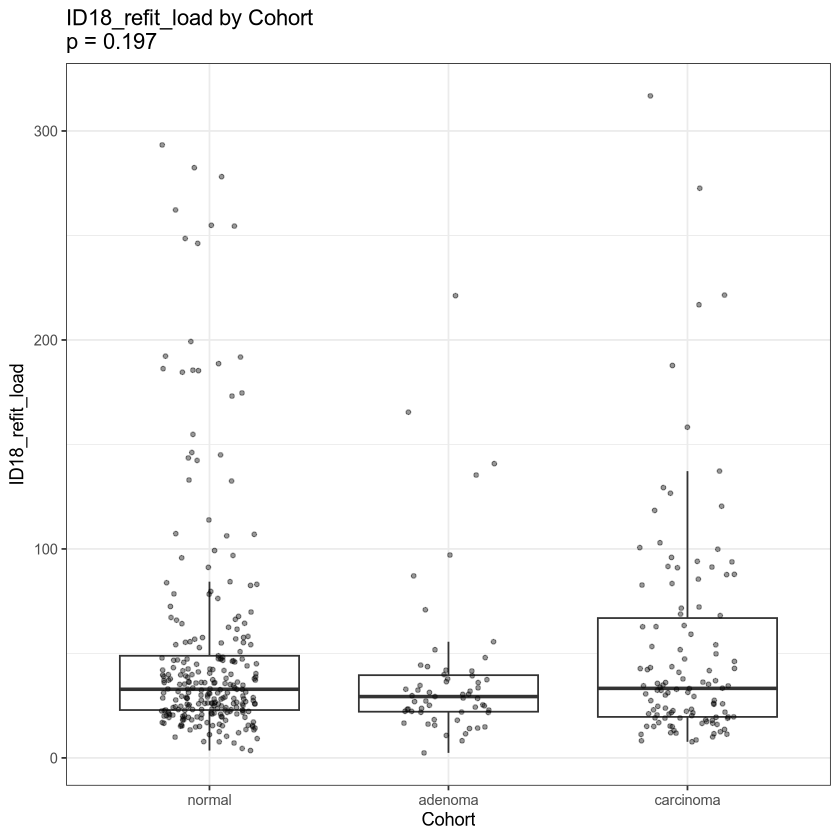

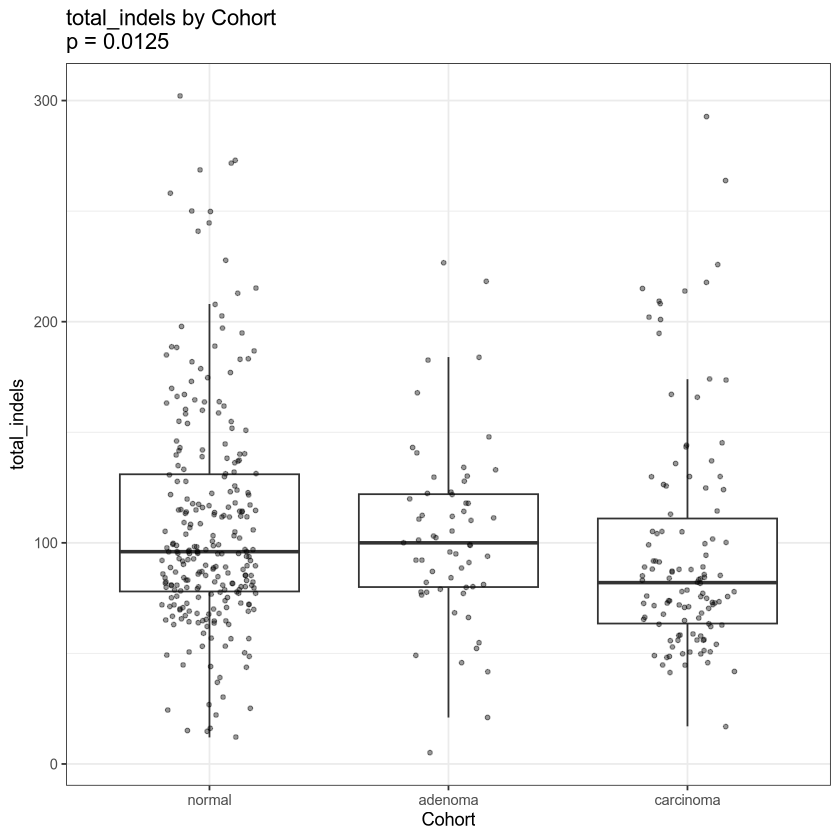

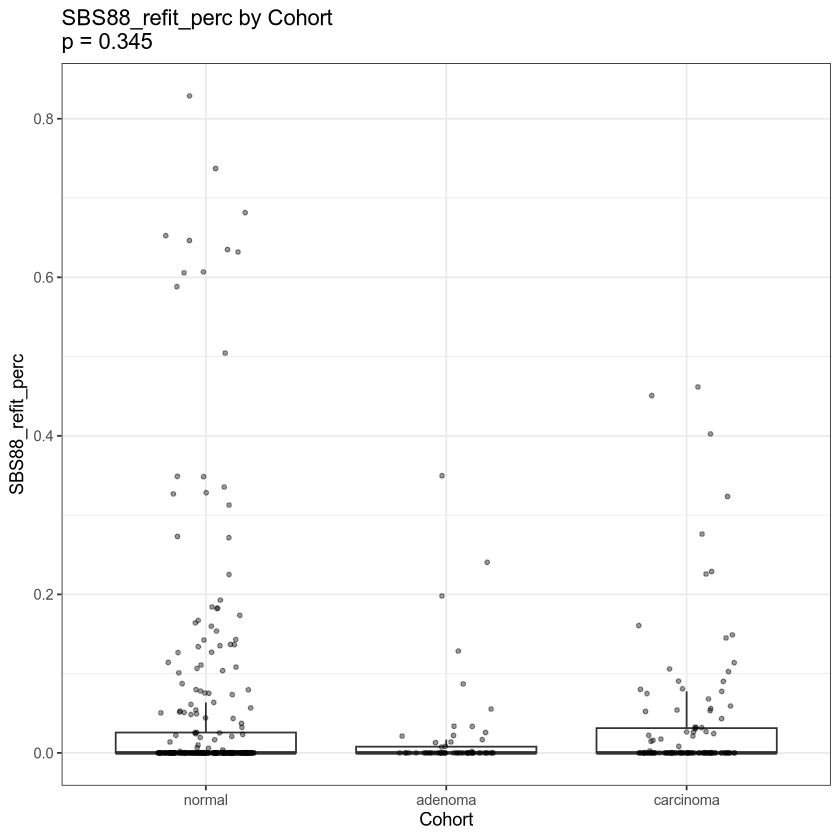

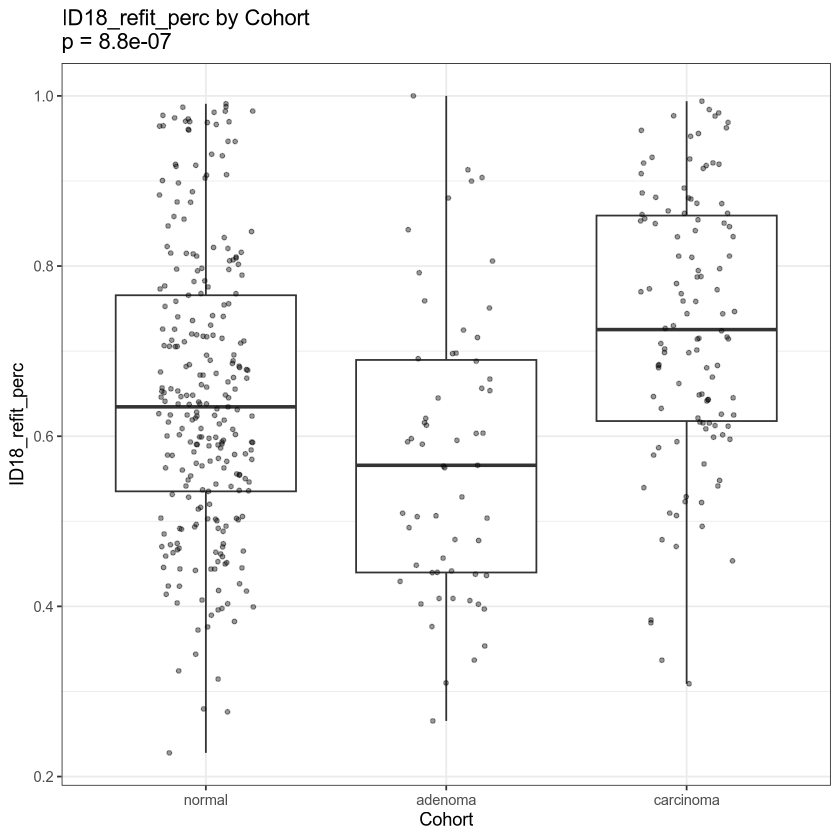

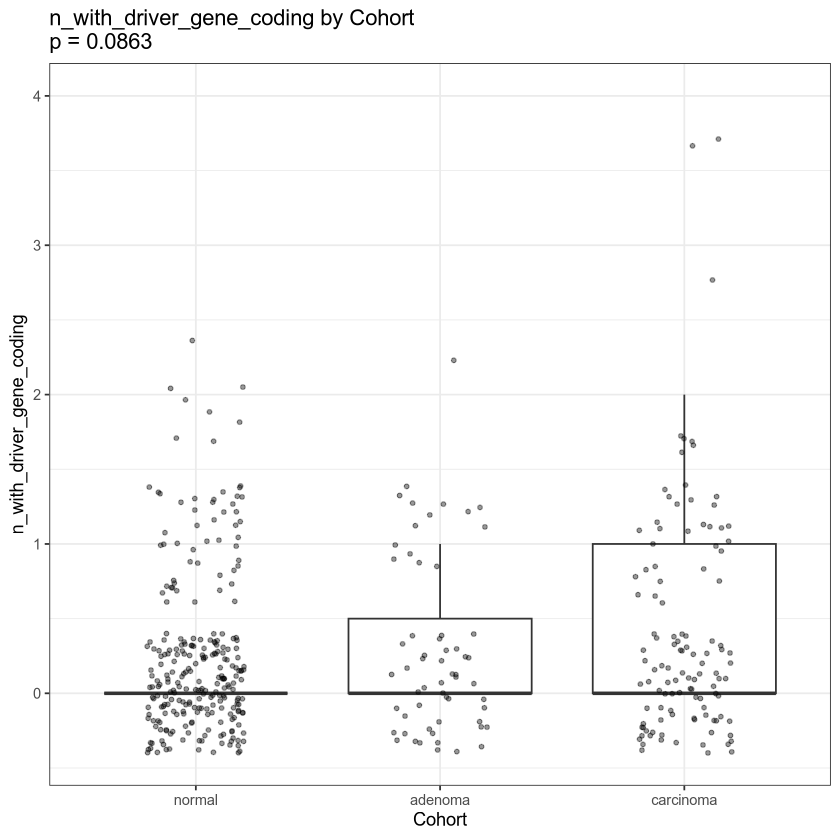

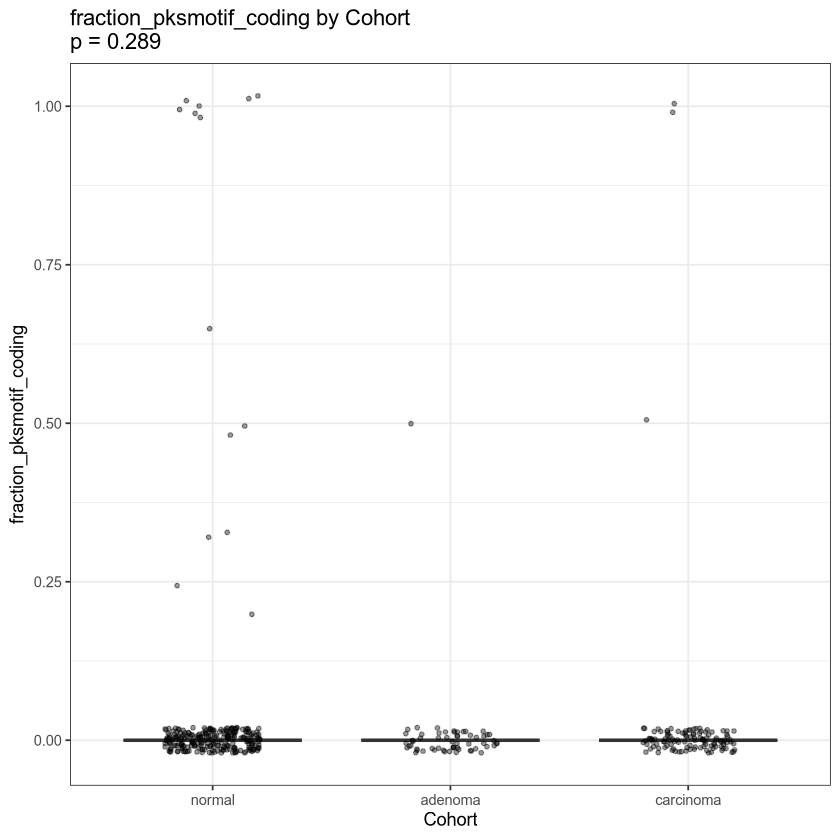

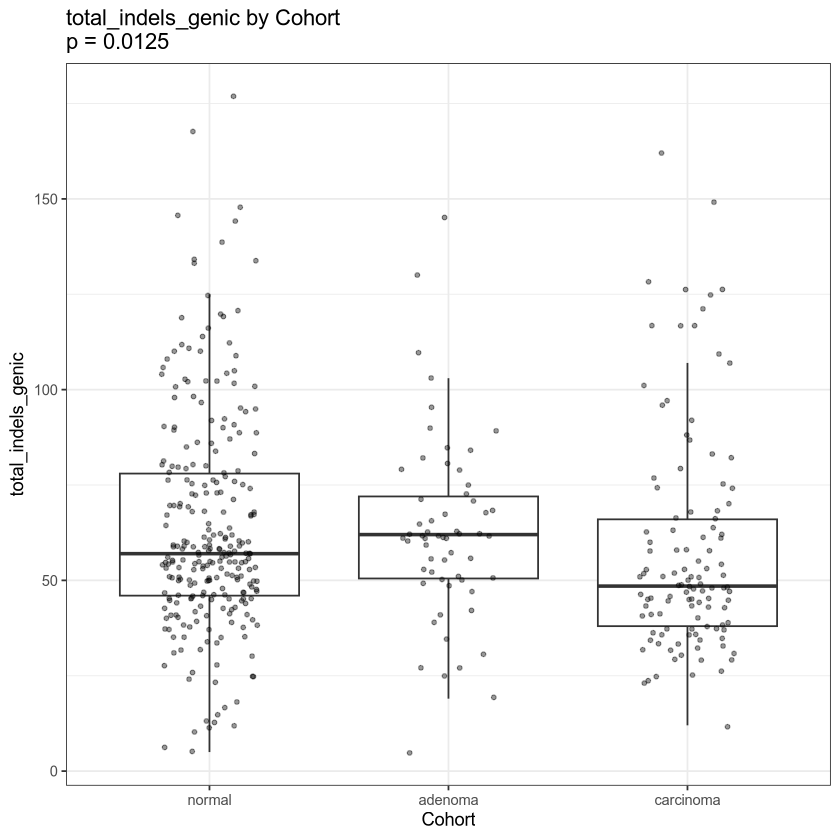

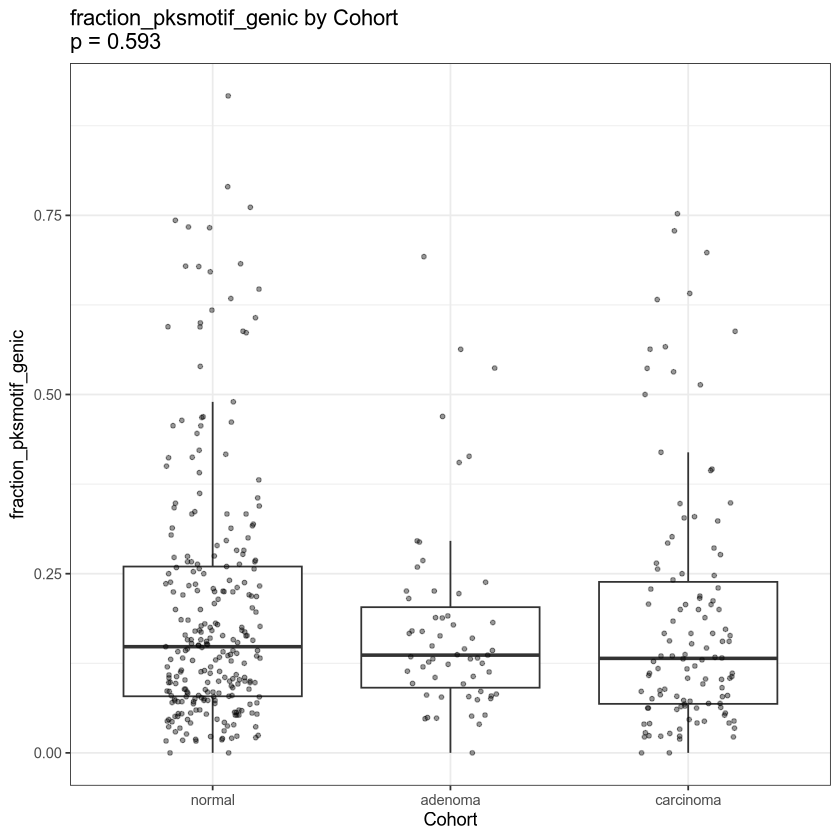

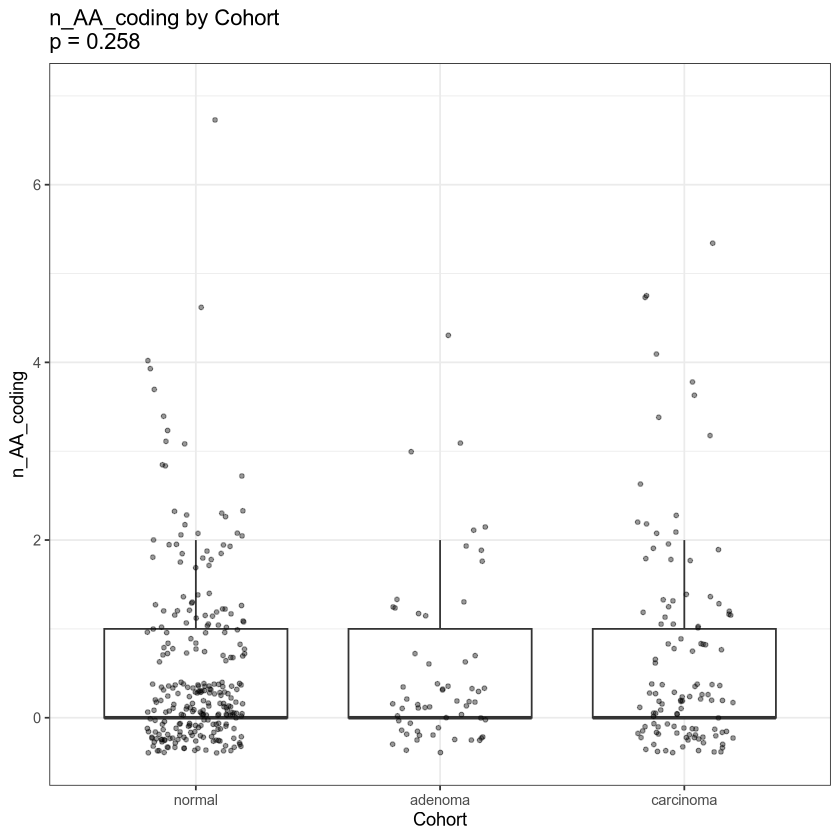

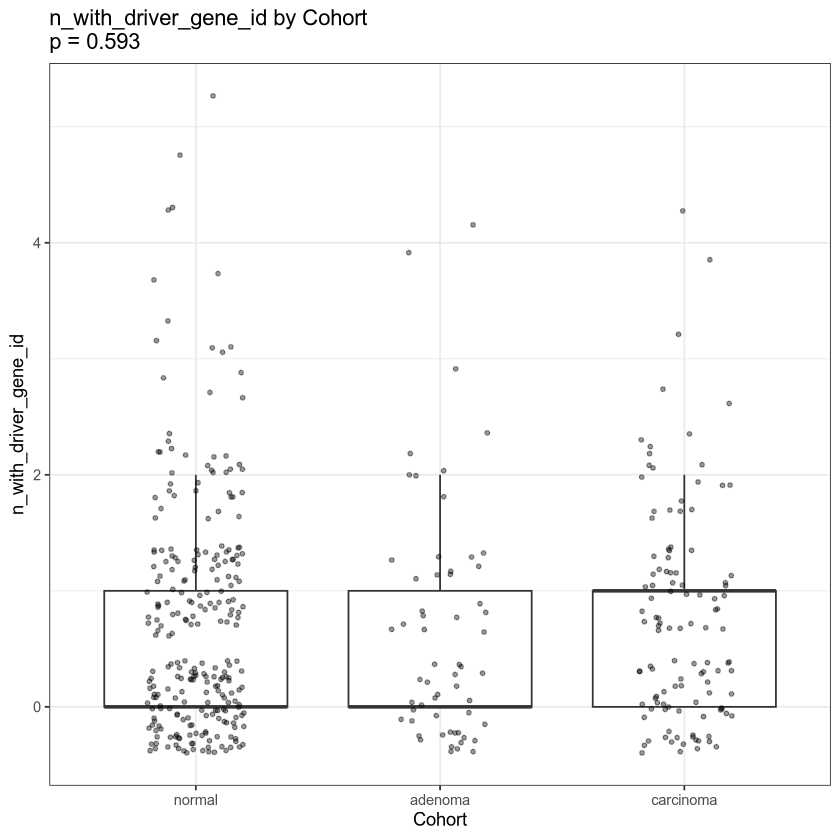

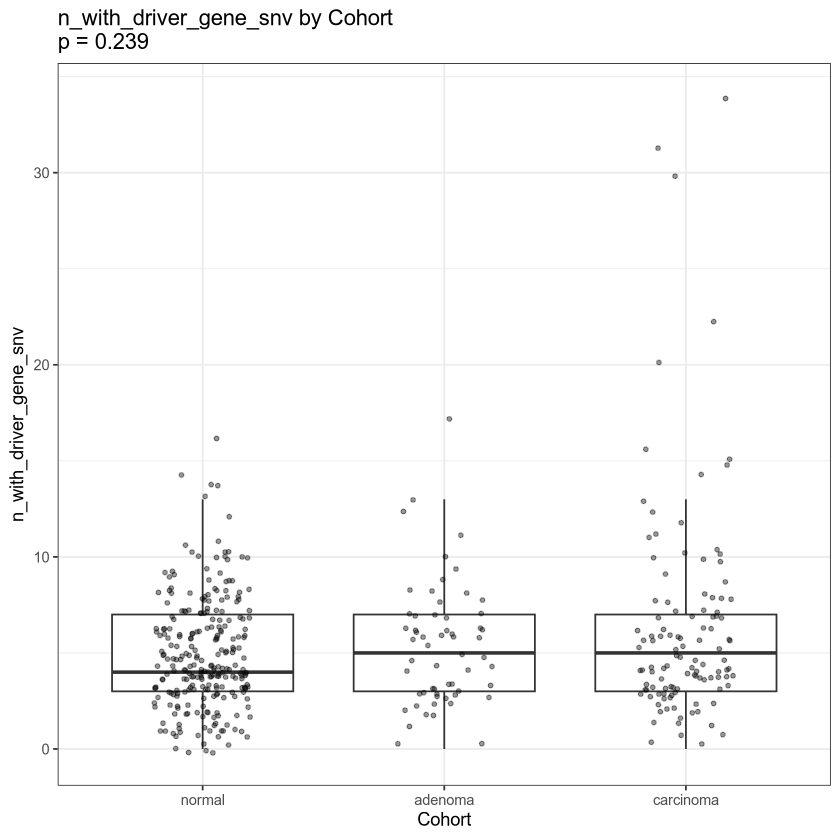

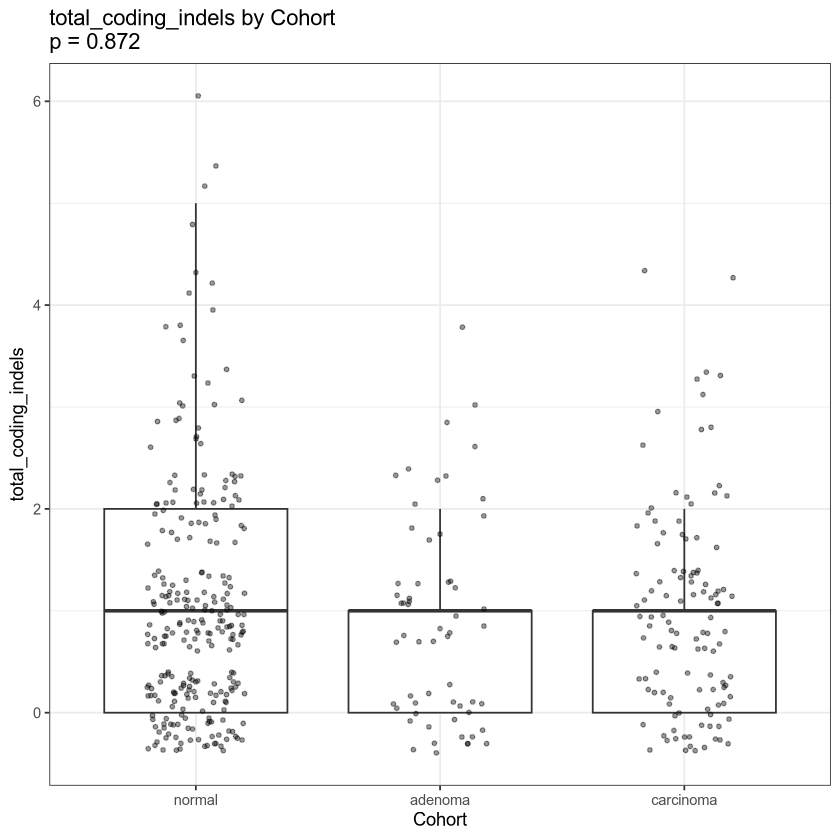

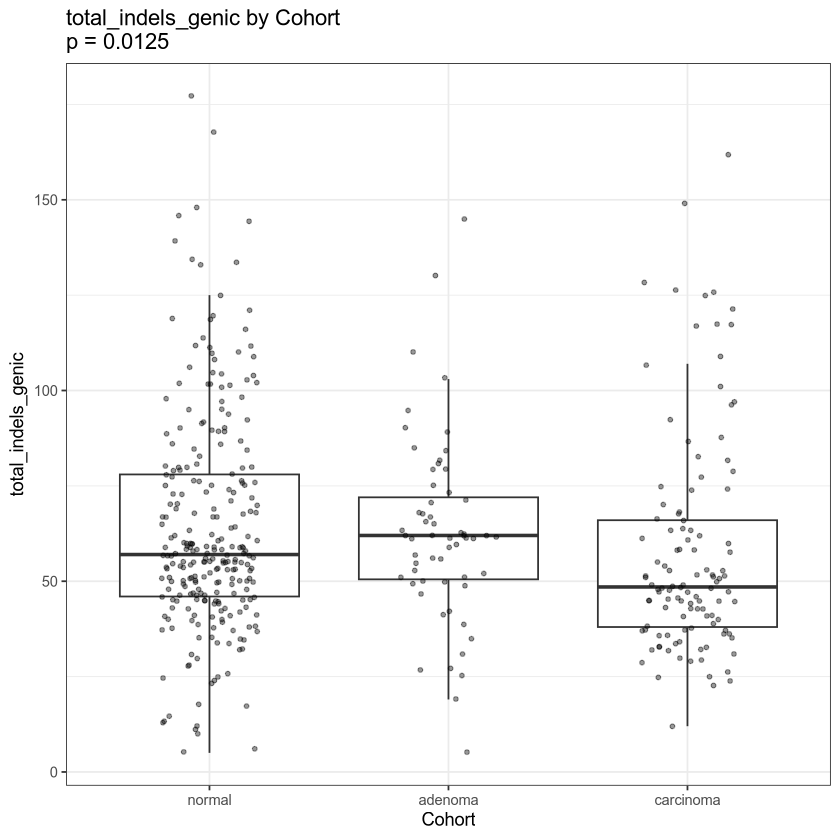

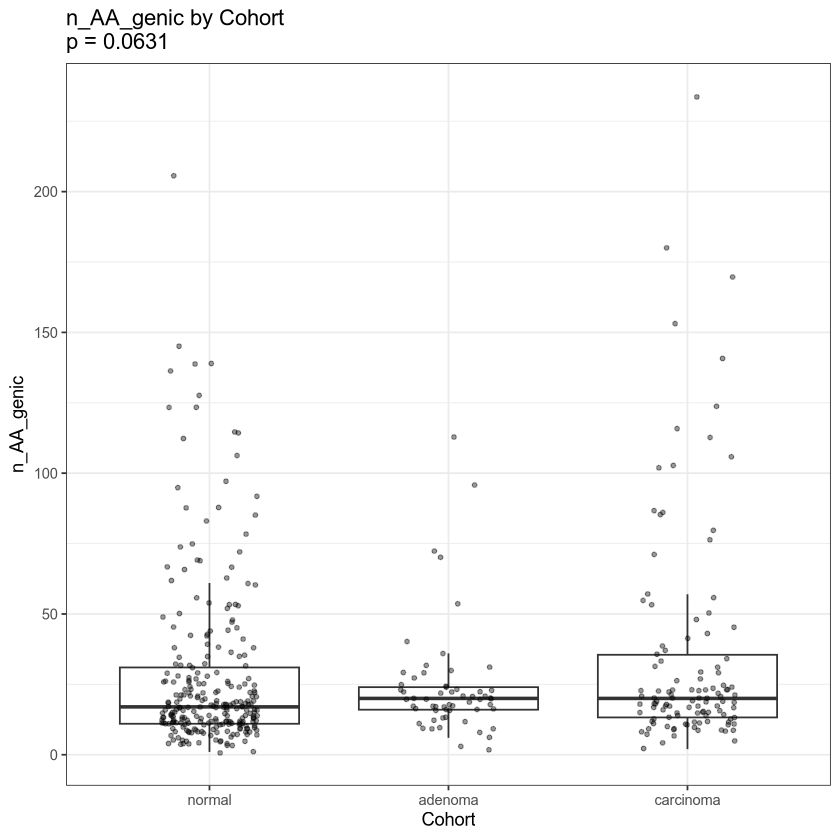

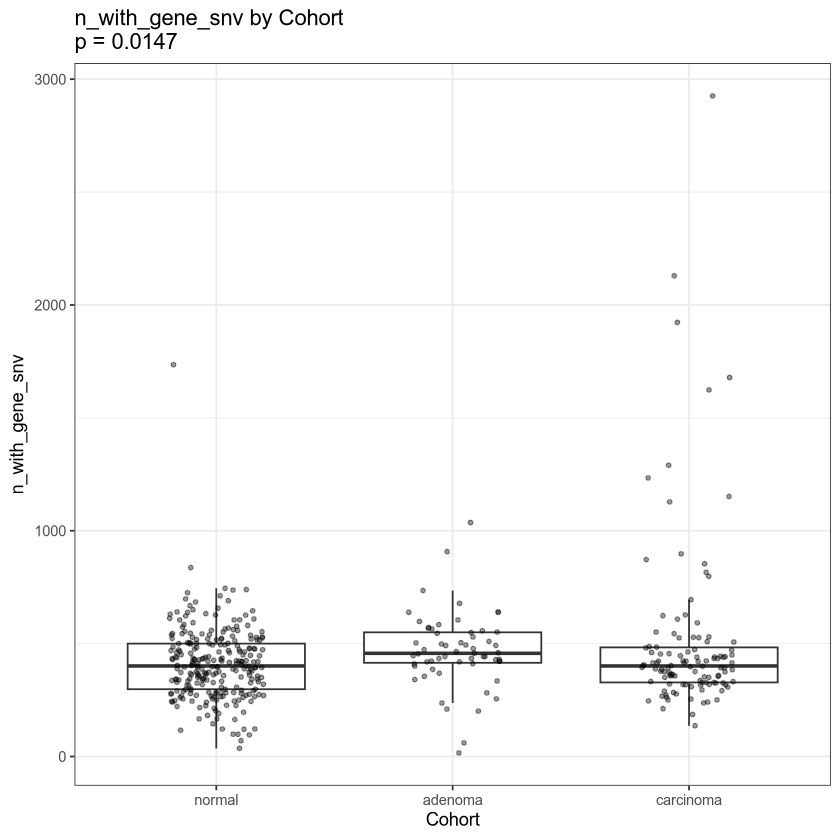

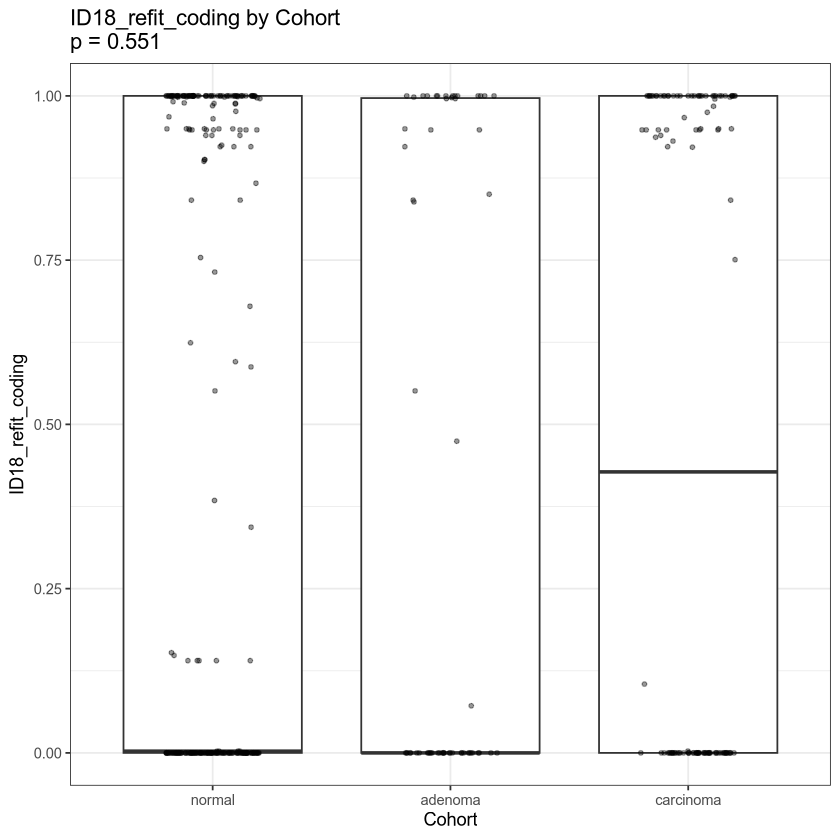

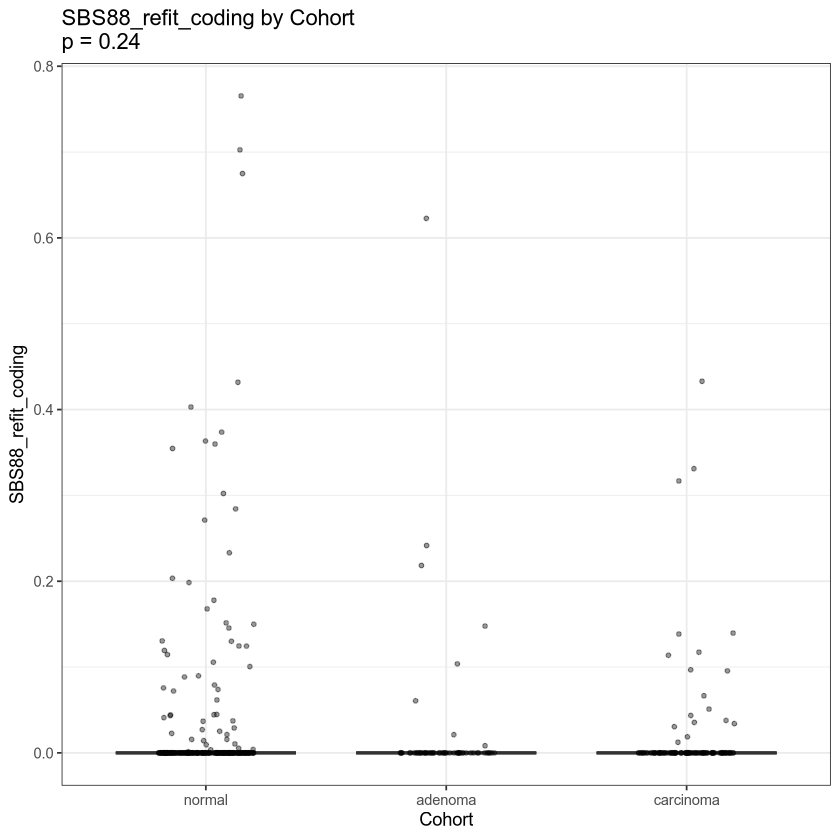

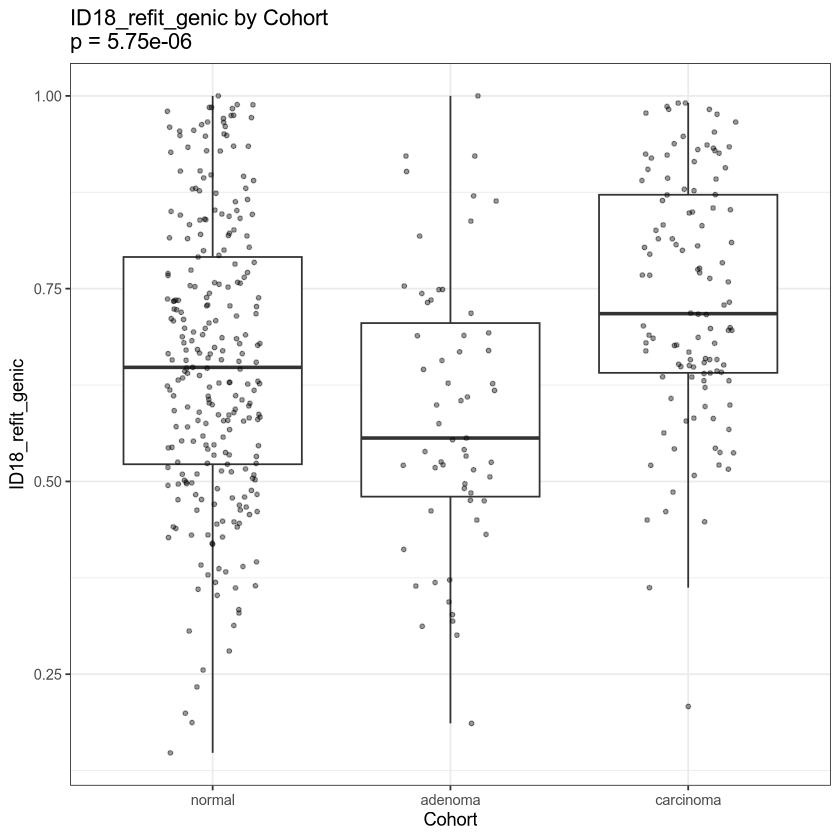

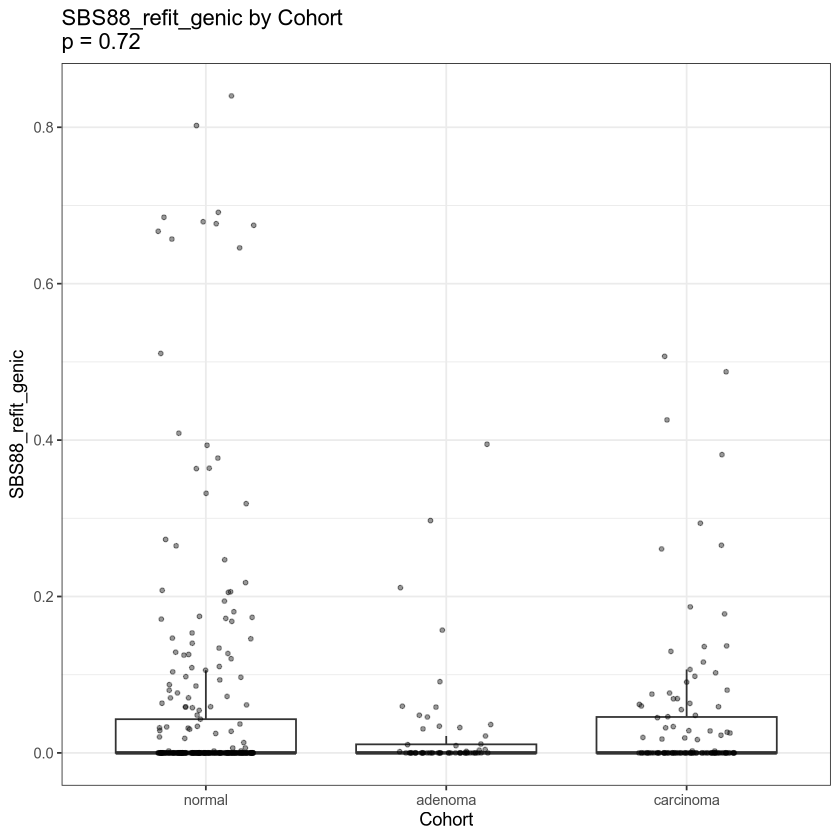

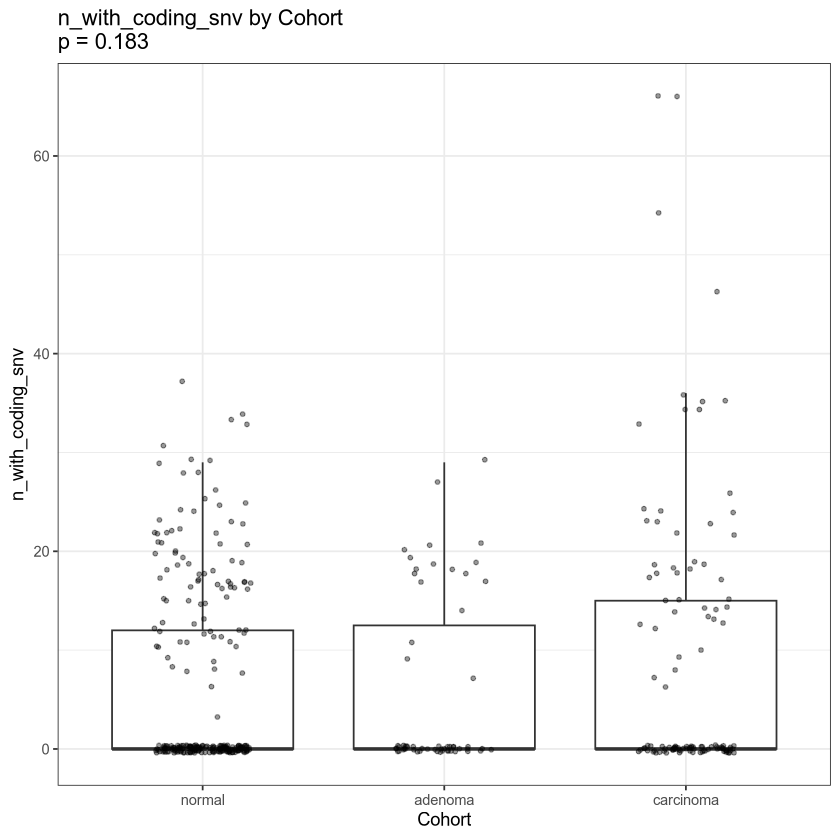

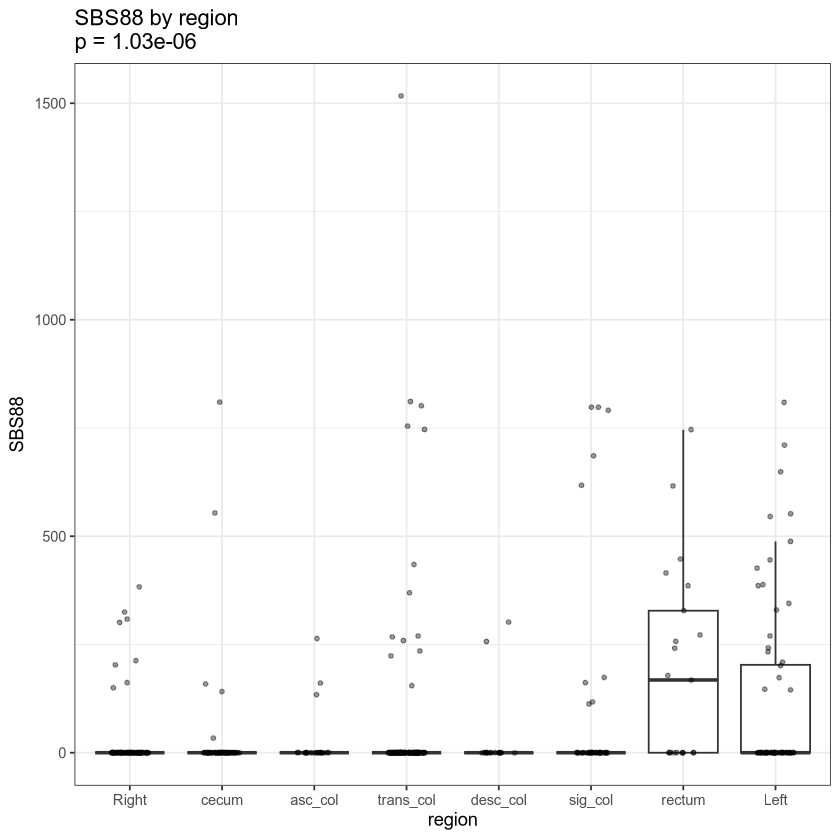

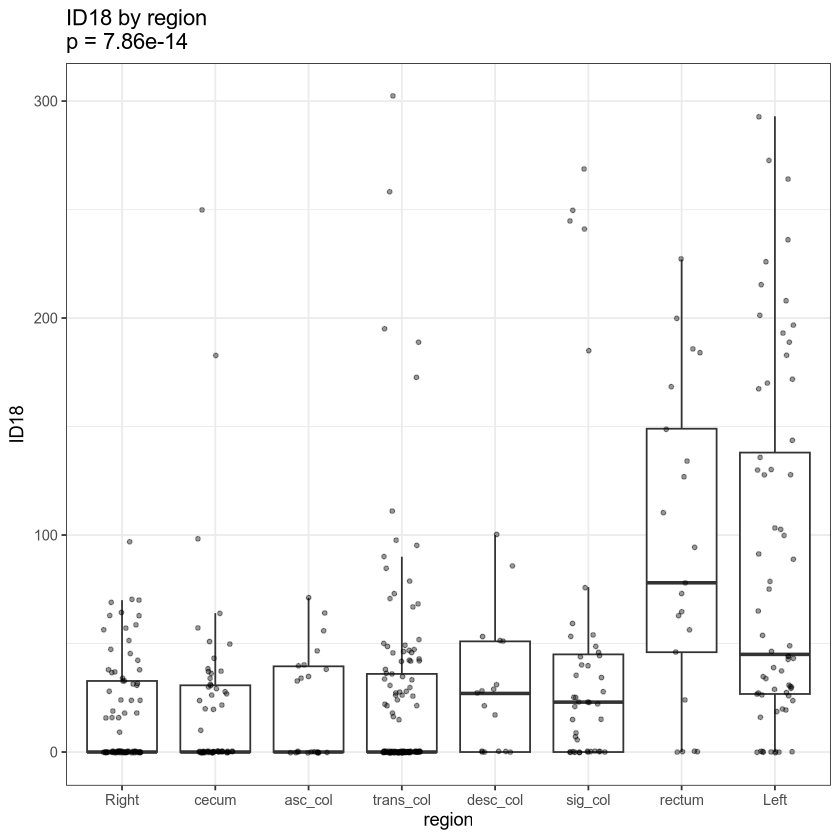

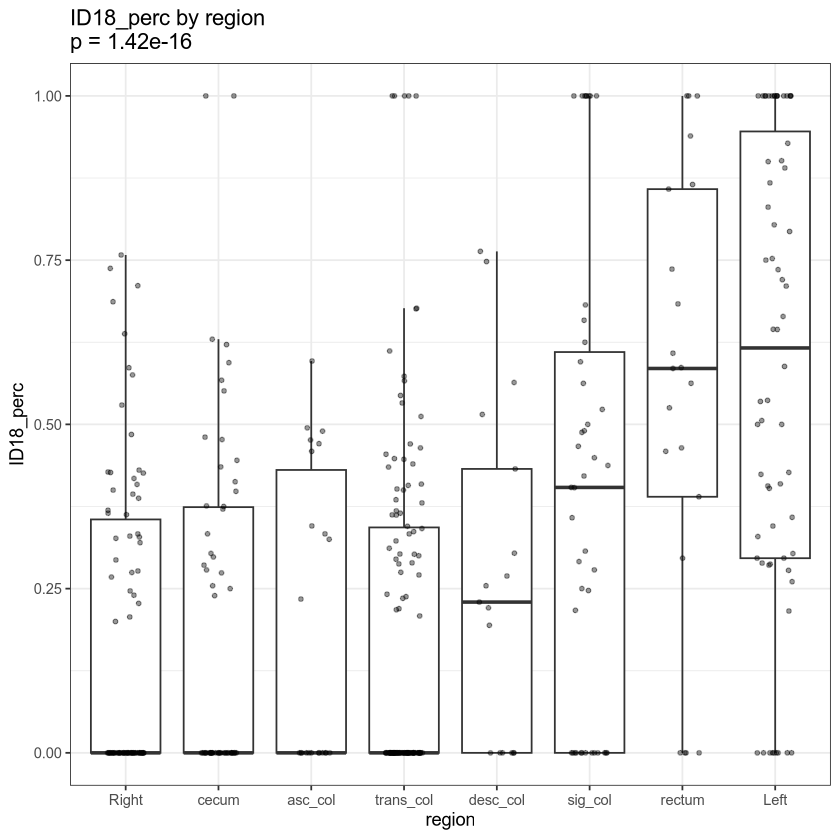

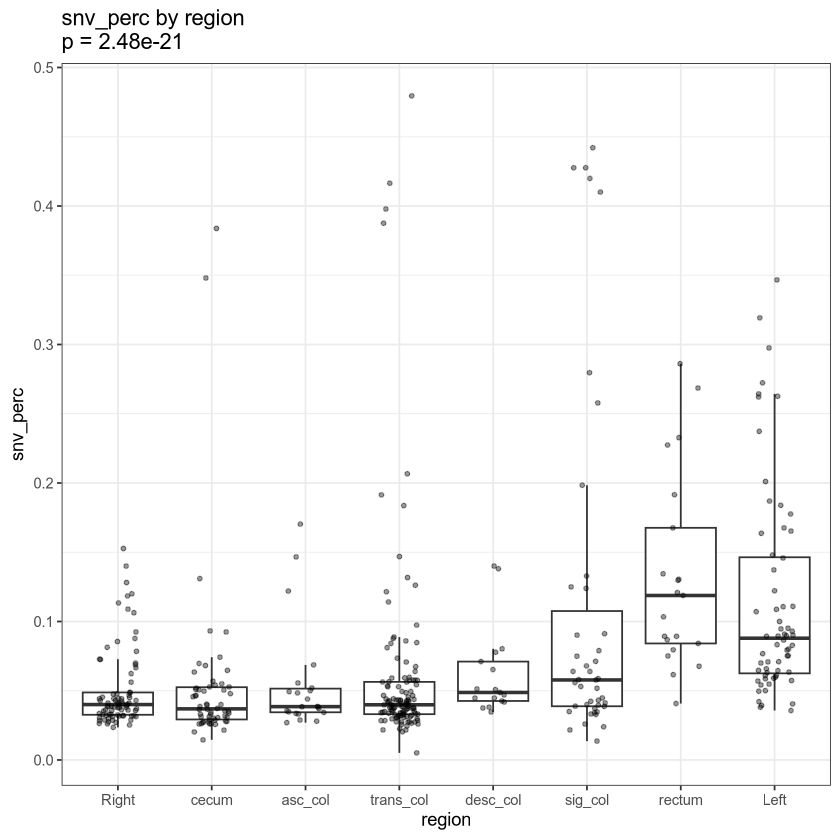

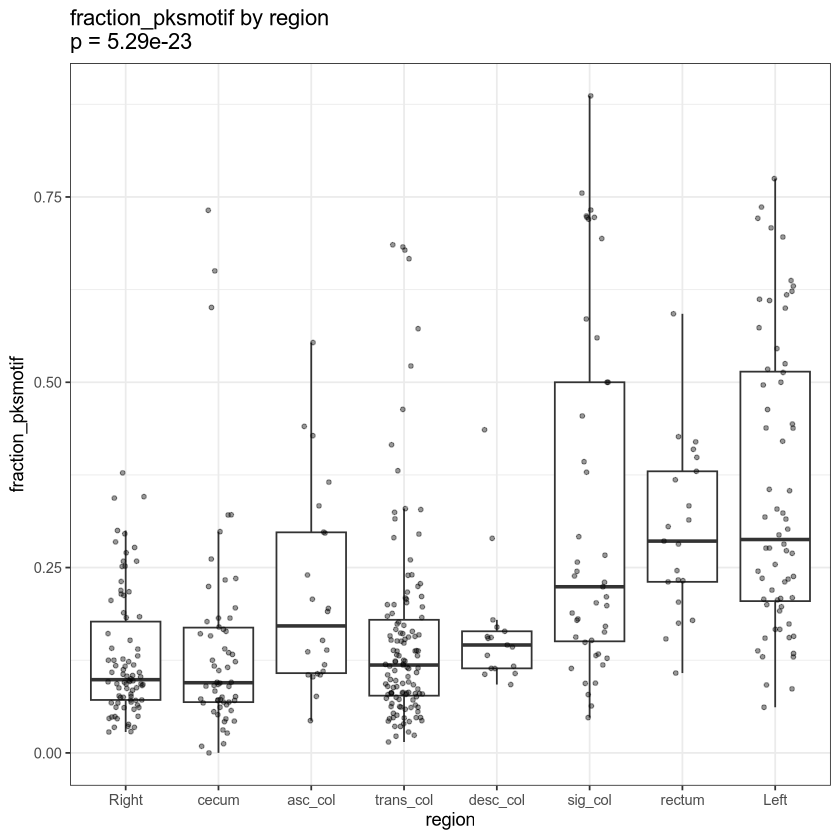

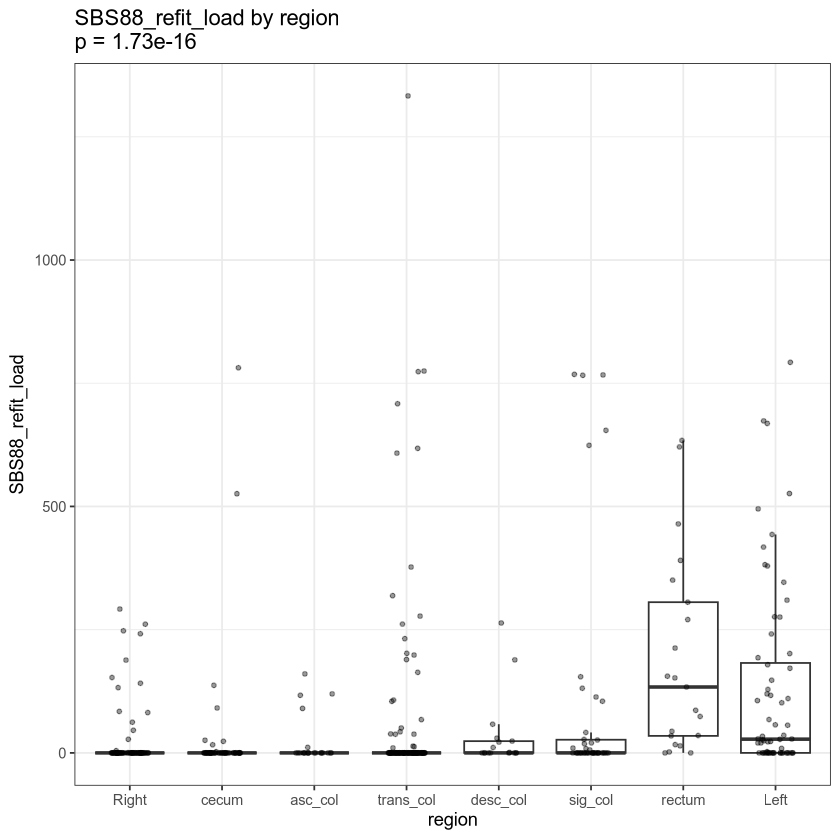

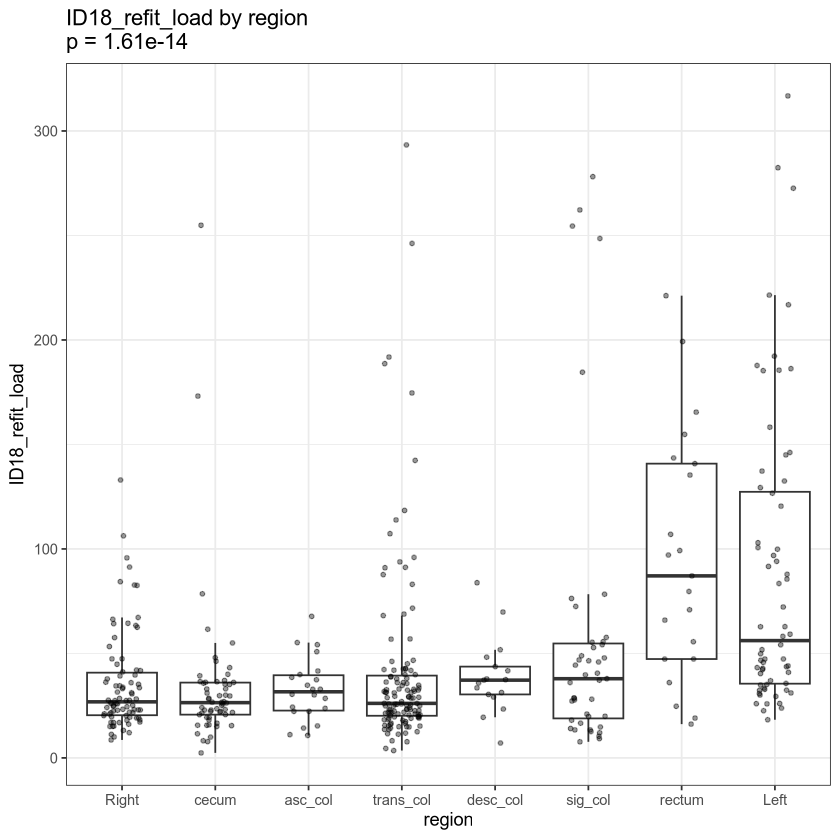

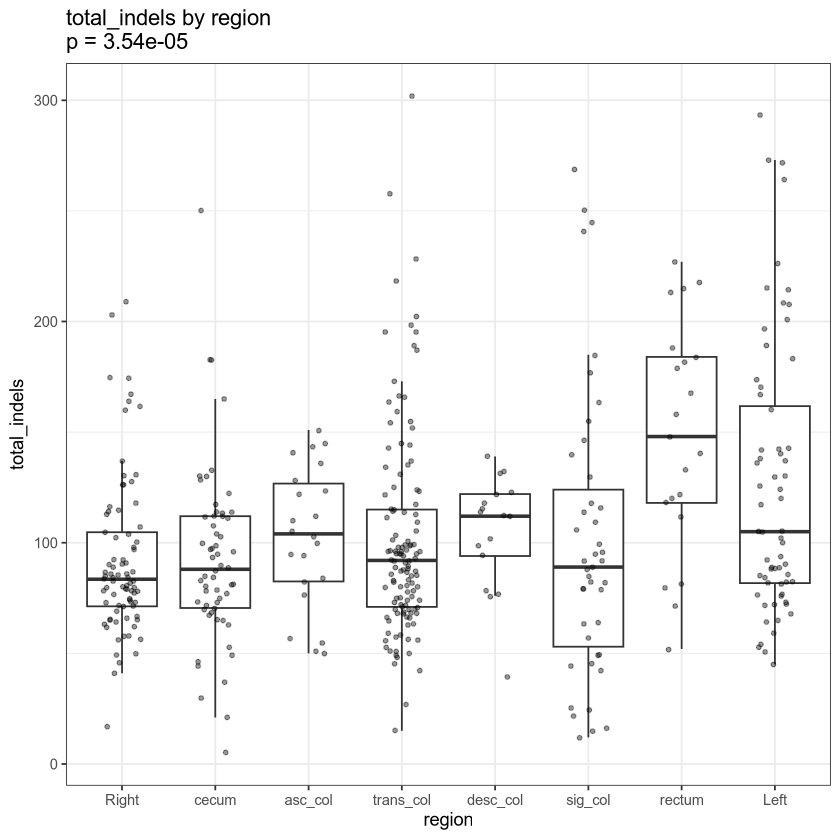

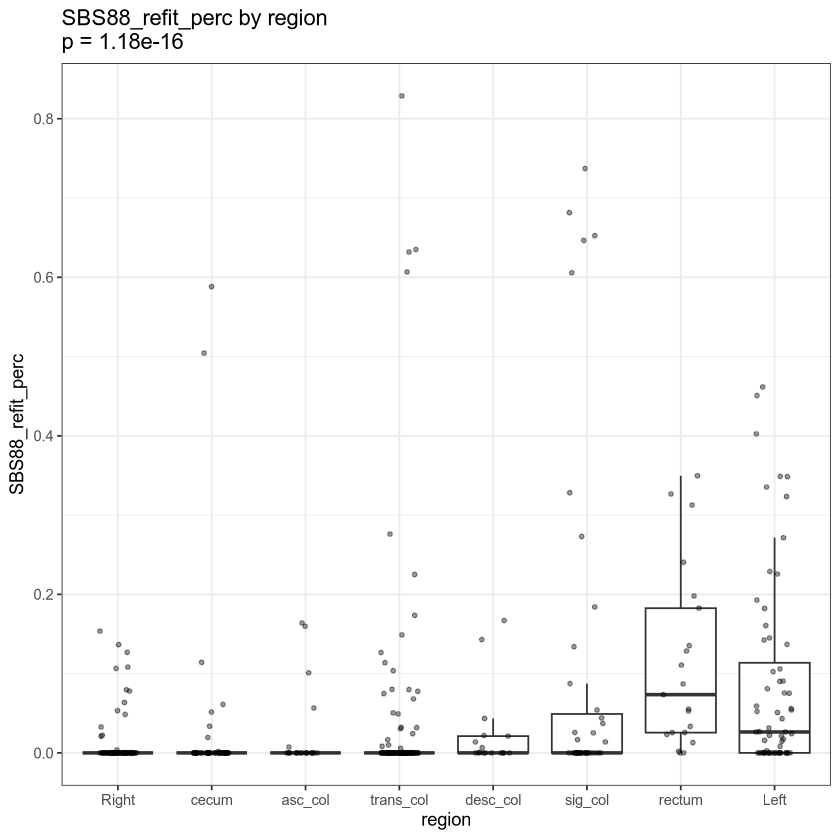

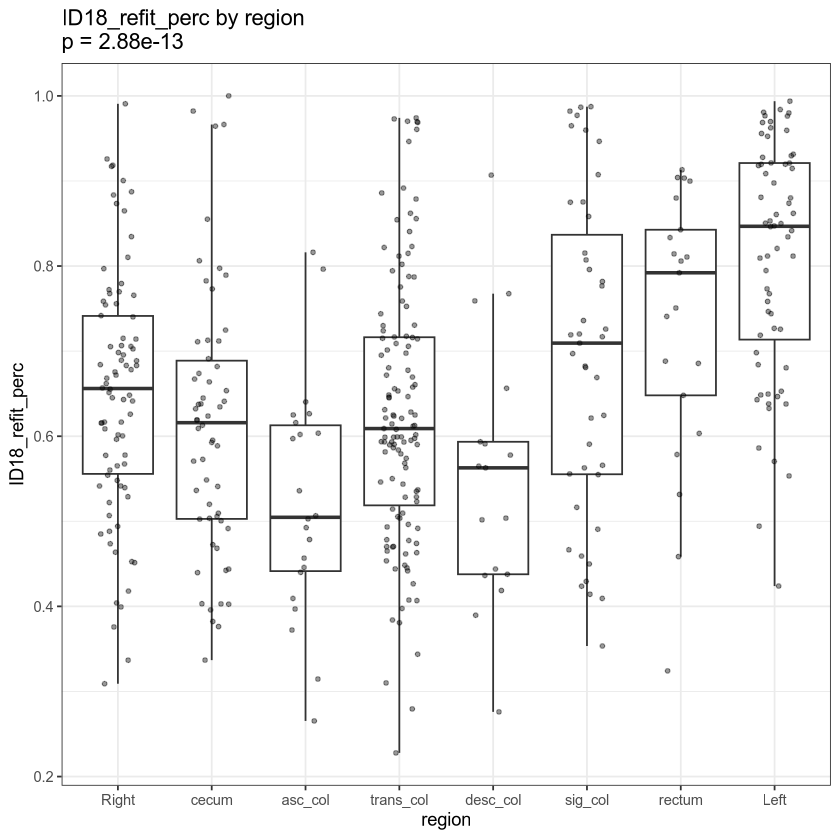

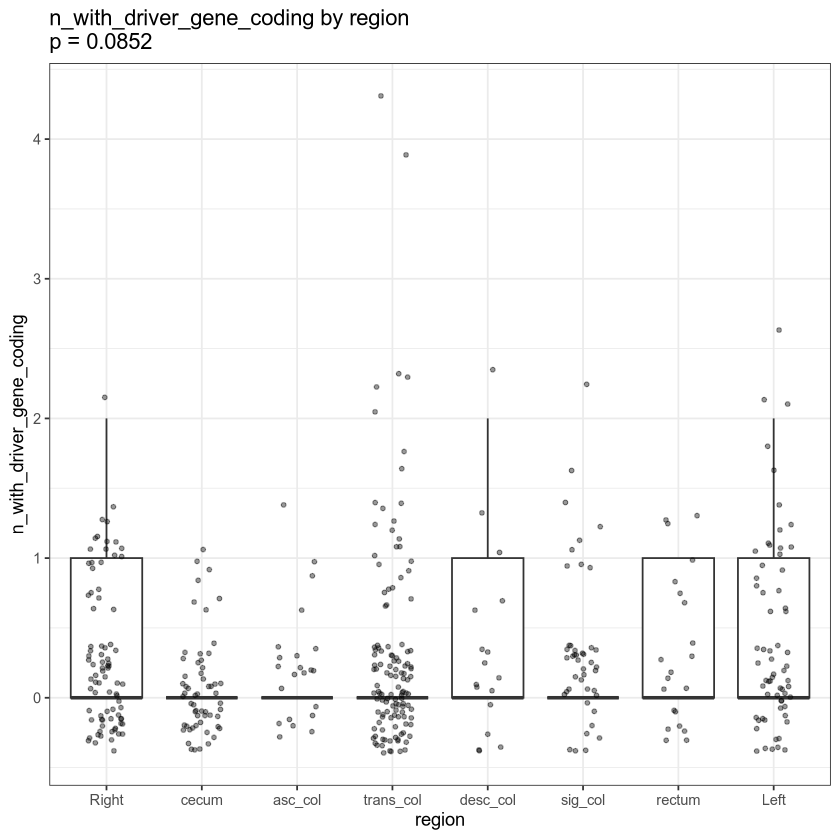

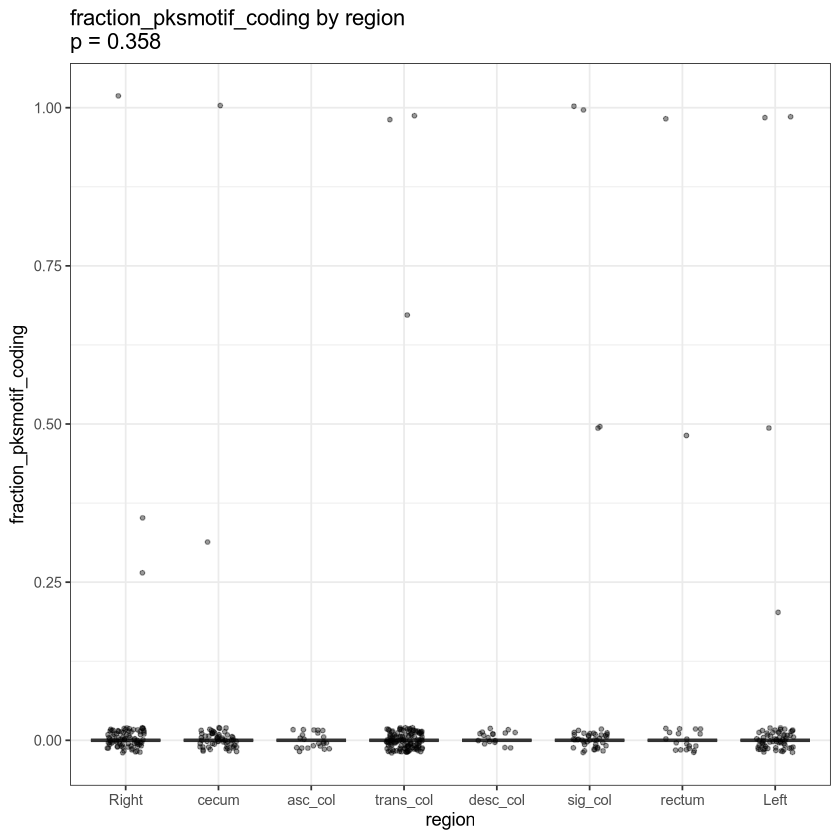

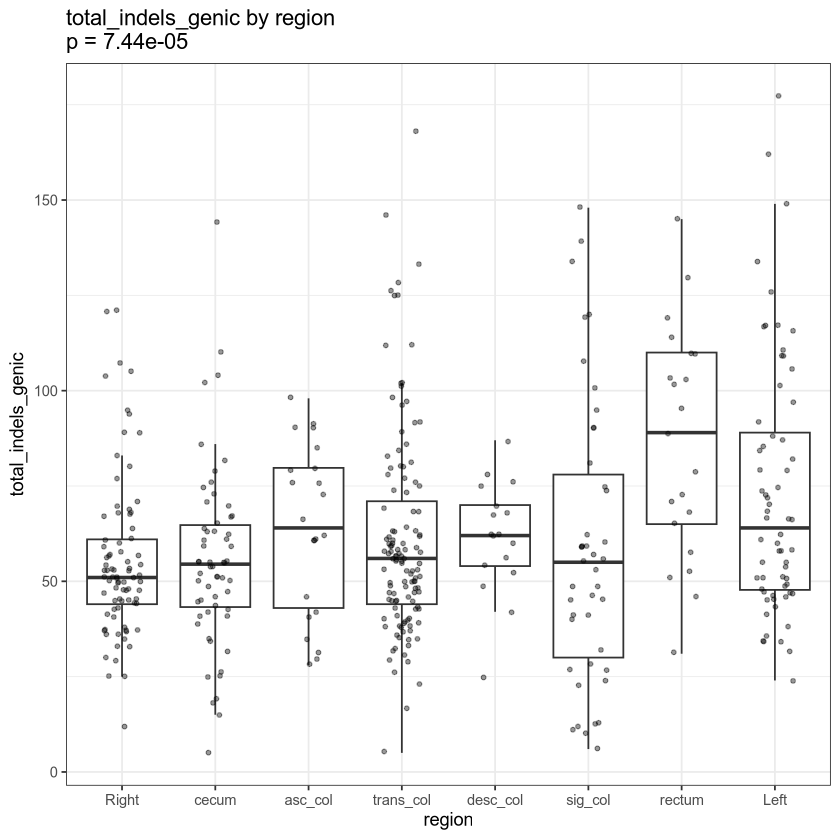

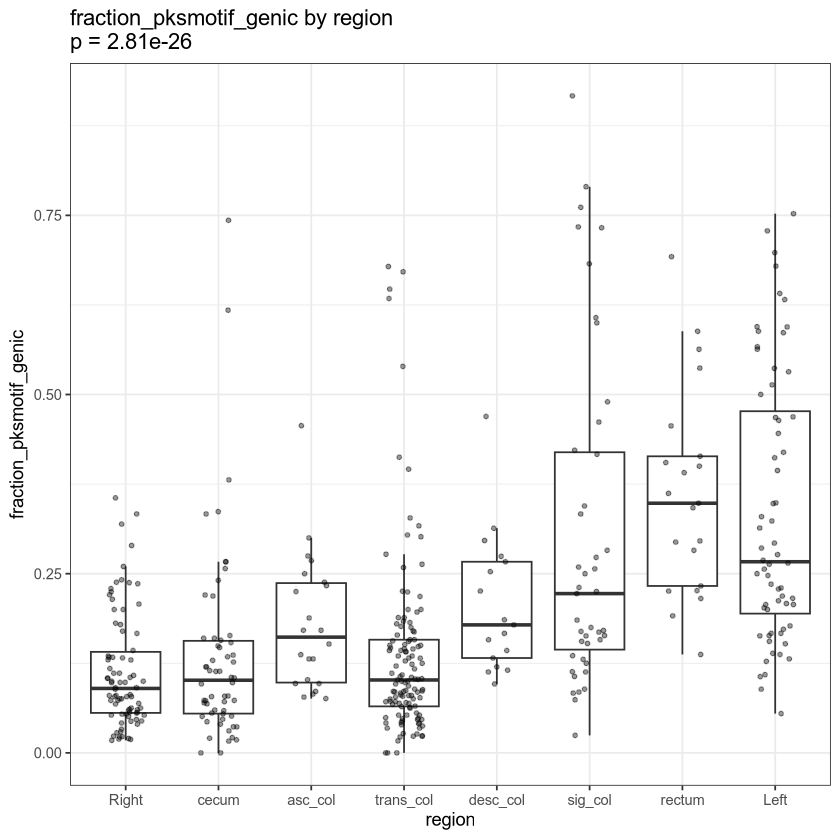

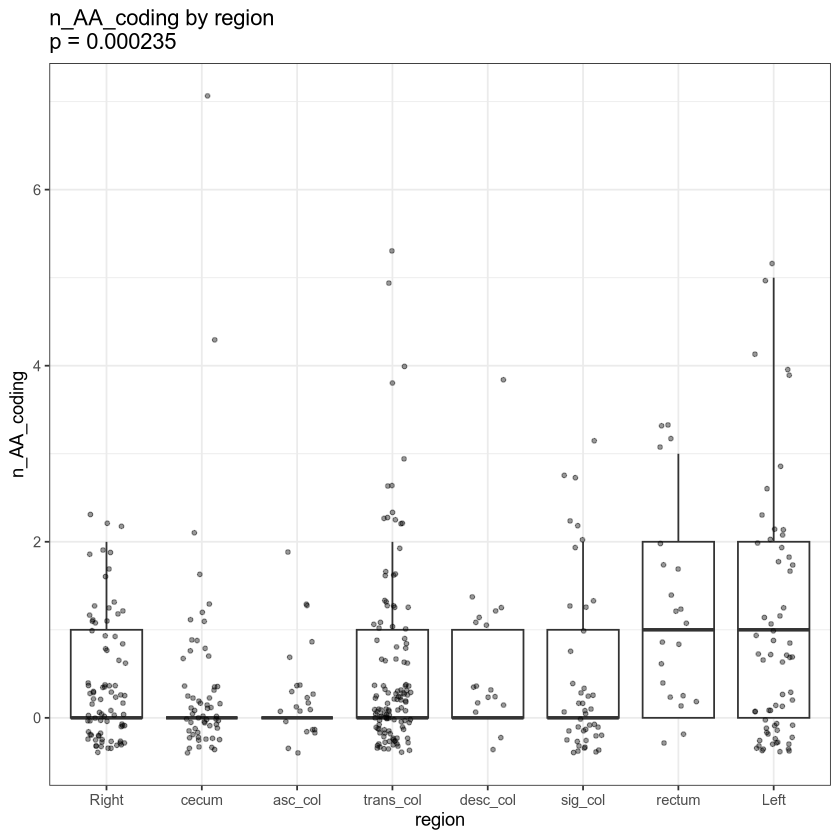

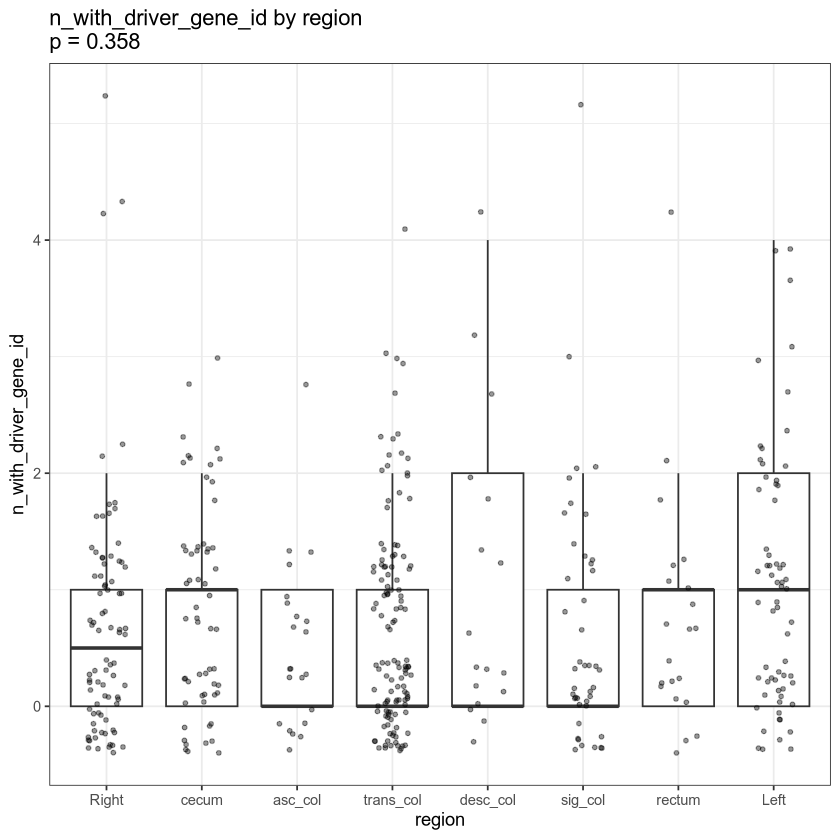

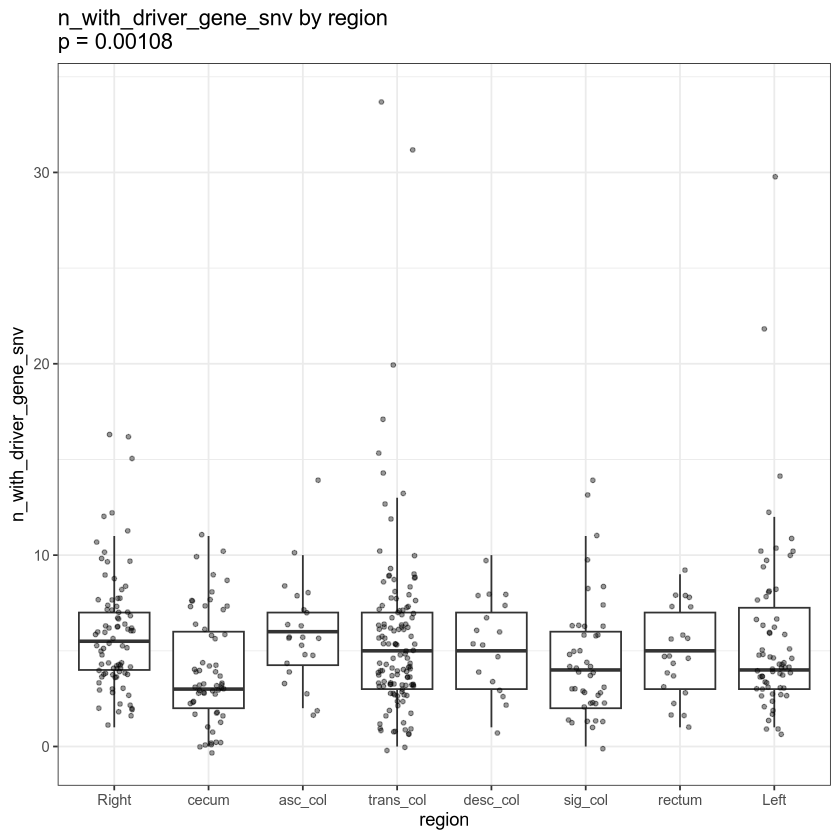

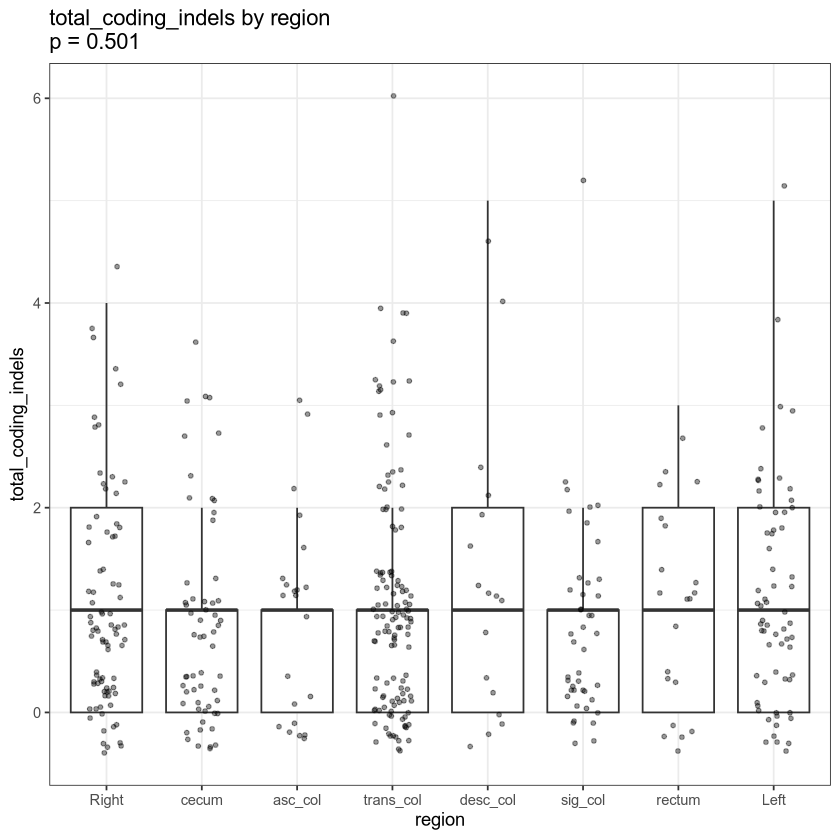

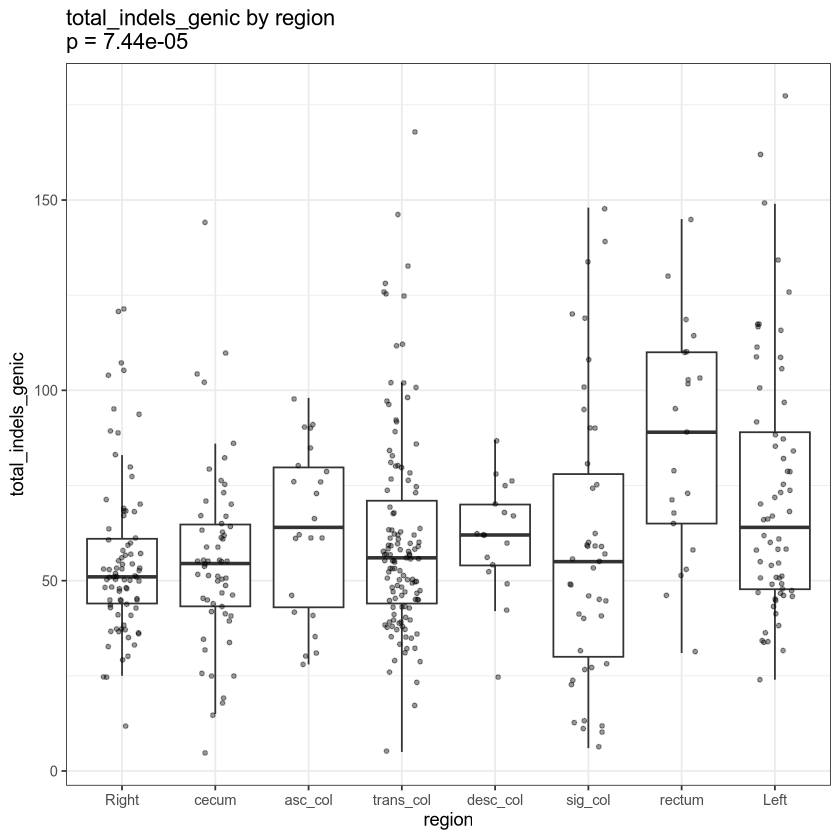

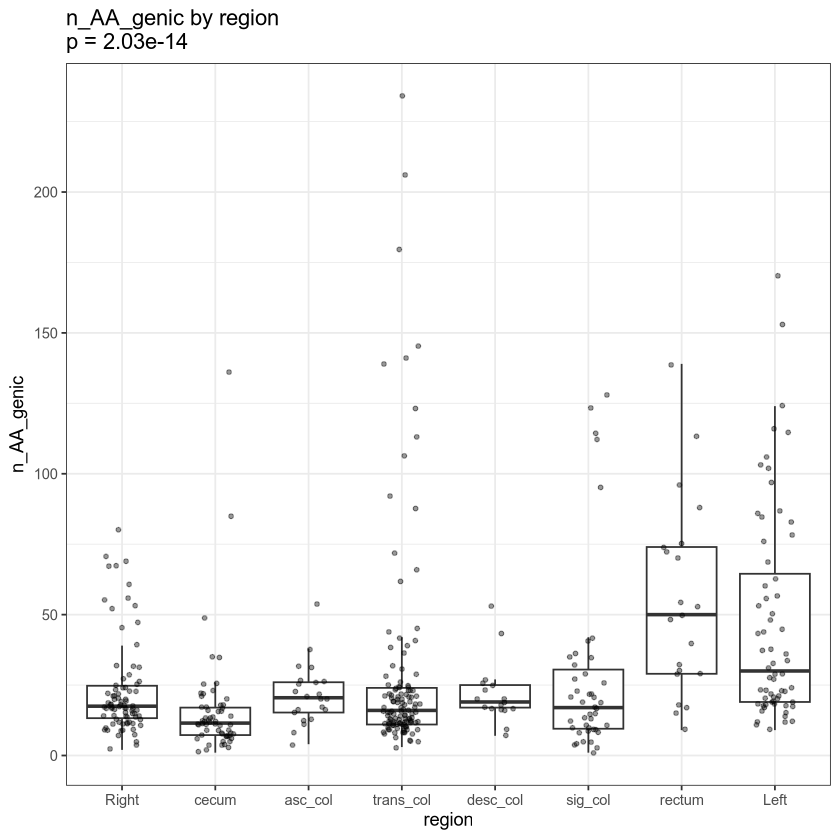

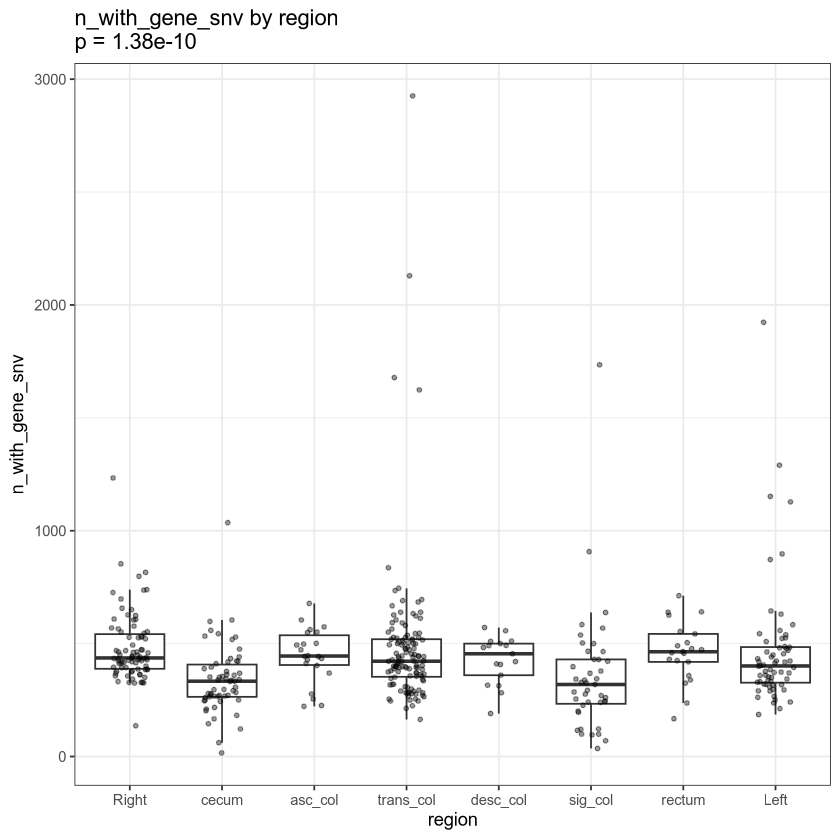

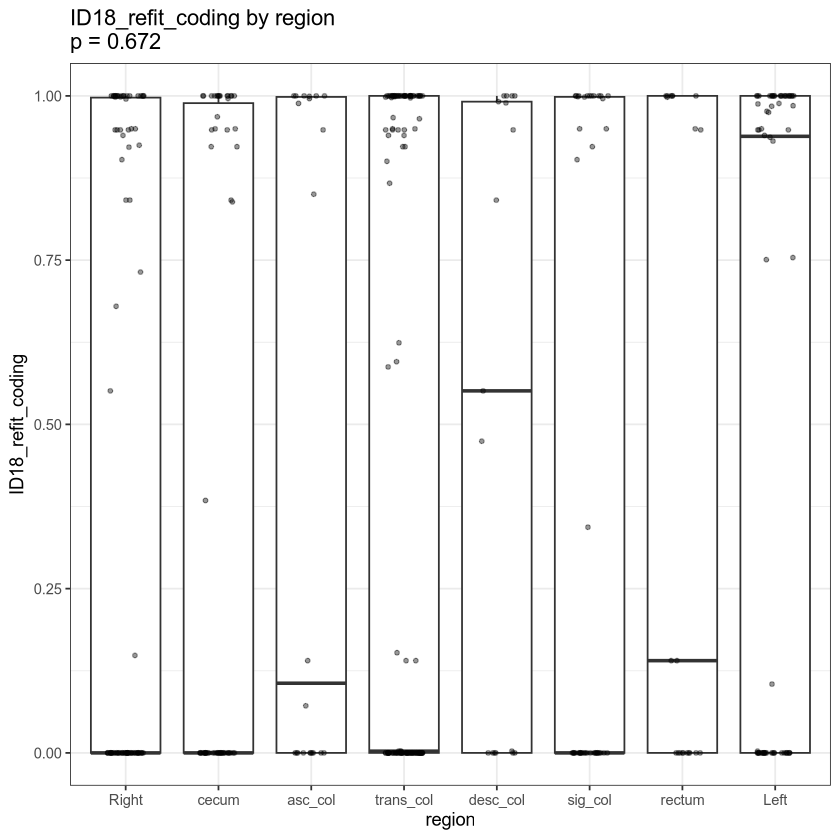

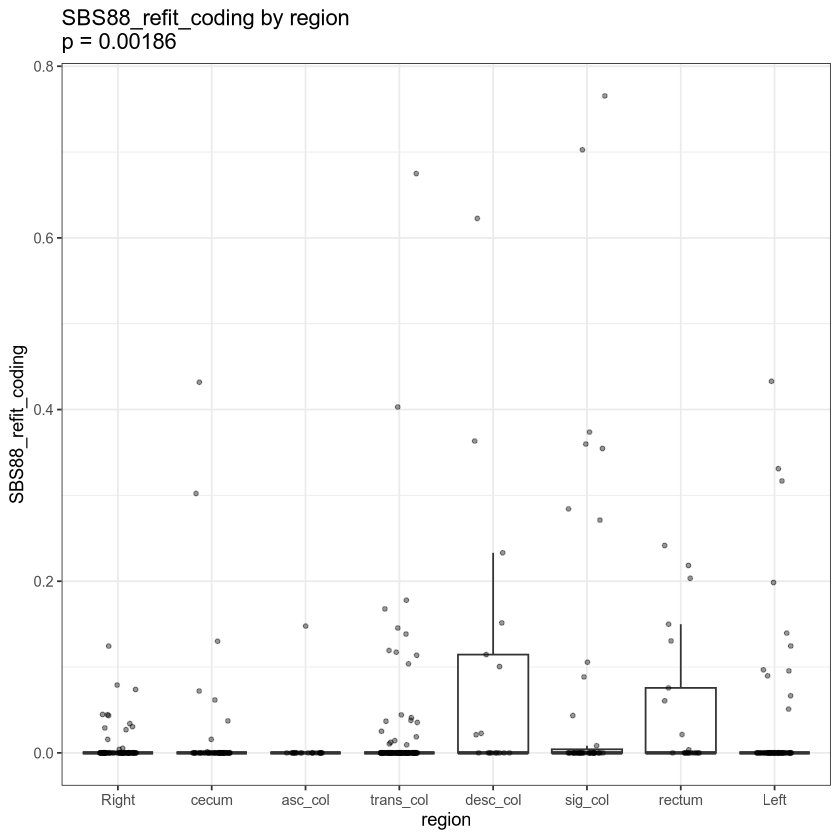

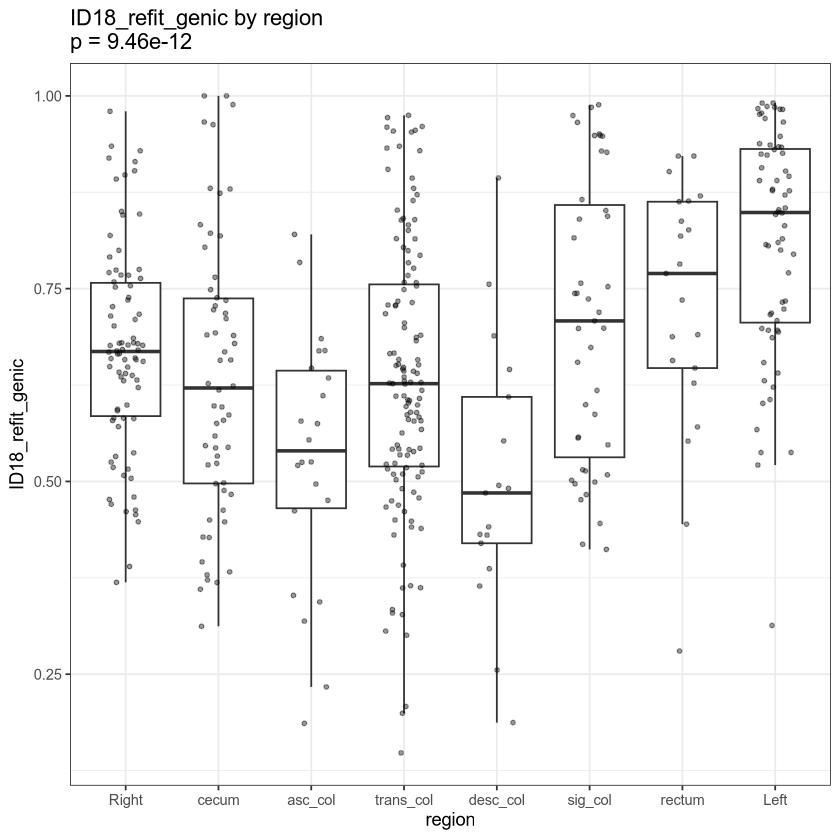

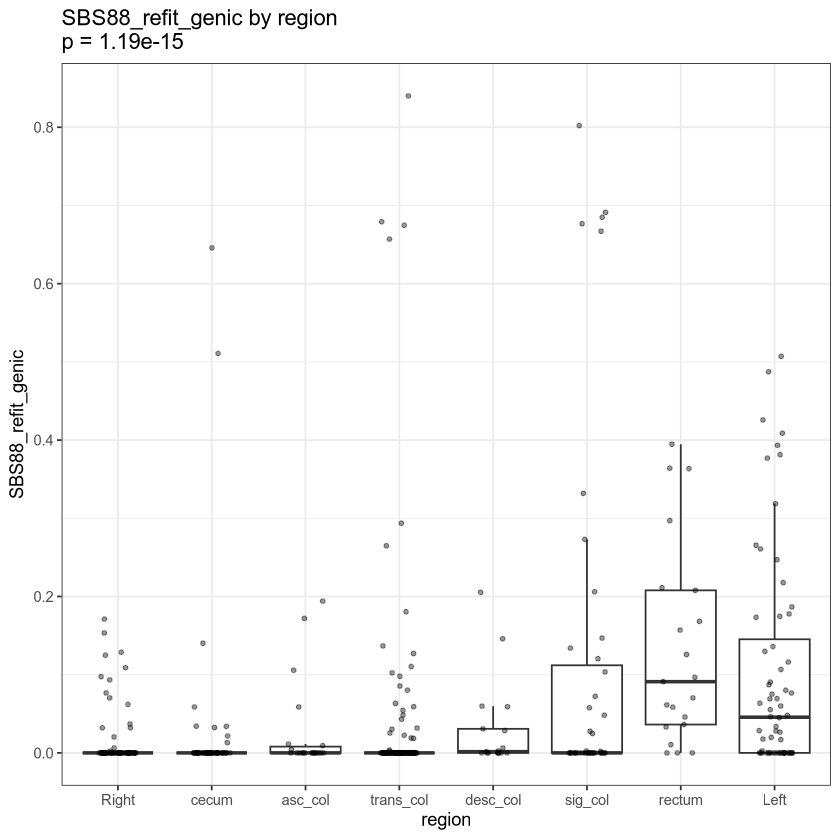

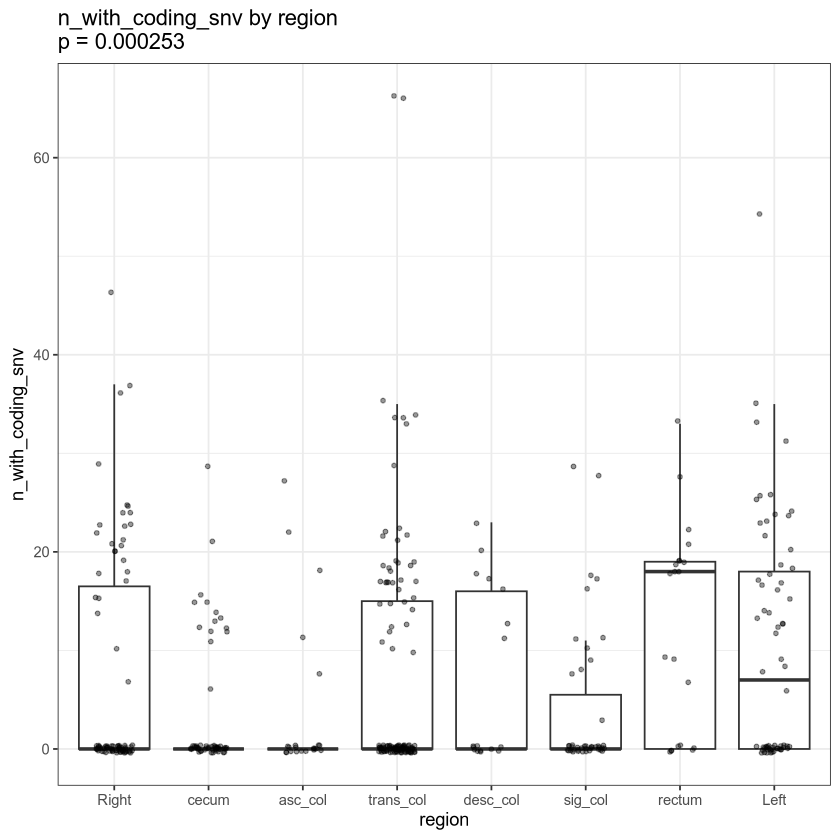

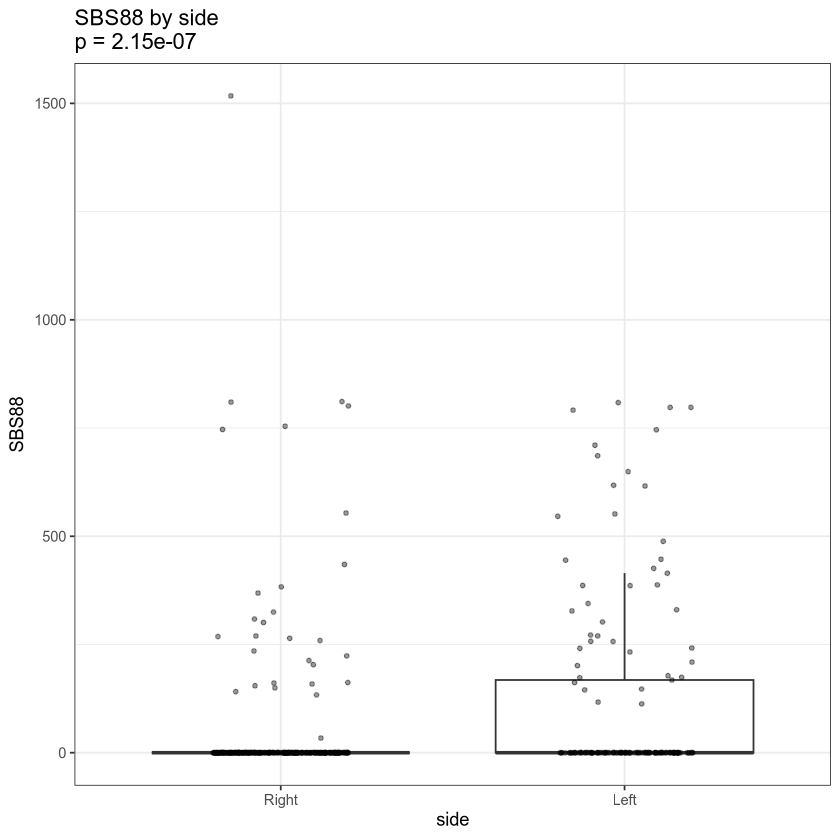

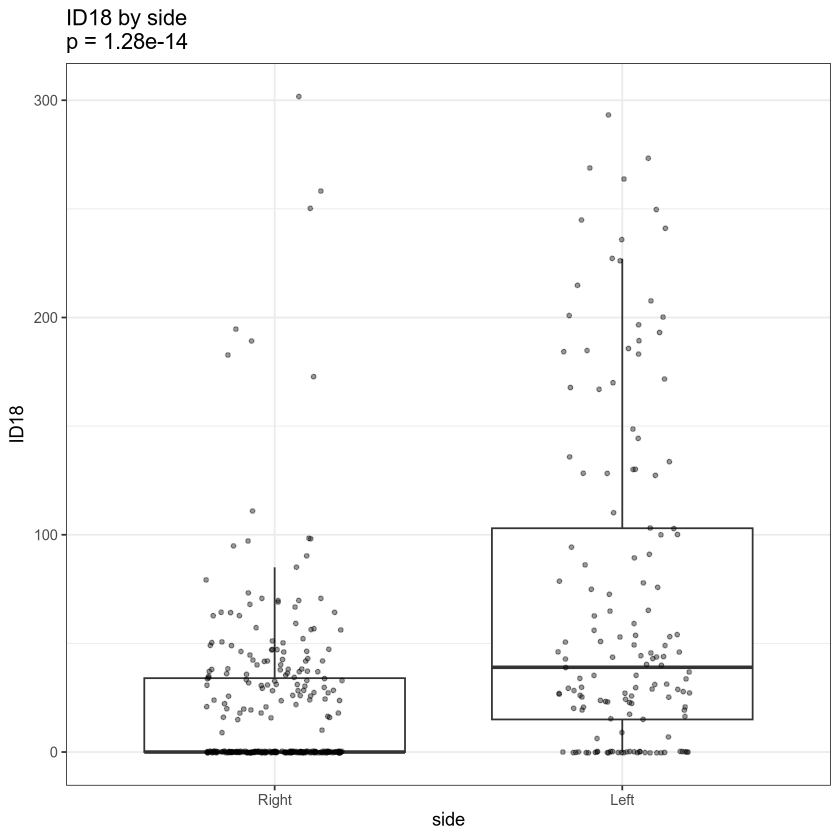

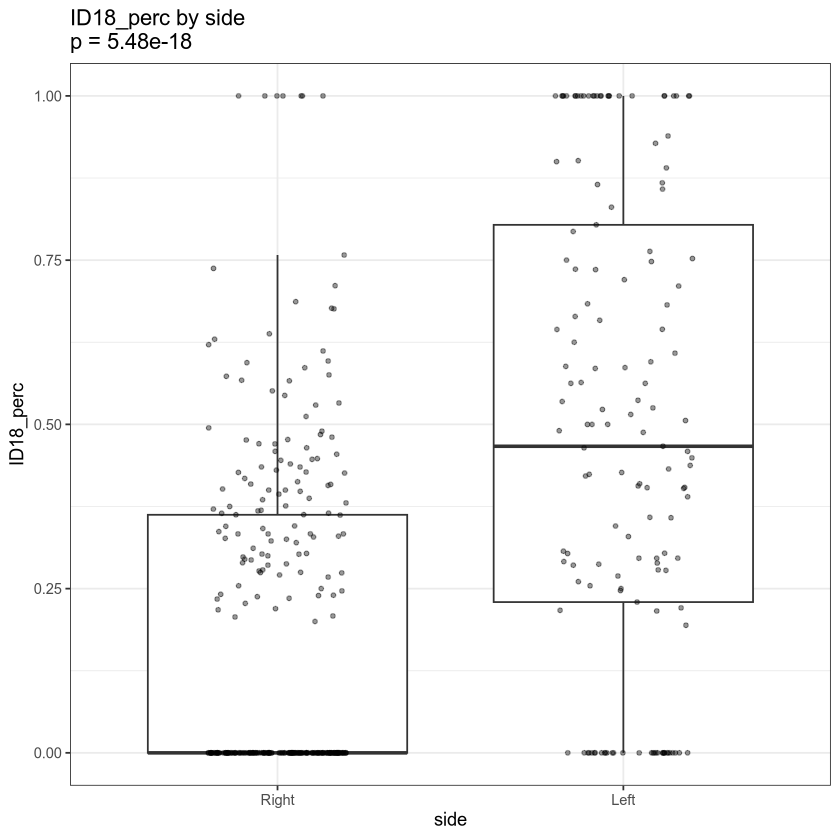

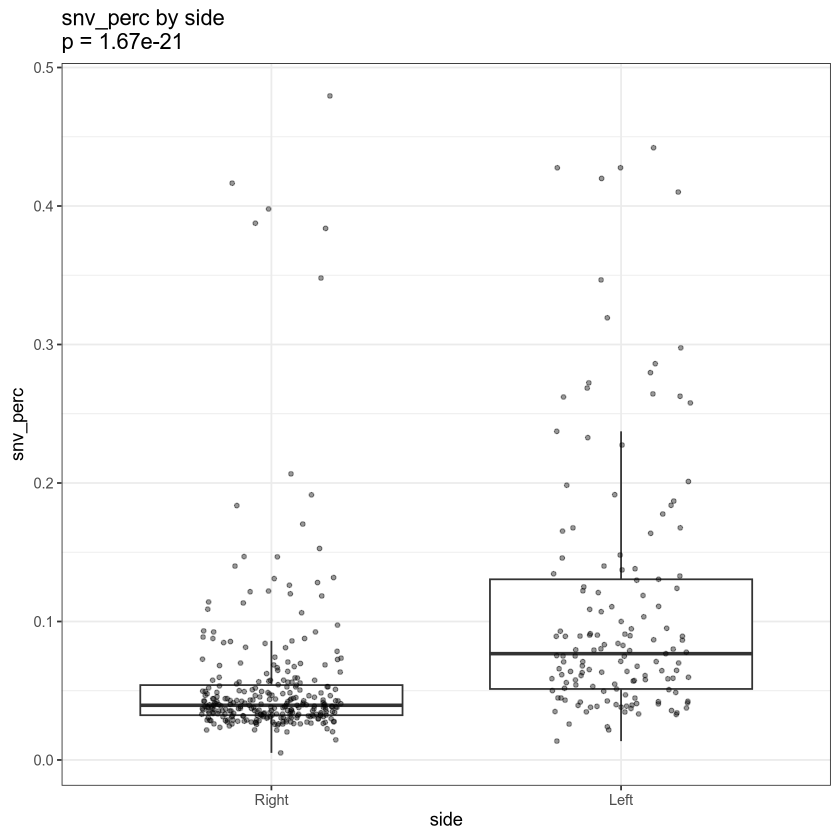

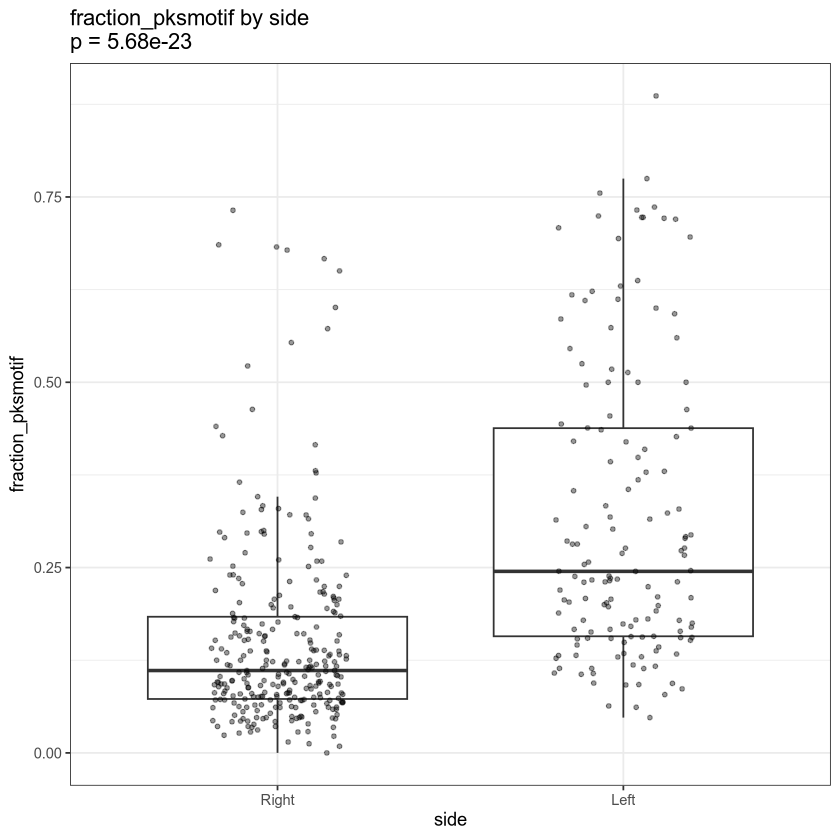

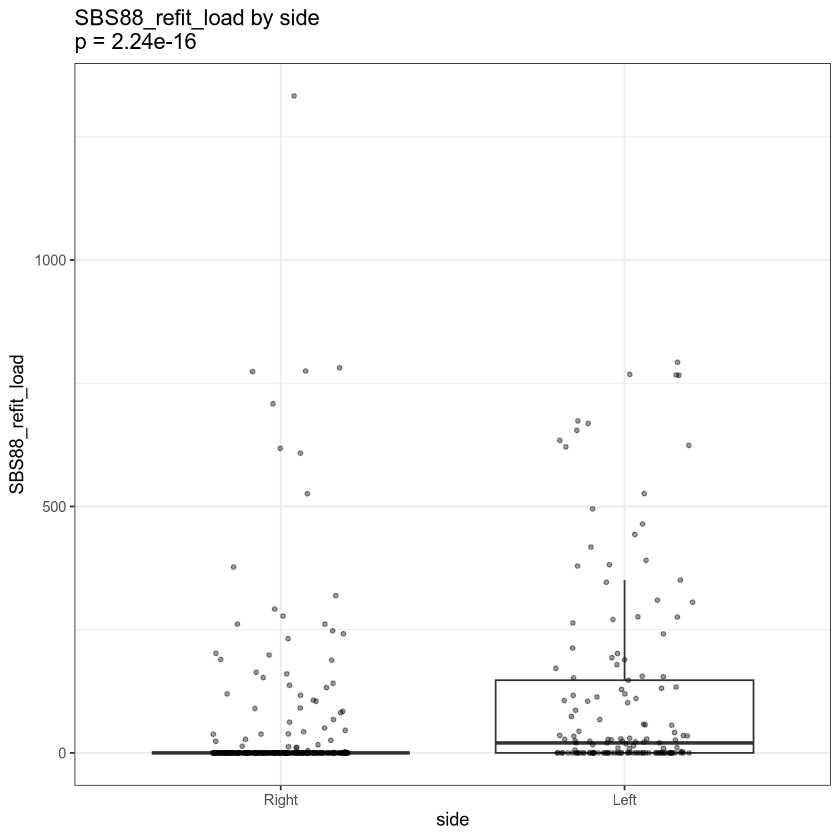

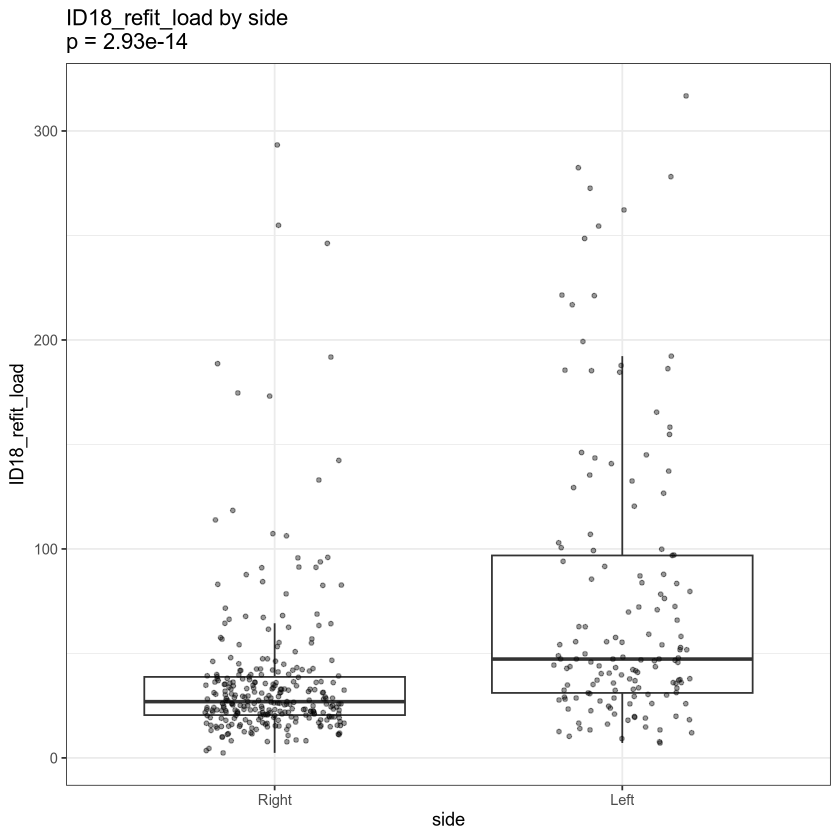

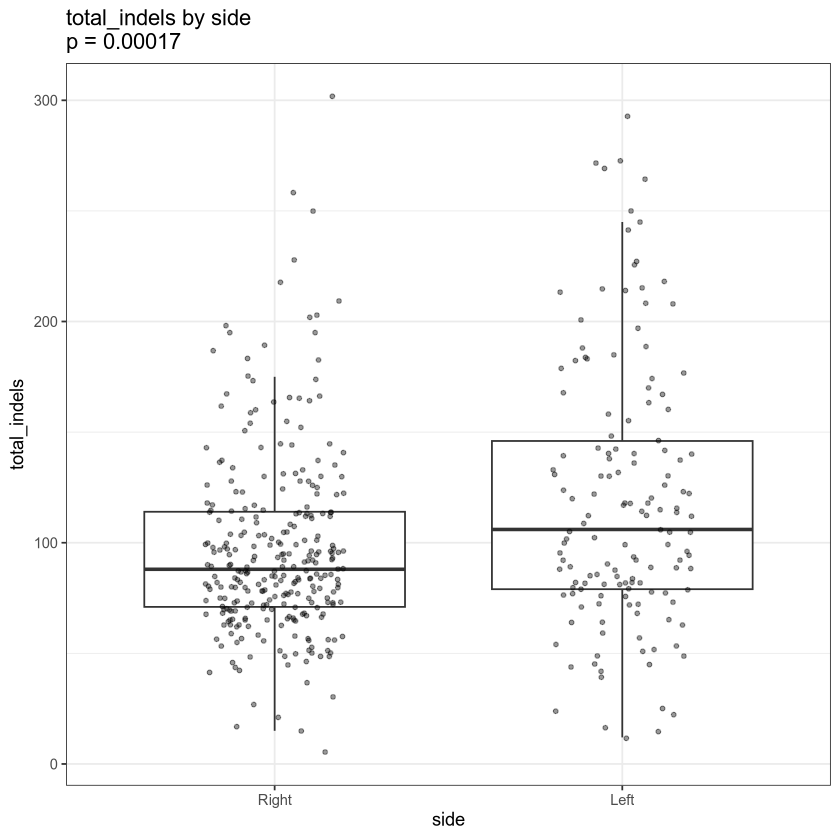

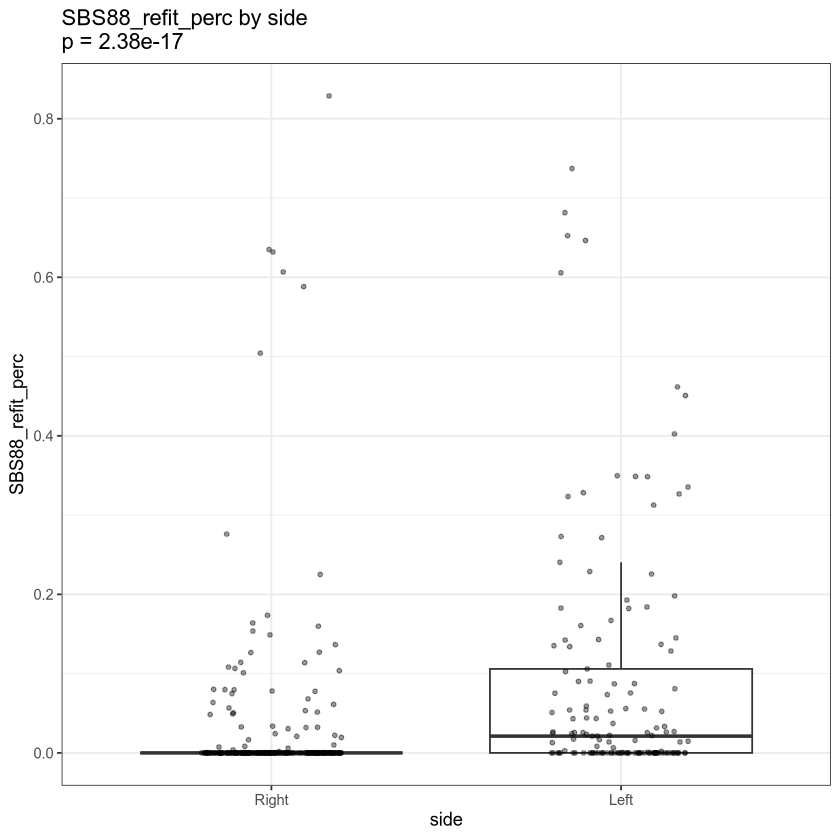

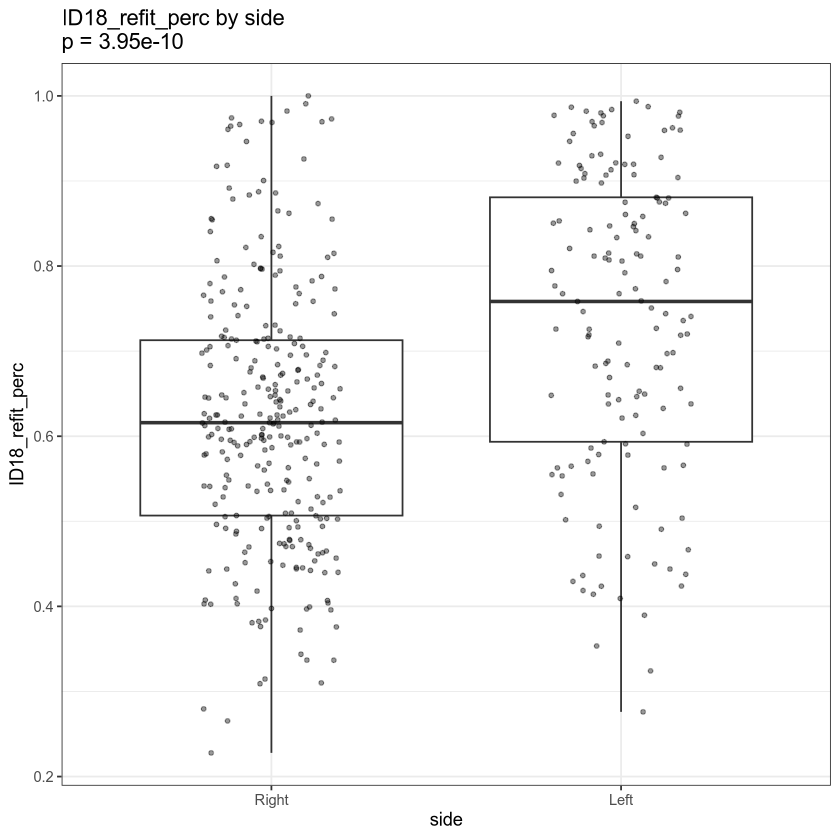

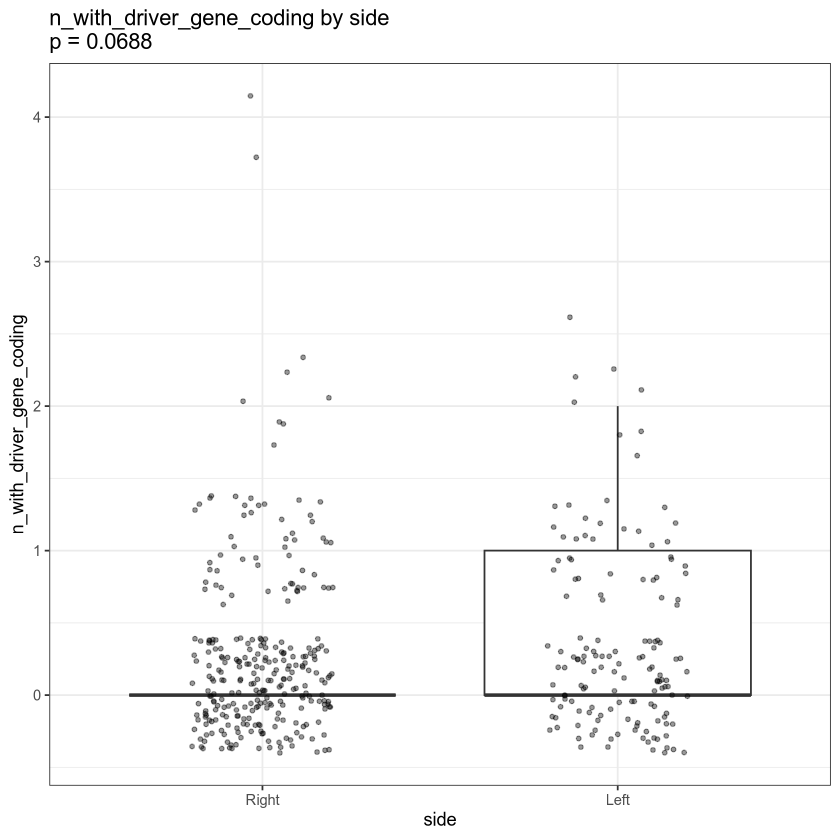

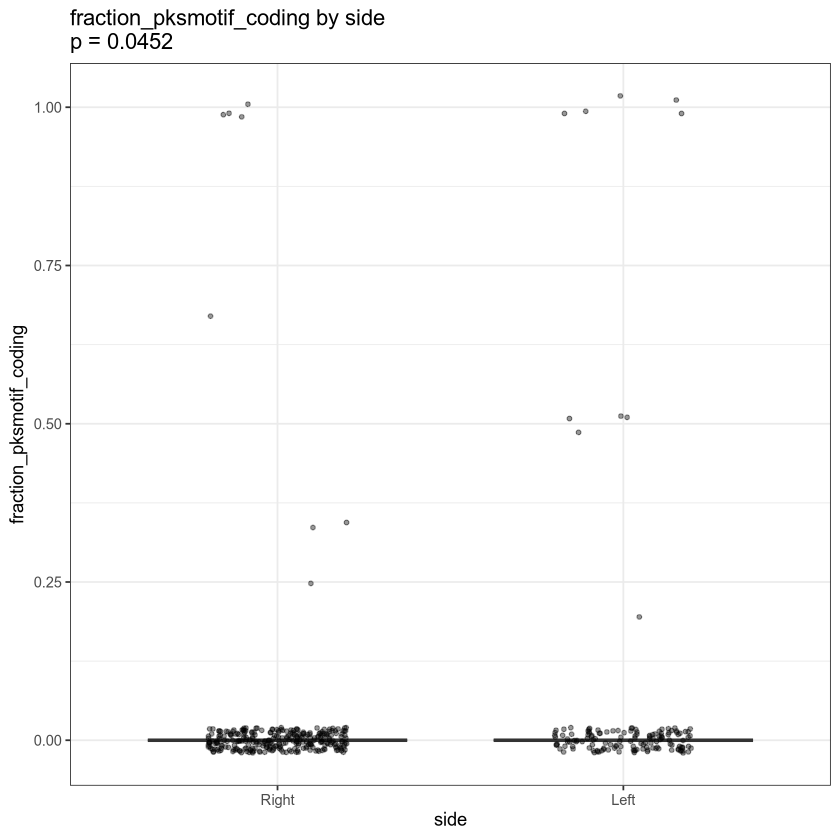

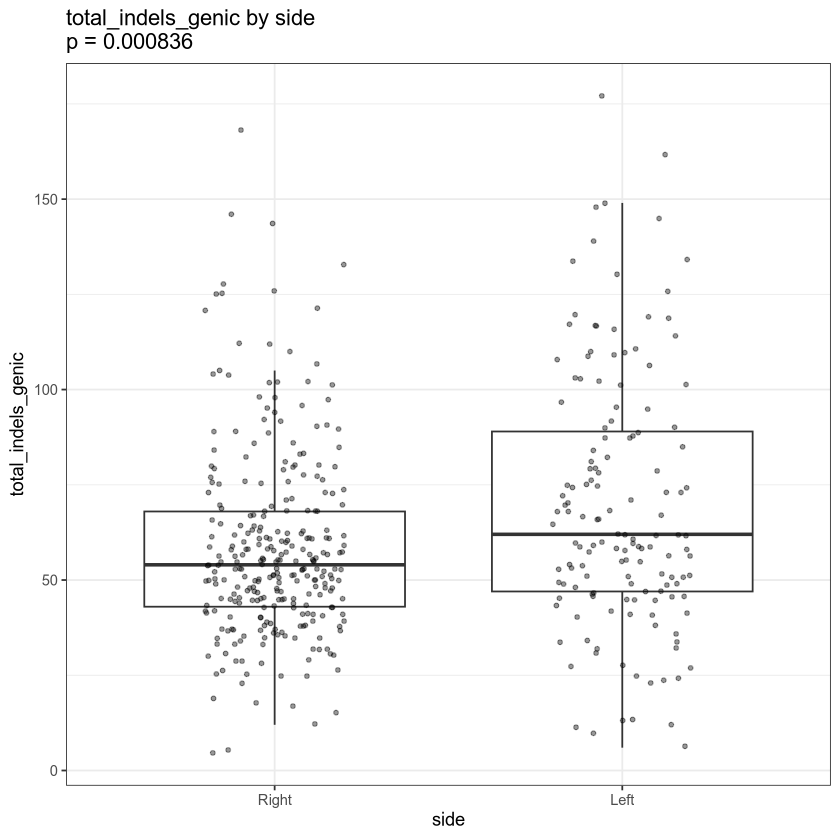

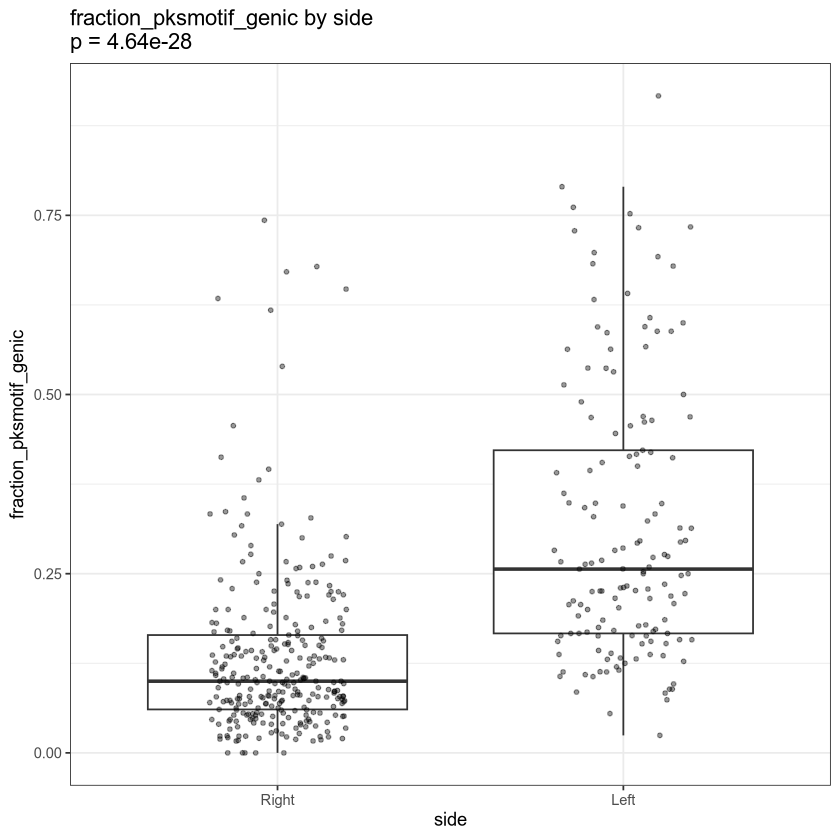

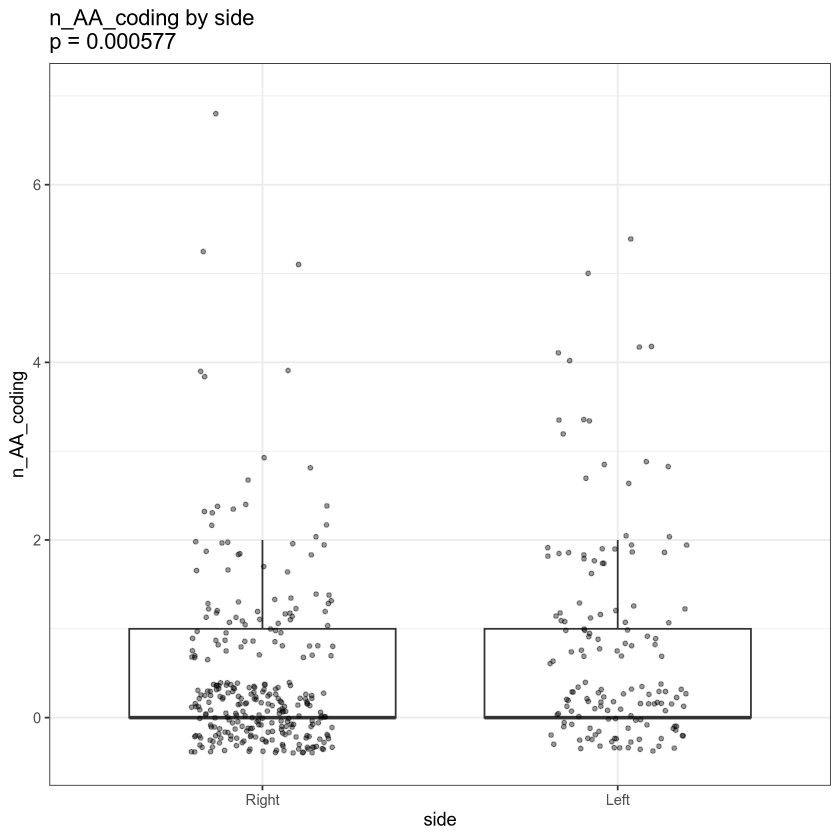

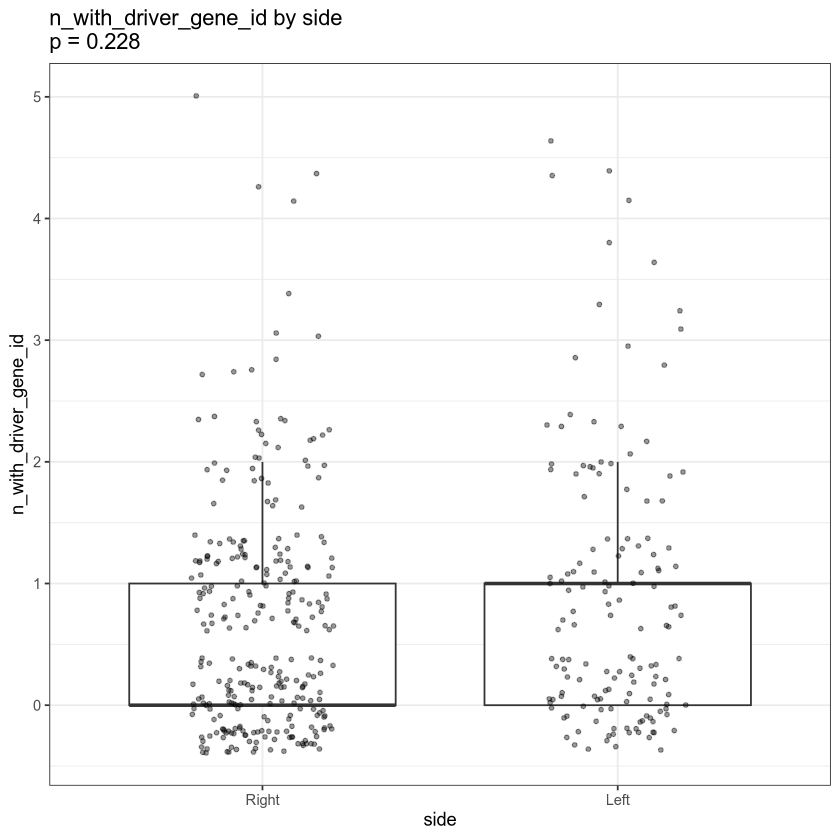

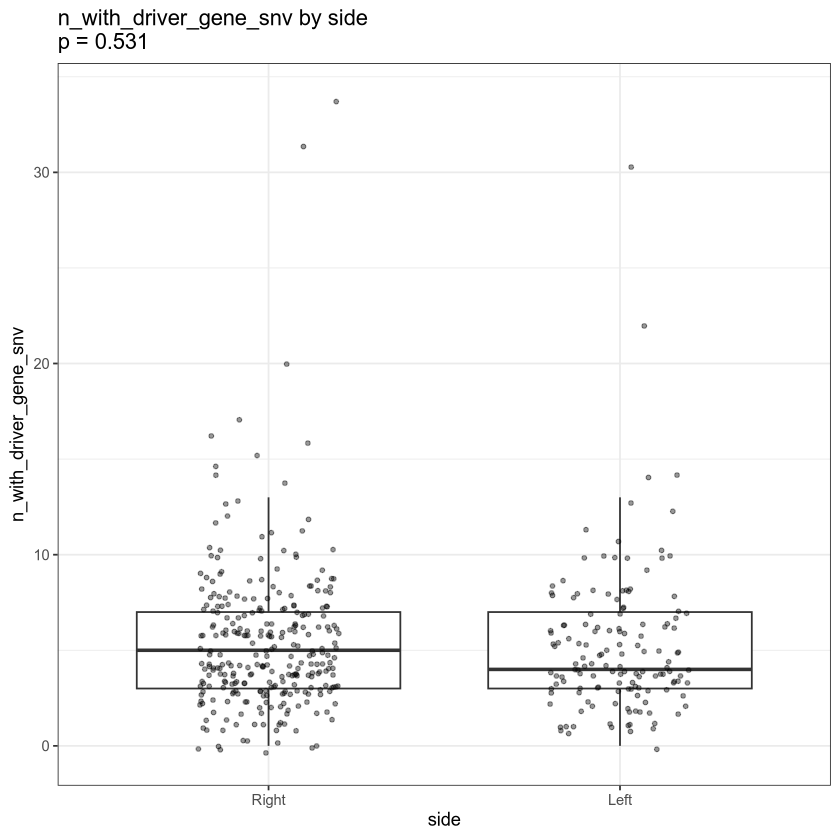

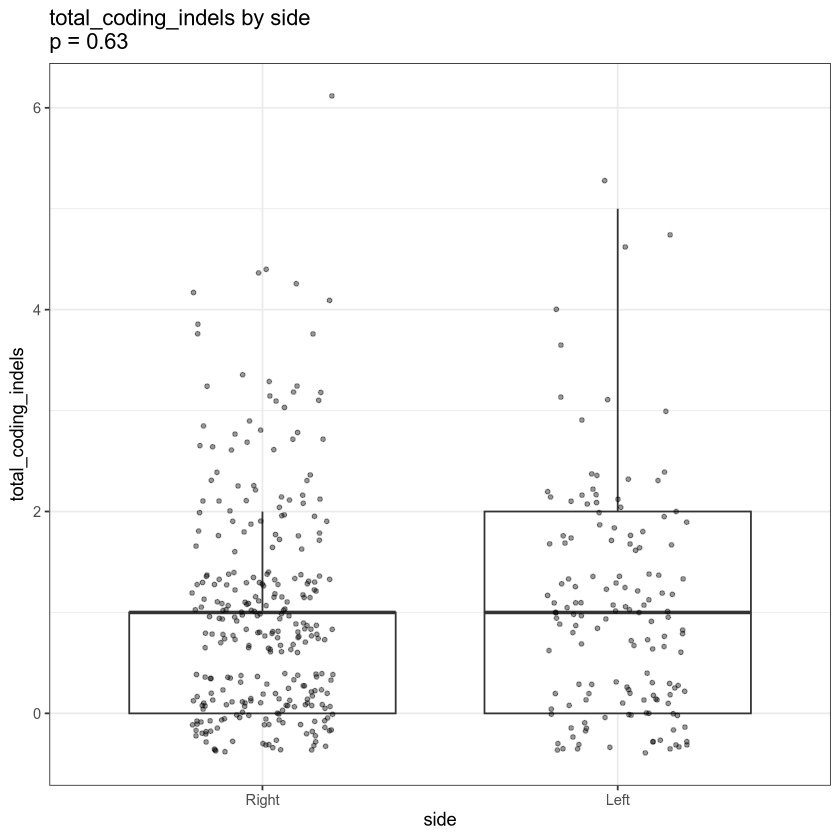

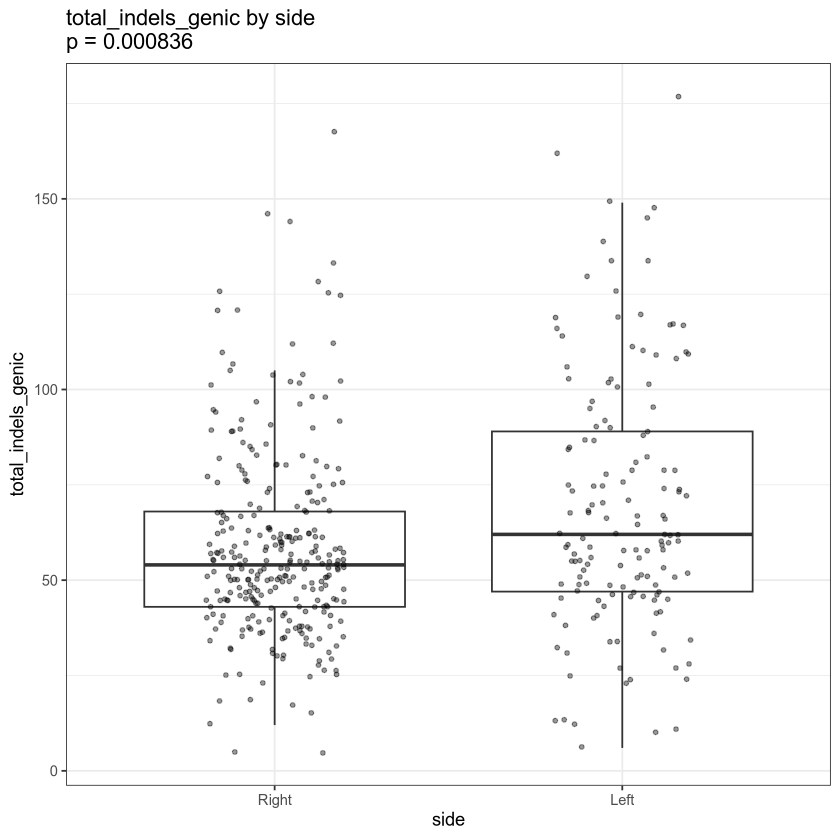

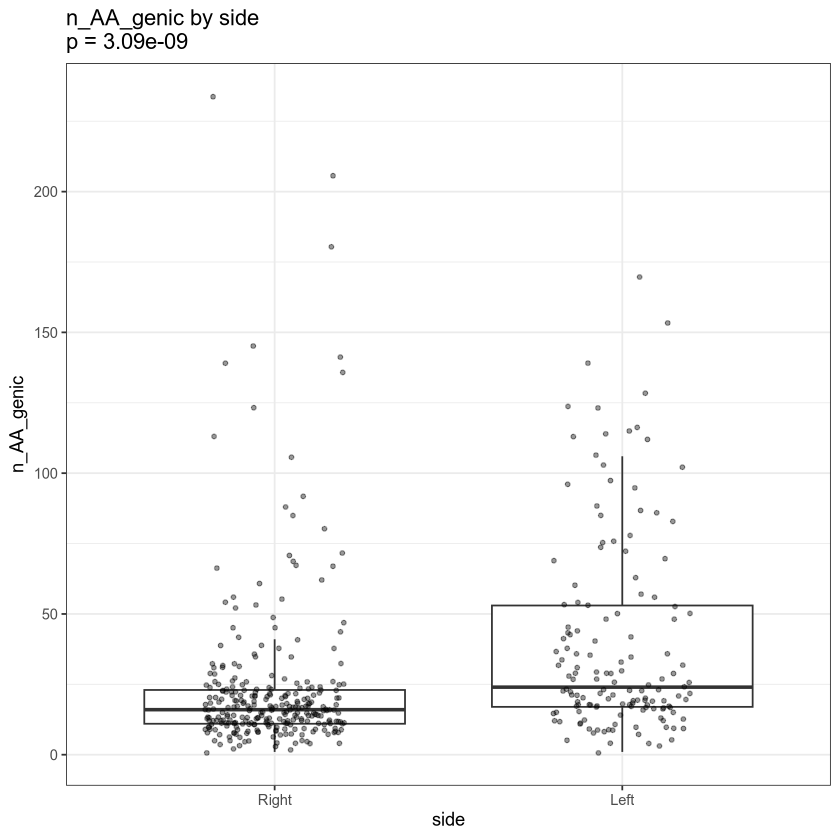

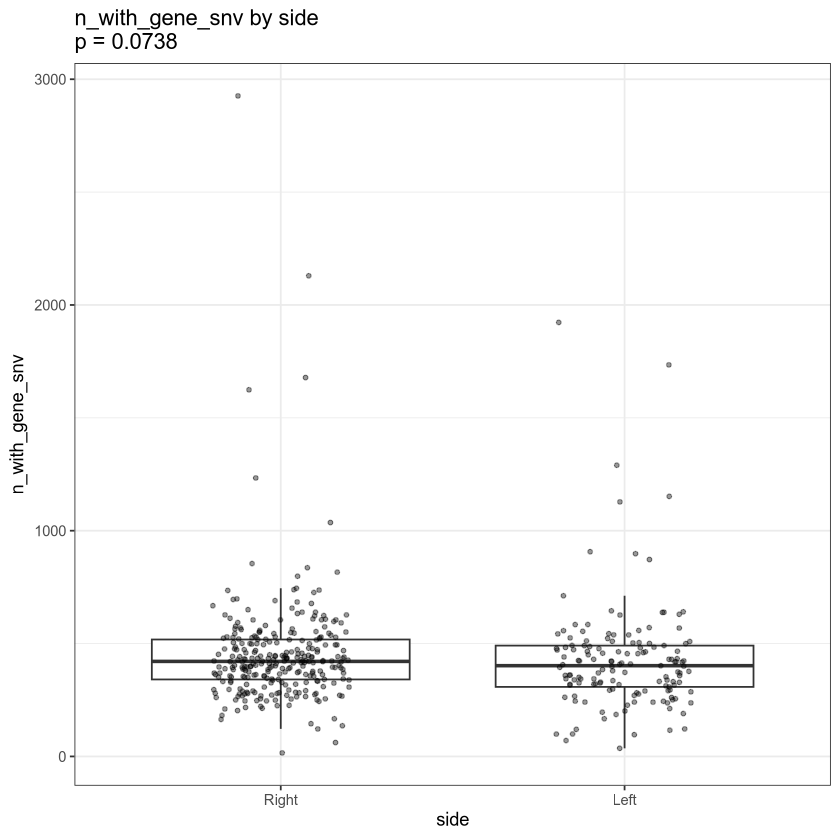

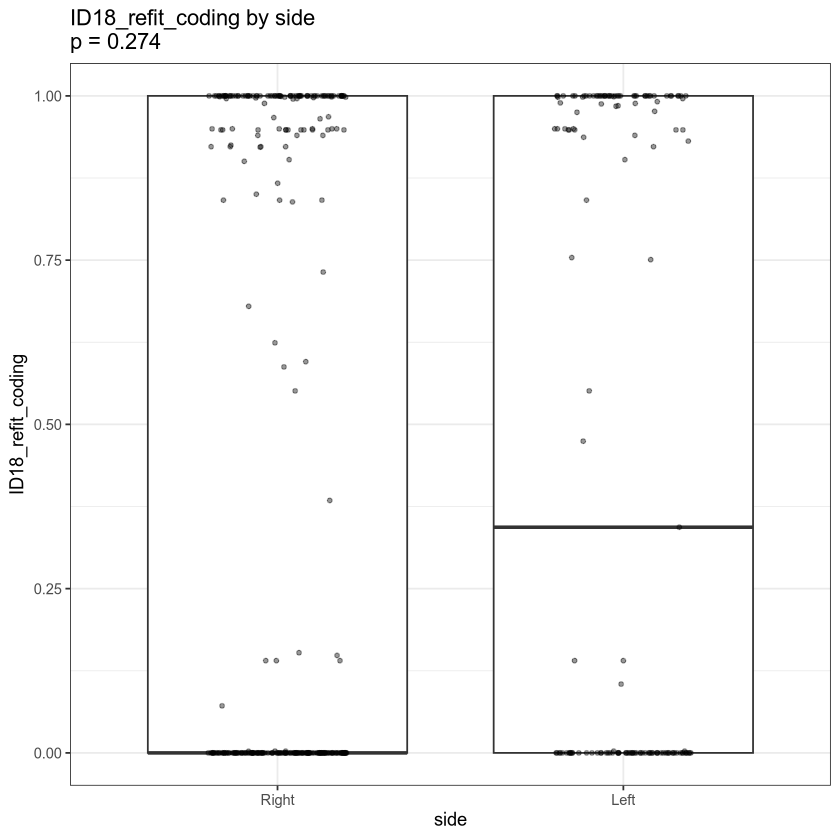

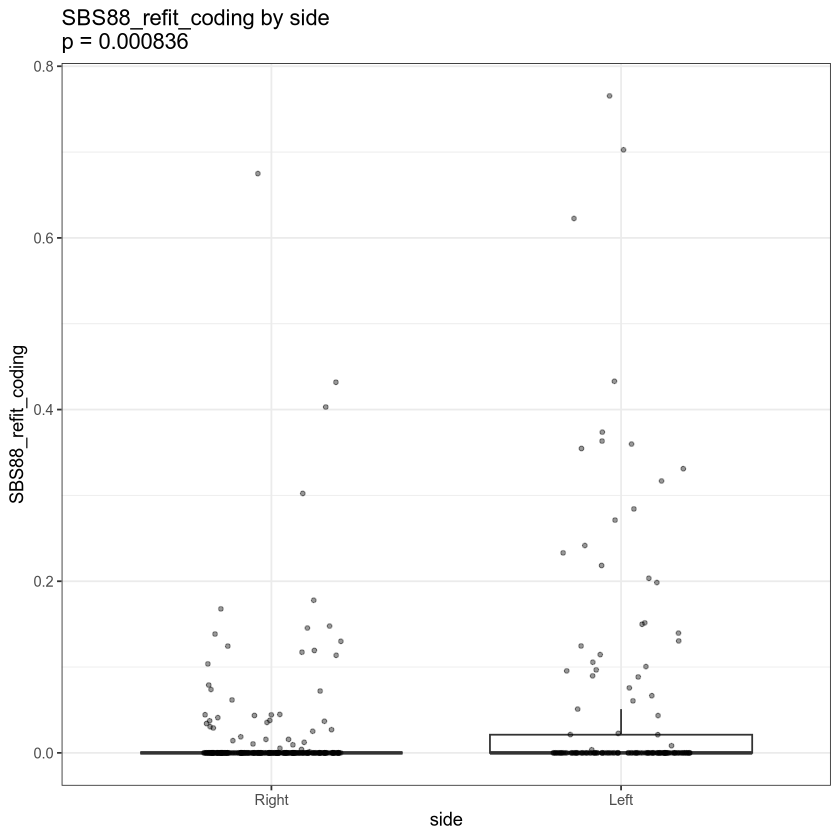

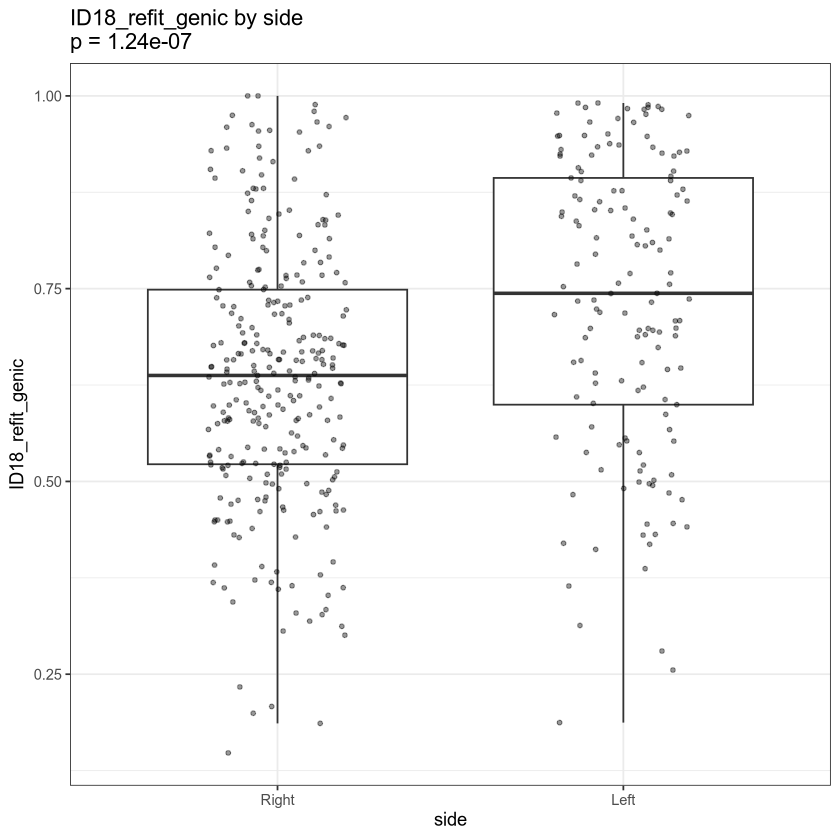

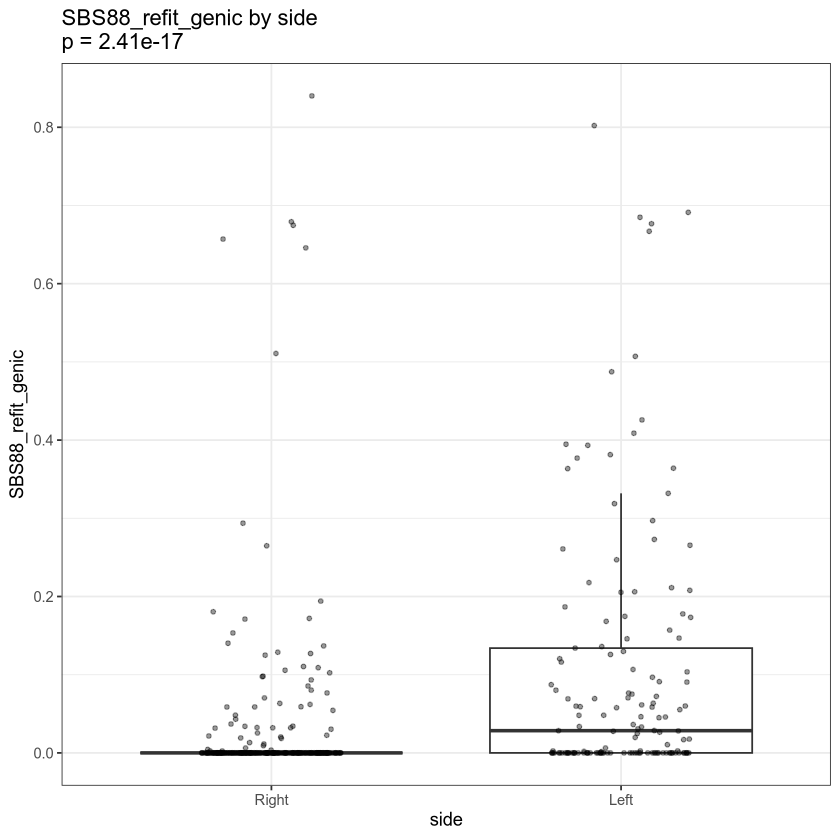

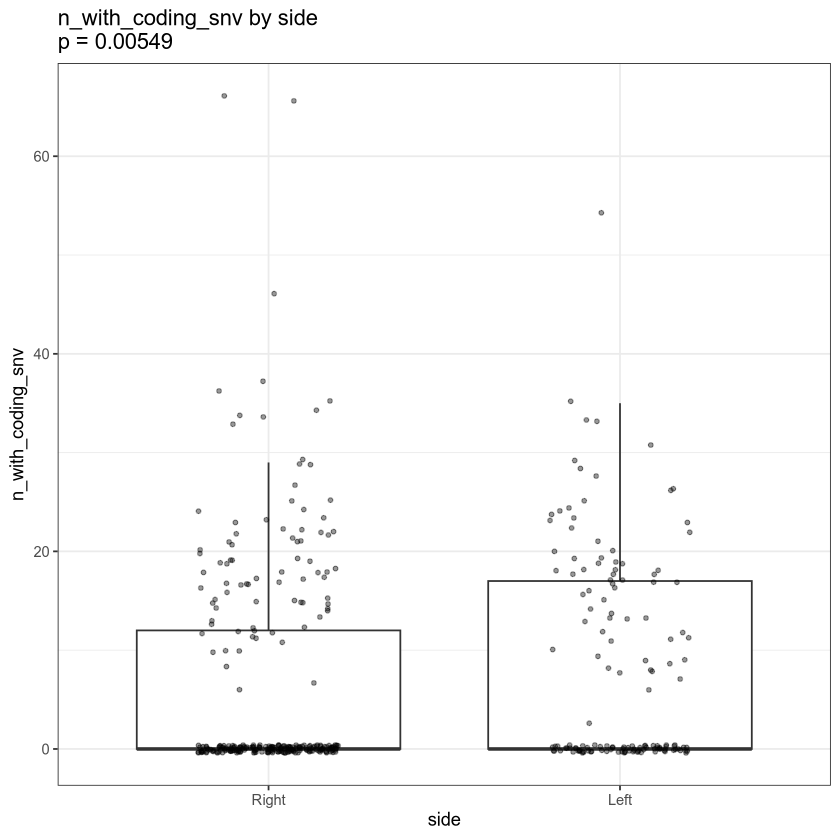

In [11]:
for (m in metrics) {

  test <- cor.test(
    combined_df$age,
    combined_df[[m]],
    method = "spearman",
    use = "complete.obs"
  )

  p <- ggplot(
    subset(combined_df, coverage > 9),
    aes(x = age, y = .data[[m]])
  ) +
    geom_point(alpha = 0.6, size = 1) +
    geom_smooth(method = "loess", se = FALSE) +
    theme_bw() +
    labs(
      title = paste0(
        m,
        " vs Age\nSpearman ρ = ",
        round(test$estimate, 3),
        ", p = ",
        signif(test$p.value, 3)
      ),
      x = "Age",
      y = m
    )

  print(p)
}

for (m in metrics) {

  n_groups <- n_distinct(combined_df$cohort)

  test <- if (n_groups == 2) {
    wilcox.test(
      combined_df[[m]] ~ combined_df$cohort
    )
  } else {
    kruskal.test(
      combined_df[[m]] ~ combined_df$cohort
    )
  }

  p <- ggplot(
    subset(combined_df, coverage > 9),
    aes(x = cohort, y = .data[[m]])
  ) +
    geom_boxplot(outlier.shape = NA) +
    geom_jitter(width = 0.2, alpha = 0.4, size = 1) +
    theme_bw() +
    labs(
      title = paste0(
        m,
        " by Cohort\np = ",
        signif(test$p.value, 3)
      ),
      x = "Cohort",
      y = m
    )

  print(p)
}

for (m in metrics) {

  n_groups <- n_distinct(combined_df$region)

  test <- if (n_groups == 2) {
    wilcox.test(
      combined_df[[m]] ~ combined_df$region
    )
  } else {
    kruskal.test(
      combined_df[[m]] ~ combined_df$region
    )
  }

  p <- ggplot(
    subset(combined_df, coverage > 9),
    aes(x = region, y = .data[[m]])
  ) +
    geom_boxplot(outlier.shape = NA) +
    geom_jitter(width = 0.2, alpha = 0.4, size = 1) +
    theme_bw() +
    labs(
      title = paste0(
        m,
        " by region\np = ",
        signif(test$p.value, 3)
      ),
      x = "region",
      y = m
    )

  print(p)
}

for (m in metrics) {

  n_groups <- n_distinct(combined_df$side)

  test <- if (n_groups == 2) {
    wilcox.test(
      combined_df[[m]] ~ combined_df$side
    )
  } else {
    kruskal.test(
      combined_df[[m]] ~ combined_df$side
    )
  }

  p <- ggplot(
    subset(combined_df, coverage > 9),
    aes(x = side, y = .data[[m]])
  ) +
    geom_boxplot(outlier.shape = NA) +
    geom_jitter(width = 0.2, alpha = 0.4, size = 1) +
    theme_bw() +
    labs(
      title = paste0(
        m,
        " by side\np = ",
        signif(test$p.value, 3)
      ),
      x = "side",
      y = m
    )

  print(p)
}
combined_df <- combined_df %>%
  mutate(
    region_tri = case_when(
      region %in% c("Right", "cecum", "asc_col") ~ "RIGHT",
      region == "trans_col" ~ "trans_col",
      TRUE ~ "LEFT"
    ),
    region_tri = factor(
      region_tri,
      levels = c("RIGHT", "trans_col", "LEFT")
    )
  )




In [ ]:
for (m in metrics) {

  p <- ggplot(
    subset(combined_df, coverage > 9),
    aes(
      x = region_tri,
      y = .data[[m]],
      fill = cohort
    )
  ) +
    geom_boxplot(
      position = position_dodge(width = 0.8),
      outlier.shape = NA
    ) +
    geom_jitter(
      position = position_jitterdodge(
        jitter.width = 0.2,
        dodge.width = 0.8
      ),
      alpha = 0.4,
      size = 1
    ) +
    theme_bw() +
    labs(
      title = paste(m, ": Cohorts within Anatomical Region"),
      x = "Anatomical Region",
      y = m,
      fill = "Cohort"
    )

  print(p)
}

comparisons <- list(
  c("normal", "adenoma"),
  c("normal", "carcinoma"),
  c("adenoma", "carcinoma")
)

safe_wilcox <- function(df, metric, region, g1, g2) {

  x <- df %>% filter(region_tri == region, cohort == g1) %>% pull(metric)
  y <- df %>% filter(region_tri == region, cohort == g2) %>% pull(metric)

  x <- x[!is.na(x)]
  y <- y[!is.na(y)]

  if (length(x) < 1 || length(y) < 1) return(NULL)
  if (length(unique(c(x, y))) == 1) return(NULL)

  tibble(
    region_tri = region,
    group1 = g1,
    group2 = g2,
    p = wilcox.test(x, y)$p.value
  )
}



In [ ]:
all_pvals <- bind_rows(
  map(metrics, function(m) {

    df <- combined_df %>%
      filter(coverage > 9) %>%
      select(region_tri, cohort, value = .data[[m]])

    expand_grid(
      region_tri = unique(df$region_tri),
      comp = comparisons
    ) %>%
      mutate(
        g1 = map_chr(comp, 1),
        g2 = map_chr(comp, 2)
      ) %>%
      pmap_dfr(~ safe_wilcox(df, "value", ..1, ..3, ..4)) %>%
      mutate(metric = m) %>%
      group_by(metric) %>%
      mutate(p.adj = p.adjust(p, method = "BH")) %>%
      ungroup()

  })
)


In [ ]:
all_pvals <- all_pvals %>%
  select(
    metric,
    region_tri,
    group1,
    group2,
    p,
    p.adj
  ) %>%
  arrange(metric, region_tri, group1, group2)

In [ ]:
map(metrics, function(m) {
  combined_df %>%
    filter(coverage > 9, !is.na(.data[[m]])) %>%
    count(region_tri, cohort) %>%
    mutate(metric = m)
})


`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
Warning message:
“Orientation is not uniquely specified when both the x and y aesthetics are
continuous. Picking default orientation 'x'.”


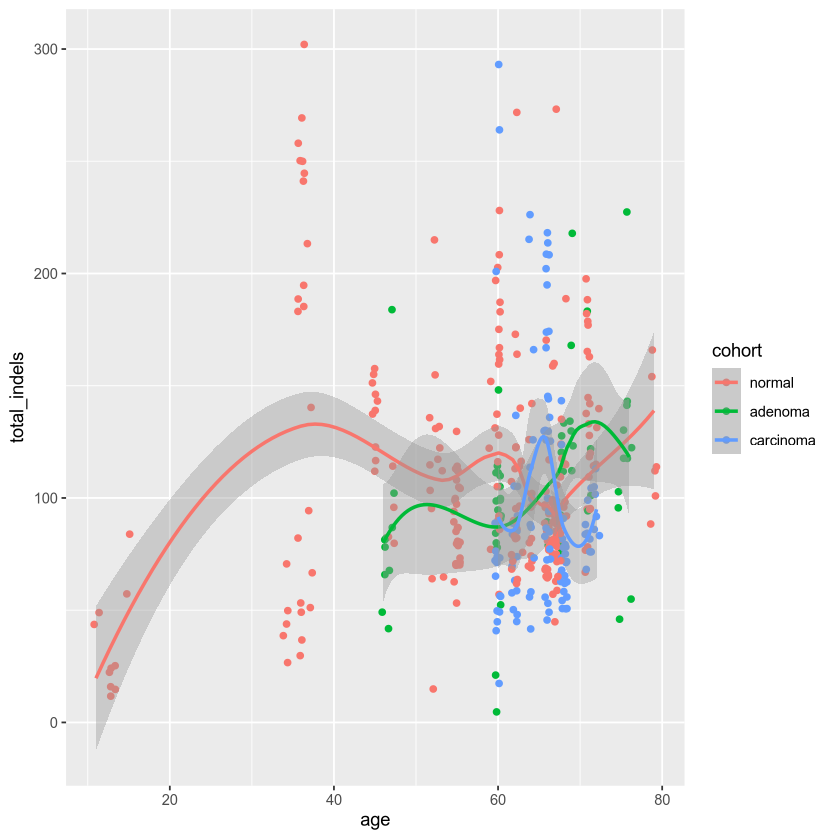

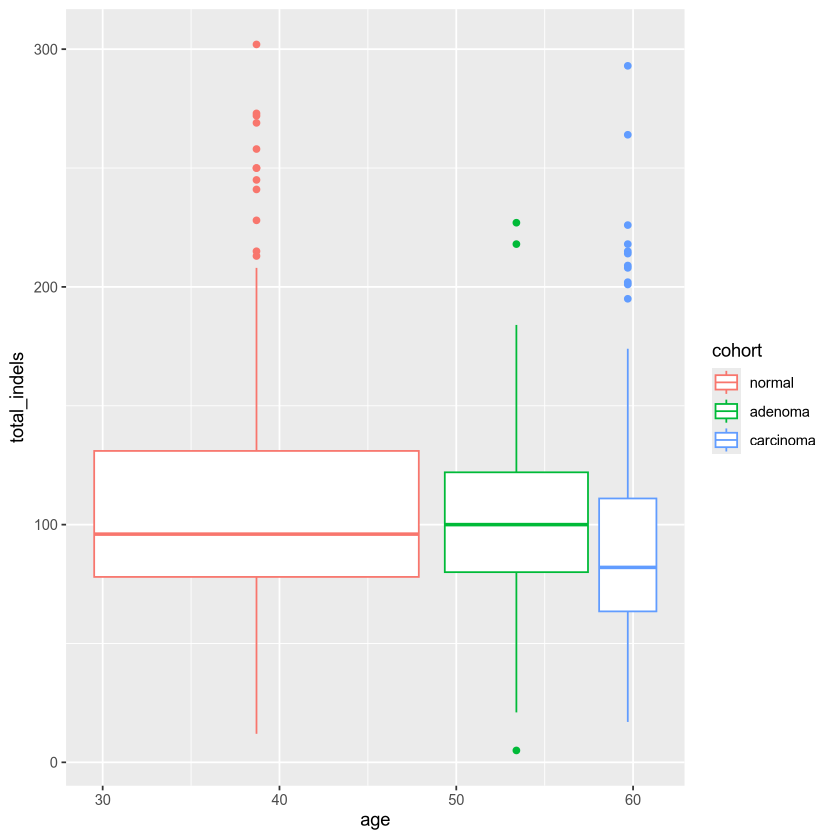

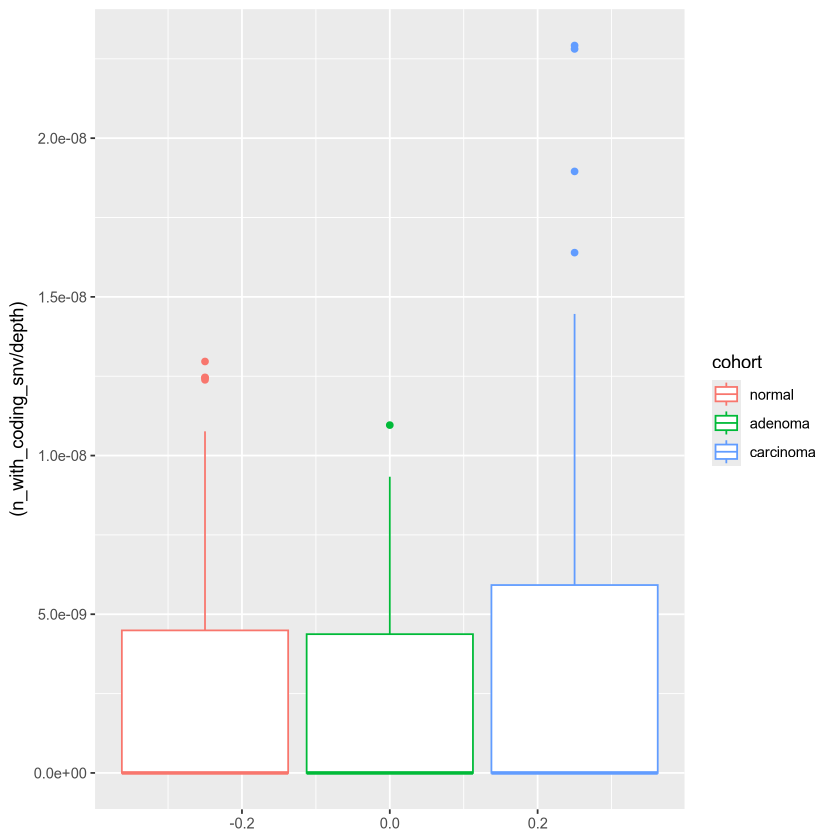

In [12]:
ggplot(subset(combined_df, coverage > 9)) + geom_jitter(aes(x=age, y=total_indels, color = cohort)) + geom_smooth(aes(x=age, y=total_indels, color = cohort))

ggplot(subset(combined_df, coverage > 9)) + geom_boxplot(aes(x=age, y=total_indels, color = cohort))

ggplot(subset(combined_df, coverage > 9)) + geom_boxplot(aes(y=(n_with_coding_snv/depth), color = cohort))



In [13]:
save.image(file = "ProcessData.RData")